In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

pd.set_option('display.max_columns', None)
import warnings 
warnings.filterwarnings('ignore')

In [12]:
from sklearn.feature_extraction import DictVectorizer

In [28]:
import optuna

In [2]:
from catboost import CatBoostClassifier
from sklearn.model_selection import  StratifiedKFold,train_test_split,cross_val_score 
from sklearn.metrics import log_loss,f1_score,roc_auc_score,recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier , AdaBoostClassifier
from sklearn.linear_model import  LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
data = pd.read_csv('data/NBA_Rookies_1979_2020(greater than 2 seasons).csv')
print(data.shape)
data.head()

(2842, 41)


,Unnamed: 0,Player,Team,Year,Conf,Age,Career,Games,MP,PTS,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,MPpg,PTSpg,FGpg,3Ppg,FTpg,ORBpg,DRBpg,TRBpg,ASTpg,STLpg,BLKpg,TOVpg,PFpg,Target
0,0,James Bailey,SEA,1979,WEST,22.0,9.0,67.0,726.0,312.0,122.0,271.0,0.450,0.0,0.0,0.000,68.0,101.0,0.673,71.0,126.0,197.0,28.0,21.0,54.0,79.0,116.0,10.84,4.7,1.82,0.00,1.01,1.06,1.88,2.9,0.4,0.31,0.81,1.18,1.73,1
1,1,Billy Ray Bates,POR,1980,WEST,23.0,4.0,16.0,235.0,180.0,72.0,146.0,0.493,8.0,19.0,0.421,28.0,39.0,0.718,13.0,16.0,29.0,31.0,14.0,2.0,20.0,26.0,14.69,11.3,4.50,0.50,1.75,0.81,1.00,1.8,1.9,0.88,0.12,1.25,1.62,1
2,2,Larry Bird*,BOS,1979,EAST,23.0,13.0,82.0,2955.0,1745.0,693.0,1463.0,0.474,58.0,143.0,0.406,301.0,360.0,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,36.04,21.3,8.45,0.71,3.67,2.63,7.76,10.4,4.5,1.74,0.65,3.21,3.40,1
3,3,Lawrence Boston,WSB,1980,EAST,23.0,1.0,13.0,125.0,56.0,24.0,52.0,0.462,0.0,0.0,0.000,8.0,13.0,0.615,19.0,20.0,39.0,2.0,4.0,2.0,8.0,25.0,9.62,4.3,1.85,0.00,0.62,1.46,1.54,3.0,0.2,0.31,0.15,0.62,1.92,0
4,4,Dudley Bradley,IND,1979,EAST,22.0,9.0,82.0,2027.0,688.0,275.0,609.0,0.452,2.0,5.0,0.400,136.0,174.0,0.782,69.0,154.0,223.0,252.0,211.0,48.0,166.0,194.0,24.72,8.4,3.35,0.02,1.66,0.84,1.88,2.7,3.1,2.57,0.59,2.02,2.37,1


In [4]:
team_map ={
    'NOK':'NOP',#pelicans
    'SDC':'LAC',# clippers
    #'NOP':'NOP',#pelicans
    'CHO':'CHH', #hornets
    'KCK':'SAC', # kings
    'VAN':'MEM', # grizzs
    'NOH':'NOP', # pelicans
    #'BRK':'BRK', # Nets
    'CHA':'CHH', # hornets
    #'OKC':'OKC', # okc
    'WAS':'WSH', #wizards
    #'TOR':'TOR', # raptors
    'WSB':'WSH', # wizards
    'SEA':'OKC', # sonics now okc
    'NJN':'BRK',#nets
    }

In [5]:
for old_team, new_team in team_map.items():
    data['Team'].replace(old_team, new_team, inplace=True)
    
data.rename(columns = {'Target':'target>=2'}, inplace = True)

data['target>=3'] = data.apply(lambda x : 1 if x.Career >=3  else 0 ,axis=1)
data['target>=4'] = data.apply(lambda x : 1 if x.Career >=4  else 0 ,axis=1)
data['target>=5'] = data.apply(lambda x : 1 if x.Career >=5  else 0 ,axis=1)

data['Team_index'] = data['Team'].astype('category').cat.codes
data['Year_index'] = data['Year'].astype('category').cat.codes

train = data[data.Year<=2017]
print(train.shape)
train.head()

(2709, 46)


,Unnamed: 0,Player,Team,Year,Conf,Age,Career,Games,MP,PTS,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,MPpg,PTSpg,FGpg,3Ppg,FTpg,ORBpg,DRBpg,TRBpg,ASTpg,STLpg,BLKpg,TOVpg,PFpg,target>=2,target>=3,target>=4,target>=5,Team_index,Year_index
0,0,James Bailey,OKC,1979,WEST,22.0,9.0,67.0,726.0,312.0,122.0,271.0,0.450,0.0,0.0,0.000,68.0,101.0,0.673,71.0,126.0,197.0,28.0,21.0,54.0,79.0,116.0,10.84,4.7,1.82,0.00,1.01,1.06,1.88,2.9,0.4,0.31,0.81,1.18,1.73,1,1,1,1,20,0
1,1,Billy Ray Bates,POR,1980,WEST,23.0,4.0,16.0,235.0,180.0,72.0,146.0,0.493,8.0,19.0,0.421,28.0,39.0,0.718,13.0,16.0,29.0,31.0,14.0,2.0,20.0,26.0,14.69,11.3,4.50,0.50,1.75,0.81,1.00,1.8,1.9,0.88,0.12,1.25,1.62,1,1,1,0,24,1
2,2,Larry Bird*,BOS,1979,EAST,23.0,13.0,82.0,2955.0,1745.0,693.0,1463.0,0.474,58.0,143.0,0.406,301.0,360.0,0.836,216.0,636.0,852.0,370.0,143.0,53.0,263.0,279.0,36.04,21.3,8.45,0.71,3.67,2.63,7.76,10.4,4.5,1.74,0.65,3.21,3.40,1,1,1,1,1,0
3,3,Lawrence Boston,WSH,1980,EAST,23.0,1.0,13.0,125.0,56.0,24.0,52.0,0.462,0.0,0.0,0.000,8.0,13.0,0.615,19.0,20.0,39.0,2.0,4.0,2.0,8.0,25.0,9.62,4.3,1.85,0.00,0.62,1.46,1.54,3.0,0.2,0.31,0.15,0.62,1.92,0,0,0,0,29,1
4,4,Dudley Bradley,IND,1979,EAST,22.0,9.0,82.0,2027.0,688.0,275.0,609.0,0.452,2.0,5.0,0.400,136.0,174.0,0.782,69.0,154.0,223.0,252.0,211.0,48.0,166.0,194.0,24.72,8.4,3.35,0.02,1.66,0.84,1.88,2.7,3.1,2.57,0.59,2.02,2.37,1,1,1,1,11,0


In [6]:
pgs =[i for i  in train.columns if 'pg' in i]
pgs

['MPpg',
 'PTSpg',
 'FGpg',
 '3Ppg',
 'FTpg',
 'ORBpg',
 'DRBpg',
 'TRBpg',
 'ASTpg',
 'STLpg',
 'BLKpg',
 'TOVpg',
 'PFpg']

In [7]:
predictors = pgs +['Age','Year_index','Team_index','FT', 'FT%','Games', 'MP','FG%']

In [8]:
def train_model(model,df, y, C=1.0):
    cat = df[predictors].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    #model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

def train_model_lr(df, y, C=1.0):
    cat = df[predictors].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model
def predict(df, dv, model):
    cat = df[predictors].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [9]:
def run_folds(model,df_train_full,target,thresh, nfolds = 5):
    kfold = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=1)
    aucs = [] ; aucs1 = []
    accuracys = [] ; accuracys1 = []
    recalls = [] ; recalls1 = []
    f1s =[] ; f1s1 =[]
    fold=1
    for train_idx, val_idx in kfold.split(df_train_full,df_train_full[target]):
            df_train = df_train_full.iloc[train_idx]
            df_val = df_train_full.iloc[val_idx]

            y_train = df_train[target].values
            y_val = df_val[target].values

            dv, model = train_model(model,df_train, y_train)
            
            y_pred_train = predict(df_train, dv, model)
            y_pred_test = predict(df_val, dv, model)
            
            preds_train =  (y_pred_train>= thresh)*1
            preds_test =  (y_pred_test>= thresh)*1

            accuracy = roc_auc_score(y_val, preds_test)
            accuracy1 = roc_auc_score(y_train, preds_train)
            
            auc = roc_auc_score(y_val, y_pred_test)
            auc1 = roc_auc_score(y_train, y_pred_train)
            #print(f'auc for fold {fold} = ',auc)
            
            recall = recall_score(y_val, preds_test)
            recall1 = recall_score(y_train, preds_train)
            #print(f'recall for fold {fold} = ',recall)
            
            f1 = f1_score(y_val, preds_test)
            f11 = f1_score(y_train, preds_train)
            #print(f'f1 for fold {fold} = ',f1)
            
            accuracys.append(accuracy) ; accuracys1.append(accuracy1)
            aucs.append(auc) ; aucs1.append(auc1)
            recalls.append(recall) ;recalls1.append(recall1)
            f1s.append(f1) ; f1s1.append(f11)
            print(f"fold {fold} done")
            fold+=1
    print()       
    print(' train accuracy = %0.3f ± %0.3f' % ( np.mean(accuracys1), np.std(accuracys1)))
    print(' test accuracy = %0.3f ± %0.3f' % ( np.mean(accuracys), np.std(accuracys)))        
    print()
    print(' train auc = %0.3f ± %0.3f' % ( np.mean(aucs1), np.std(aucs1)))
    print(' test auc = %0.3f ± %0.3f' % ( np.mean(aucs), np.std(aucs)))
    print()
    print(' train recall = %0.3f ± %0.3f' % ( np.mean(recalls1), np.std(recalls1)))
    print(' test  recall = %0.3f ± %0.3f' % ( np.mean(recalls), np.std(recalls)))
    print()
    print(' train f1 = %0.3f ± %0.3f' % ( np.mean(f1s1), np.std(f1s1)))
    print(' test f1 = %0.3f ± %0.3f' % ( np.mean(f1s), np.std(f1s)))
    print("=====================================")
    return np.mean(accuracys),np.mean(aucs) ,np.mean(recalls),np.mean(f1s)

In [13]:
acc=[]
for n in range(100,2000,25):
    print(f'estimators = {n}')
    #Knn = KNeighborsClassifier(n_neighbors=n)
    rf_model = RandomForestClassifier(n_estimators=n) 
    accuracy,auc ,recall , f1= run_folds(model=rf_model,df_train_full=train,target='target>=5', thresh =0.5 ,nfolds = 5)
    acc.append([accuracy,auc ,recall , f1])
    print()
    print('==================================')
    print()

estimators = 100
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.748 ± 0.024

 train auc = 1.000 ± 0.000
 test auc = 0.828 ± 0.023

 train recall = 1.000 ± 0.000
 test  recall = 0.727 ± 0.028

 train f1 = 1.000 ± 0.000
 test f1 = 0.743 ± 0.024


estimators = 125
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.750 ± 0.024

 train auc = 1.000 ± 0.000
 test auc = 0.831 ± 0.023

 train recall = 1.000 ± 0.000
 test  recall = 0.720 ± 0.027

 train f1 = 1.000 ± 0.000
 test f1 = 0.742 ± 0.025


estimators = 150
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.756 ± 0.023

 train auc = 1.000 ± 0.000
 test auc = 0.829 ± 0.025

 train recall = 1.000 ± 0.000
 test  recall = 0.724 ± 0.019

 train f1 = 1.000 ± 0.000
 test f1 = 0.747 ± 0.022


estimators = 175
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.752 ± 0.022

 train auc = 1.000 ± 0.000
 test auc = 0.832 ± 0.023

 train recall = 1.000 ± 0.000
 test  recall = 0.713 ± 0.025

 train f1 = 1.000 ± 0.000
 test f1 = 0.741 ± 0.023


estimators = 675
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.749 ± 0.023

 train auc = 1.000 ± 0.000
 test auc = 0.832 ± 0.023

 train recall = 1.000 ± 0.000
 test  recall = 0.715 ± 0.024

 train f1 = 1.000 ± 0.000
 test f1 = 0.740 ± 0.023


estimators = 700
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 1.000 ± 0.000
 test accuracy = 0.750 ± 0.023

 train auc = 1.000 ± 0.000
 test auc = 0.832 ± 0.022

 train recall = 1.000 ± 0.000
 test  recall = 0.711 ± 0.022

 train f1 = 1.000 ± 0.000
 test f1 = 0.740 ± 0.023


estimators = 725
fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train ac

KeyboardInterrupt: 

In [17]:
len(acc)

37

ValueError: x and y must have same first dimension, but have shapes (76,) and (37,)

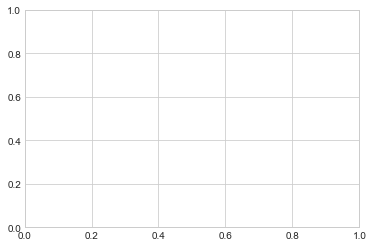

In [16]:
plt.style.use("seaborn-whitegrid")
plt.plot(range(100,2000,25),np.array(acc)[:,0], color='green', marker='+', linestyle='dashed', linewidth=2, markersize=12,label='acc')
#plt.plot(threshs,np.array(acc)[:,1], color='red', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.plot(range(100,2000,25),np.array(acc)[:,-1], color='black', marker='*', linestyle='dashed', linewidth=2, markersize=12,label='f1')
plt.legend()

In [21]:
from sklearn.model_selection import GridSearchCV ,RandomizedSearchCV

param_grid = [
{'n_estimators': [20, 300, 500, 800, 1200], 
 'max_features': [5, 10], 
 'max_depth': [ 2,5, 8, 15, 25, 30, None], 
 'bootstrap': [True, False],
 'min_samples_split' :[ 1, 2, 5, 10, 15, 100],
 'min_samples_leaf' : [ 1, 2, 5, 10]
}
]

#grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
#grid_search_forest.fit(x_train, y_train)

In [31]:
X = train[predictors]
y = train['target>=5']

In [24]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = param_grid, n_iter = 20, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions=[{'bootstrap': [True, False],
                                         'max_depth': [2, 5, 8, 15, 25, 30,
                                                       None],
                                         'max_features': [5, 10],
                                         'min_samples_leaf': [1, 2, 5, 10],
                                         'min_samples_split': [1, 2, 5, 10, 15,
                                                               100],
                                         'n_estimators': [20, 300, 500, 800,
                                                          1200]}],
                   random_state=42, scoring='accuracy', verbose=2)

In [25]:
# best random model 
rf_random.best_estimator_

RandomForestClassifier(max_depth=30, max_features=5, min_samples_leaf=2,
                       n_estimators=800)

In [26]:
rf = RandomForestClassifier(max_depth=30, max_features=5, min_samples_leaf=2,
                       n_estimators=800)

In [27]:
run_folds(model=rf,df_train_full=train,target='target>=5', thresh =0.5 ,nfolds = 5)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 0.993 ± 0.001
 test accuracy = 0.753 ± 0.020

 train auc = 1.000 ± 0.000
 test auc = 0.833 ± 0.022

 train recall = 0.991 ± 0.001
 test  recall = 0.723 ± 0.024

 train f1 = 0.993 ± 0.001
 test f1 = 0.745 ± 0.021


(0.7526588564905257,
 0.8329092347305066,
 0.7228399617329506,
 0.7448302732282656)

In [47]:
def optimise(trial):
    oof_f1=[]
    oof_predictions_actual_test = []
    
    param = {}
    """
    # param['objective'] ='Logloss'
    param['learning_rate'] = trial.suggest_discrete_uniform('learning_rate',0.001,0.1,0.001)
    param['depth'] = trial.suggest_int('depth',3,15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg',1,5.5,0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples',[1,4,8,16,32])
    param['iterations'] = trial.suggest_discrete_uniform('iterations',200,1000,50)
    param['use_best_model']= True
    param['colsample_bylevel']= trial.suggest_float('colsample_bylevel',0.01,0.1)
    param['random_state']=0
    param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['bootstrap_type']= trial.suggest_categorical('bootstrap_type',['Bayesian','Bernoulli','MVS'])
    param['logging_level'] ='Silent' 
    """
    param['learning_rate'] = trial.suggest_float('learning_rate',0.001,0.25,log=True)
    #param['learning_rate'] = trial.suggest_float('learning_rate',0.001,0.25,log=True)
    param['subsample'] = trial.suggest_float('subsample',0.1,1.0)
    param['colsample_bytree']= trial.suggest_float('colsample_bytree',0.1,1)
    param['max_depth'] = trial.suggest_int('max_depth',5,15)
    param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples',[1,4,8,16,32])
    
    
    fold = StratifiedKFold(n_splits=5)
    i=1
    for train_idx,test_idx in fold.split( X,y):
        X_train, X_test =X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMClassifier(**param,n_estimators=1000)

        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=300,eval_metric='auc',verbose=100)
        preds = model.predict(X_test)
        oof_f1.append(accuracy_score(y_test,preds))
    
    return np.mean(oof_f1)

In [48]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(optimise,n_trials = 100)

[I 2022-07-30 19:21:13,682] A new study created in memory with name: no-name-35555ac0-d3ba-4d6e-866c-2d1778167ef6


[100]	training's auc: 0.912798	training's binary_logloss: 0.580537	valid_1's auc: 0.841832	valid_1's binary_logloss: 0.611017
[200]	training's auc: 0.923087	training's binary_logloss: 0.512164	valid_1's auc: 0.84254	valid_1's binary_logloss: 0.572402
[300]	training's auc: 0.933441	training's binary_logloss: 0.464375	valid_1's auc: 0.843099	valid_1's binary_logloss: 0.554784
[400]	training's auc: 0.943311	training's binary_logloss: 0.427669	valid_1's auc: 0.842105	valid_1's binary_logloss: 0.547393
[500]	training's auc: 0.953254	training's binary_logloss: 0.39712	valid_1's auc: 0.841669	valid_1's binary_logloss: 0.542701
[100]	training's auc: 0.920785	training's binary_logloss: 0.578291	valid_1's auc: 0.828733	valid_1's binary_logloss: 0.608299
[200]	training's auc: 0.930244	training's binary_logloss: 0.508463	valid_1's auc: 0.827923	valid_1's binary_logloss: 0.567264
[300]	training's auc: 0.939264	training's binary_logloss: 0.459678	valid_1's auc: 0.827807	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:21:22,783] Trial 0 finished with value: 0.7264659541234969 and parameters: {'learning_rate': 0.004026116257361479, 'subsample': 0.14178379521016757, 'colsample_bytree': 0.49713618089275824, 'max_depth': 13, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 0 with value: 0.7264659541234969.


[100]	training's auc: 0.961706	training's binary_logloss: 0.50433	valid_1's auc: 0.836998	valid_1's binary_logloss: 0.731319
[200]	training's auc: 0.996325	training's binary_logloss: 0.326395	valid_1's auc: 0.834493	valid_1's binary_logloss: 0.719724
[300]	training's auc: 0.999837	training's binary_logloss: 0.213748	valid_1's auc: 0.834901	valid_1's binary_logloss: 0.694752
[100]	training's auc: 0.964019	training's binary_logloss: 0.502595	valid_1's auc: 0.822905	valid_1's binary_logloss: 0.674476
[200]	training's auc: 0.997443	training's binary_logloss: 0.319963	valid_1's auc: 0.820686	valid_1's binary_logloss: 0.667505
[300]	training's auc: 0.999956	training's binary_logloss: 0.209255	valid_1's auc: 0.819678	valid_1's binary_logloss: 0.659957
[100]	training's auc: 0.958247	training's binary_logloss: 0.500771	valid_1's auc: 0.81031	valid_1's binary_logloss: 0.672221
[200]	training's auc: 0.997348	training's binary_logloss: 0.321462	valid_1's auc: 0.809275	valid_1's binary_logloss: 0.6

[I 2022-07-30 19:21:26,990] Trial 1 finished with value: 0.6504552864382618 and parameters: {'learning_rate': 0.03045763905687686, 'subsample': 0.48950220147672374, 'colsample_bytree': 0.38279450522475666, 'max_depth': 10, 'scale_pos_weight': 10, 'min_child_samples': 4}. Best is trial 0 with value: 0.7264659541234969.


[100]	training's auc: 0.892141	training's binary_logloss: 0.634119	valid_1's auc: 0.837523	valid_1's binary_logloss: 0.648809
[200]	training's auc: 0.899789	training's binary_logloss: 0.589015	valid_1's auc: 0.835569	valid_1's binary_logloss: 0.618786
[300]	training's auc: 0.906964	training's binary_logloss: 0.552537	valid_1's auc: 0.835187	valid_1's binary_logloss: 0.596949
[100]	training's auc: 0.91076	training's binary_logloss: 0.633229	valid_1's auc: 0.824158	valid_1's binary_logloss: 0.644889
[200]	training's auc: 0.916149	training's binary_logloss: 0.58702	valid_1's auc: 0.82616	valid_1's binary_logloss: 0.610492
[300]	training's auc: 0.920074	training's binary_logloss: 0.550276	valid_1's auc: 0.825513	valid_1's binary_logloss: 0.587175
[400]	training's auc: 0.923455	training's binary_logloss: 0.5203	valid_1's auc: 0.825949	valid_1's binary_logloss: 0.570586
[100]	training's auc: 0.899725	training's binary_logloss: 0.632041	valid_1's auc: 0.79924	valid_1's binary_logloss: 0.64931

[I 2022-07-30 19:21:38,179] Trial 2 finished with value: 0.722037909843054 and parameters: {'learning_rate': 0.0016643613132091865, 'subsample': 0.6274305611528667, 'colsample_bytree': 0.9459158011544689, 'max_depth': 11, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 0 with value: 0.7264659541234969.


[100]	training's auc: 0.892028	training's binary_logloss: 0.640609	valid_1's auc: 0.83757	valid_1's binary_logloss: 0.653358
[200]	training's auc: 0.89704	training's binary_logloss: 0.599218	valid_1's auc: 0.836712	valid_1's binary_logloss: 0.625142
[300]	training's auc: 0.904702	training's binary_logloss: 0.565363	valid_1's auc: 0.835358	valid_1's binary_logloss: 0.603994
[100]	training's auc: 0.910075	training's binary_logloss: 0.639784	valid_1's auc: 0.824369	valid_1's binary_logloss: 0.650115
[200]	training's auc: 0.915283	training's binary_logloss: 0.597418	valid_1's auc: 0.826357	valid_1's binary_logloss: 0.618213
[300]	training's auc: 0.919332	training's binary_logloss: 0.562946	valid_1's auc: 0.825881	valid_1's binary_logloss: 0.594548
[400]	training's auc: 0.921353	training's binary_logloss: 0.534568	valid_1's auc: 0.825506	valid_1's binary_logloss: 0.578326
[500]	training's auc: 0.925121	training's binary_logloss: 0.510081	valid_1's auc: 0.826058	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:21:49,604] Trial 3 finished with value: 0.7205612130058455 and parameters: {'learning_rate': 0.0014576642648346499, 'subsample': 0.8790251803836162, 'colsample_bytree': 0.9381210646613302, 'max_depth': 15, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 0 with value: 0.7264659541234969.


[500]	training's auc: 0.919871	training's binary_logloss: 0.507431	valid_1's auc: 0.681311	valid_1's binary_logloss: 0.610483
[100]	training's auc: 0.916359	training's binary_logloss: 0.477422	valid_1's auc: 0.844971	valid_1's binary_logloss: 0.553215
[200]	training's auc: 0.939998	training's binary_logloss: 0.401224	valid_1's auc: 0.841819	valid_1's binary_logloss: 0.543495
[300]	training's auc: 0.956001	training's binary_logloss: 0.357641	valid_1's auc: 0.84156	valid_1's binary_logloss: 0.546766
[100]	training's auc: 0.917853	training's binary_logloss: 0.478341	valid_1's auc: 0.829577	valid_1's binary_logloss: 0.539994
[200]	training's auc: 0.939215	training's binary_logloss: 0.404464	valid_1's auc: 0.832369	valid_1's binary_logloss: 0.523871
[300]	training's auc: 0.955851	training's binary_logloss: 0.35956	valid_1's auc: 0.832042	valid_1's binary_logloss: 0.527355
[400]	training's auc: 0.97203	training's binary_logloss: 0.319104	valid_1's auc: 0.830721	valid_1's binary_logloss: 0.53

[I 2022-07-30 19:21:55,152] Trial 4 finished with value: 0.7312670945563431 and parameters: {'learning_rate': 0.011879888610750634, 'subsample': 0.22704246668065578, 'colsample_bytree': 0.7281461006056881, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 4 with value: 0.7312670945563431.



[100]	training's auc: 0.893925	training's binary_logloss: 0.610801	valid_1's auc: 0.83934	valid_1's binary_logloss: 0.641783
[200]	training's auc: 0.89802	training's binary_logloss: 0.566847	valid_1's auc: 0.839722	valid_1's binary_logloss: 0.627856
[300]	training's auc: 0.903191	training's binary_logloss: 0.541034	valid_1's auc: 0.837346	valid_1's binary_logloss: 0.630619
[400]	training's auc: 0.91219	training's binary_logloss: 0.523652	valid_1's auc: 0.836815	valid_1's binary_logloss: 0.63691
[100]	training's auc: 0.892399	training's binary_logloss: 0.612919	valid_1's auc: 0.814627	valid_1's binary_logloss: 0.630689
[200]	training's auc: 0.904423	training's binary_logloss: 0.570462	valid_1's auc: 0.824294	valid_1's binary_logloss: 0.604342
[300]	training's auc: 0.915548	training's binary_logloss: 0.545072	valid_1's auc: 0.827828	valid_1's binary_logloss: 0.597473
[400]	training's auc: 0.922902	training's binary_logloss: 0.528239	valid_1's auc: 0.827807	valid_1's binary_logloss: 0.59

[I 2022-07-30 19:22:03,570] Trial 5 finished with value: 0.6640750011936348 and parameters: {'learning_rate': 0.0032814539119549553, 'subsample': 0.24873541915596953, 'colsample_bytree': 0.9570083933962386, 'max_depth': 8, 'scale_pos_weight': 6, 'min_child_samples': 16}. Best is trial 4 with value: 0.7312670945563431.


[300]	training's auc: 0.90715	training's binary_logloss: 0.536836	valid_1's auc: 0.814637	valid_1's binary_logloss: 0.552863
[100]	training's auc: 0.919788	training's binary_logloss: 0.535247	valid_1's auc: 0.840716	valid_1's binary_logloss: 0.621824
[200]	training's auc: 0.947155	training's binary_logloss: 0.471358	valid_1's auc: 0.840838	valid_1's binary_logloss: 0.634832
[300]	training's auc: 0.971134	training's binary_logloss: 0.409504	valid_1's auc: 0.840185	valid_1's binary_logloss: 0.642751
[100]	training's auc: 0.92496	training's binary_logloss: 0.535034	valid_1's auc: 0.82776	valid_1's binary_logloss: 0.596606
[200]	training's auc: 0.951963	training's binary_logloss: 0.468976	valid_1's auc: 0.828536	valid_1's binary_logloss: 0.595245
[300]	training's auc: 0.973667	training's binary_logloss: 0.40581	valid_1's auc: 0.83	valid_1's binary_logloss: 0.593382
[400]	training's auc: 0.988665	training's binary_logloss: 0.346834	valid_1's auc: 0.831062	valid_1's binary_logloss: 0.591962


[I 2022-07-30 19:22:09,589] Trial 6 finished with value: 0.6947384575509341 and parameters: {'learning_rate': 0.010677415910027634, 'subsample': 0.48951443135511885, 'colsample_bytree': 0.3684994195549792, 'max_depth': 11, 'scale_pos_weight': 5, 'min_child_samples': 4}. Best is trial 4 with value: 0.7312670945563431.


[100]	training's auc: 0.900316	training's binary_logloss: 0.567062	valid_1's auc: 0.839783	valid_1's binary_logloss: 0.617822
[200]	training's auc: 0.913636	training's binary_logloss: 0.513776	valid_1's auc: 0.842111	valid_1's binary_logloss: 0.611024
[300]	training's auc: 0.928449	training's binary_logloss: 0.47781	valid_1's auc: 0.840191	valid_1's binary_logloss: 0.620908
[400]	training's auc: 0.941613	training's binary_logloss: 0.44636	valid_1's auc: 0.84028	valid_1's binary_logloss: 0.62911
[100]	training's auc: 0.908459	training's binary_logloss: 0.565845	valid_1's auc: 0.830578	valid_1's binary_logloss: 0.594498
[200]	training's auc: 0.92107	training's binary_logloss: 0.510921	valid_1's auc: 0.831028	valid_1's binary_logloss: 0.573253
[300]	training's auc: 0.933715	training's binary_logloss: 0.474066	valid_1's auc: 0.83243	valid_1's binary_logloss: 0.569298
[400]	training's auc: 0.946027	training's binary_logloss: 0.443643	valid_1's auc: 0.831048	valid_1's binary_logloss: 0.57590

[I 2022-07-30 19:22:16,850] Trial 7 finished with value: 0.694356494396737 and parameters: {'learning_rate': 0.006276016610383997, 'subsample': 0.4340812382939764, 'colsample_bytree': 0.7554464350239041, 'max_depth': 10, 'scale_pos_weight': 4, 'min_child_samples': 32}. Best is trial 4 with value: 0.7312670945563431.


[300]	training's auc: 0.928198	training's binary_logloss: 0.473604	valid_1's auc: 0.823117	valid_1's binary_logloss: 0.554753
[100]	training's auc: 0.907889	training's binary_logloss: 0.560021	valid_1's auc: 0.83836	valid_1's binary_logloss: 0.600612
[200]	training's auc: 0.92541	training's binary_logloss: 0.484336	valid_1's auc: 0.842193	valid_1's binary_logloss: 0.559872
[300]	training's auc: 0.937735	training's binary_logloss: 0.434234	valid_1's auc: 0.840021	valid_1's binary_logloss: 0.545143
[100]	training's auc: 0.921219	training's binary_logloss: 0.55784	valid_1's auc: 0.828366	valid_1's binary_logloss: 0.592297
[200]	training's auc: 0.930989	training's binary_logloss: 0.48225	valid_1's auc: 0.824499	valid_1's binary_logloss: 0.55386
[300]	training's auc: 0.941978	training's binary_logloss: 0.430764	valid_1's auc: 0.824519	valid_1's binary_logloss: 0.535367
[400]	training's auc: 0.953889	training's binary_logloss: 0.389905	valid_1's auc: 0.826493	valid_1's binary_logloss: 0.5267

[I 2022-07-30 19:22:26,779] Trial 8 finished with value: 0.7209268063105769 and parameters: {'learning_rate': 0.004624941411633747, 'subsample': 0.4592331306621673, 'colsample_bytree': 0.9044091726133324, 'max_depth': 11, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 4 with value: 0.7312670945563431.


[100]	training's auc: 0.956692	training's binary_logloss: 0.388915	valid_1's auc: 0.836794	valid_1's binary_logloss: 0.588914
[200]	training's auc: 0.989331	training's binary_logloss: 0.283022	valid_1's auc: 0.837039	valid_1's binary_logloss: 0.592596
[300]	training's auc: 0.998842	training's binary_logloss: 0.205929	valid_1's auc: 0.838605	valid_1's binary_logloss: 0.580919
[100]	training's auc: 0.95907	training's binary_logloss: 0.388932	valid_1's auc: 0.826187	valid_1's binary_logloss: 0.557468
[200]	training's auc: 0.990706	training's binary_logloss: 0.277414	valid_1's auc: 0.822102	valid_1's binary_logloss: 0.575305
[300]	training's auc: 0.999	training's binary_logloss: 0.197536	valid_1's auc: 0.820523	valid_1's binary_logloss: 0.585013
[100]	training's auc: 0.955031	training's binary_logloss: 0.38816	valid_1's auc: 0.8236	valid_1's binary_logloss: 0.546882
[200]	training's auc: 0.988035	training's binary_logloss: 0.283148	valid_1's auc: 0.81705	valid_1's binary_logloss: 0.568041


[I 2022-07-30 19:22:31,200] Trial 9 finished with value: 0.7120741281349966 and parameters: {'learning_rate': 0.028521438736163102, 'subsample': 0.6321483654061096, 'colsample_bytree': 0.8913490273546291, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 16}. Best is trial 4 with value: 0.7312670945563431.


[300]	training's auc: 0.998128	training's binary_logloss: 0.214425	valid_1's auc: 0.820719	valid_1's binary_logloss: 0.670011
[100]	training's auc: 0.974938	training's binary_logloss: 0.426755	valid_1's auc: 0.830776	valid_1's binary_logloss: 0.767446
[200]	training's auc: 0.995961	training's binary_logloss: 0.254213	valid_1's auc: 0.818916	valid_1's binary_logloss: 0.774386
[300]	training's auc: 0.999485	training's binary_logloss: 0.16441	valid_1's auc: 0.811781	valid_1's binary_logloss: 0.776815
[100]	training's auc: 0.979281	training's binary_logloss: 0.407526	valid_1's auc: 0.810923	valid_1's binary_logloss: 0.7051
[200]	training's auc: 0.998176	training's binary_logloss: 0.239229	valid_1's auc: 0.80549	valid_1's binary_logloss: 0.696331
[300]	training's auc: 0.999944	training's binary_logloss: 0.154619	valid_1's auc: 0.808935	valid_1's binary_logloss: 0.691137
[100]	training's auc: 0.975117	training's binary_logloss: 0.417722	valid_1's auc: 0.808254	valid_1's binary_logloss: 0.747

[I 2022-07-30 19:22:33,444] Trial 10 finished with value: 0.5659473027262619 and parameters: {'learning_rate': 0.17662106986719273, 'subsample': 0.26100371507084213, 'colsample_bytree': 0.11282138667280778, 'max_depth': 5, 'scale_pos_weight': 7, 'min_child_samples': 32}. Best is trial 4 with value: 0.7312670945563431.


[100]	training's auc: 0.954176	training's binary_logloss: 0.369266	valid_1's auc: 0.8403	valid_1's binary_logloss: 0.504648
[200]	training's auc: 0.986619	training's binary_logloss: 0.264953	valid_1's auc: 0.837625	valid_1's binary_logloss: 0.502904
[300]	training's auc: 0.99816	training's binary_logloss: 0.200102	valid_1's auc: 0.837625	valid_1's binary_logloss: 0.507728
[100]	training's auc: 0.955113	training's binary_logloss: 0.365564	valid_1's auc: 0.835187	valid_1's binary_logloss: 0.506487
[200]	training's auc: 0.986786	training's binary_logloss: 0.262306	valid_1's auc: 0.831511	valid_1's binary_logloss: 0.511892
[300]	training's auc: 0.998328	training's binary_logloss: 0.198319	valid_1's auc: 0.828121	valid_1's binary_logloss: 0.524962
[400]	training's auc: 0.999931	training's binary_logloss: 0.153357	valid_1's auc: 0.827344	valid_1's binary_logloss: 0.537882
[100]	training's auc: 0.951955	training's binary_logloss: 0.365198	valid_1's auc: 0.817772	valid_1's binary_logloss: 0.52

[I 2022-07-30 19:22:39,189] Trial 11 finished with value: 0.7426959777915709 and parameters: {'learning_rate': 0.020535283591783117, 'subsample': 0.10083836909389912, 'colsample_bytree': 0.6334628032990102, 'max_depth': 14, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 11 with value: 0.7426959777915709.


[100]	training's auc: 0.999832	training's binary_logloss: 0.150885	valid_1's auc: 0.835187	valid_1's binary_logloss: 0.515544
[200]	training's auc: 1	training's binary_logloss: 0.0566638	valid_1's auc: 0.832001	valid_1's binary_logloss: 0.55986
[300]	training's auc: 1	training's binary_logloss: 0.0220231	valid_1's auc: 0.830626	valid_1's binary_logloss: 0.609686
[100]	training's auc: 0.999676	training's binary_logloss: 0.152648	valid_1's auc: 0.820686	valid_1's binary_logloss: 0.552437
[200]	training's auc: 1	training's binary_logloss: 0.0568253	valid_1's auc: 0.818426	valid_1's binary_logloss: 0.623113
[300]	training's auc: 1	training's binary_logloss: 0.0217258	valid_1's auc: 0.815485	valid_1's binary_logloss: 0.710327
[100]	training's auc: 0.999665	training's binary_logloss: 0.152387	valid_1's auc: 0.814164	valid_1's binary_logloss: 0.549496
[200]	training's auc: 1	training's binary_logloss: 0.0573009	valid_1's auc: 0.812149	valid_1's binary_logloss: 0.600276
[300]	training's auc: 1

[I 2022-07-30 19:22:43,677] Trial 12 finished with value: 0.7390073050453241 and parameters: {'learning_rate': 0.08243497597422793, 'subsample': 0.10153473505334865, 'colsample_bytree': 0.6900182087980782, 'max_depth': 15, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 11 with value: 0.7426959777915709.


[300]	training's auc: 1	training's binary_logloss: 0.021218	valid_1's auc: 0.814159	valid_1's binary_logloss: 1.50548
[100]	training's auc: 1	training's binary_logloss: 0.0878209	valid_1's auc: 0.833431	valid_1's binary_logloss: 0.549993
[200]	training's auc: 1	training's binary_logloss: 0.0202651	valid_1's auc: 0.831593	valid_1's binary_logloss: 0.642882
[300]	training's auc: 1	training's binary_logloss: 0.00451657	valid_1's auc: 0.828543	valid_1's binary_logloss: 0.76359
[100]	training's auc: 1	training's binary_logloss: 0.0850965	valid_1's auc: 0.83049	valid_1's binary_logloss: 0.575357
[200]	training's auc: 1	training's binary_logloss: 0.0190013	valid_1's auc: 0.827399	valid_1's binary_logloss: 0.696183
[300]	training's auc: 1	training's binary_logloss: 0.00419572	valid_1's auc: 0.822538	valid_1's binary_logloss: 0.846038
[100]	training's auc: 1	training's binary_logloss: 0.0858589	valid_1's auc: 0.81046	valid_1's binary_logloss: 0.587403
[200]	training's auc: 1	training's binary_l

[I 2022-07-30 19:22:48,104] Trial 13 finished with value: 0.7489751792157479 and parameters: {'learning_rate': 0.12849226422999288, 'subsample': 0.10144212175000575, 'colsample_bytree': 0.6596759264246204, 'max_depth': 15, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.00401297	valid_1's auc: 0.811084	valid_1's binary_logloss: 1.81774
[100]	training's auc: 0.995407	training's binary_logloss: 0.290422	valid_1's auc: 0.825588	valid_1's binary_logloss: 0.711959
[200]	training's auc: 1	training's binary_logloss: 0.126675	valid_1's auc: 0.823682	valid_1's binary_logloss: 0.697402
[300]	training's auc: 1	training's binary_logloss: 0.0596776	valid_1's auc: 0.822837	valid_1's binary_logloss: 0.722238
[100]	training's auc: 0.99718	training's binary_logloss: 0.290663	valid_1's auc: 0.827113	valid_1's binary_logloss: 0.642027
[200]	training's auc: 1	training's binary_logloss: 0.126283	valid_1's auc: 0.826201	valid_1's binary_logloss: 0.649526
[300]	training's auc: 1	training's binary_logloss: 0.0606839	valid_1's auc: 0.822946	valid_1's binary_logloss: 0.684484
[100]	training's auc: 0.996218	training's binary_logloss: 0.28893	valid_1's auc: 0.810242	valid_1's binary_logloss: 0.643629
[200]	training's auc: 0.99

[I 2022-07-30 19:22:52,377] Trial 14 finished with value: 0.6666914487998854 and parameters: {'learning_rate': 0.060257189892700826, 'subsample': 0.9990552116245229, 'colsample_bytree': 0.603112805624999, 'max_depth': 13, 'scale_pos_weight': 8, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.0571625	valid_1's auc: 0.821717	valid_1's binary_logloss: 1.06111
[100]	training's auc: 1	training's binary_logloss: 0.0485851	valid_1's auc: 0.832001	valid_1's binary_logloss: 0.662291
[200]	training's auc: 1	training's binary_logloss: 0.00571622	valid_1's auc: 0.831688	valid_1's binary_logloss: 0.786556
[300]	training's auc: 1	training's binary_logloss: 0.000696475	valid_1's auc: 0.832287	valid_1's binary_logloss: 0.958204
[100]	training's auc: 1	training's binary_logloss: 0.0482734	valid_1's auc: 0.817037	valid_1's binary_logloss: 0.689077
[200]	training's auc: 1	training's binary_logloss: 0.00555187	valid_1's auc: 0.818834	valid_1's binary_logloss: 0.864
[300]	training's auc: 1	training's binary_logloss: 0.000684023	valid_1's auc: 0.814286	valid_1's binary_logloss: 1.07913
[100]	training's auc: 1	training's binary_logloss: 0.047758	valid_1's auc: 0.800343	valid_1's binary_logloss: 0.685975
[200]	training's auc: 1	training's binar

[I 2022-07-30 19:22:56,360] Trial 15 finished with value: 0.7010156127439278 and parameters: {'learning_rate': 0.19414343118153204, 'subsample': 0.33565763663017195, 'colsample_bytree': 0.47548519782458315, 'max_depth': 13, 'scale_pos_weight': 4, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.000658442	valid_1's auc: 0.811166	valid_1's binary_logloss: 2.10488
[100]	training's auc: 0.998819	training's binary_logloss: 0.192714	valid_1's auc: 0.834861	valid_1's binary_logloss: 0.50895
[200]	training's auc: 1	training's binary_logloss: 0.0880526	valid_1's auc: 0.836045	valid_1's binary_logloss: 0.53488
[300]	training's auc: 1	training's binary_logloss: 0.041229	valid_1's auc: 0.832478	valid_1's binary_logloss: 0.577845
[100]	training's auc: 0.999026	training's binary_logloss: 0.189341	valid_1's auc: 0.827358	valid_1's binary_logloss: 0.531702
[200]	training's auc: 1	training's binary_logloss: 0.0878415	valid_1's auc: 0.826977	valid_1's binary_logloss: 0.568308
[300]	training's auc: 1	training's binary_logloss: 0.0424835	valid_1's auc: 0.825615	valid_1's binary_logloss: 0.612204
[100]	training's auc: 0.998645	training's binary_logloss: 0.18844	valid_1's auc: 0.81543	valid_1's binary_logloss: 0.533019
[200]	training's auc: 1	tr

[I 2022-07-30 19:23:01,315] Trial 16 finished with value: 0.7460170110019031 and parameters: {'learning_rate': 0.0635107405045395, 'subsample': 0.3396174737545906, 'colsample_bytree': 0.6033563199983748, 'max_depth': 14, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.0407615	valid_1's auc: 0.82747	valid_1's binary_logloss: 1.71075
[100]	training's auc: 0.999958	training's binary_logloss: 0.162739	valid_1's auc: 0.837938	valid_1's binary_logloss: 0.610278
[200]	training's auc: 1	training's binary_logloss: 0.0533612	valid_1's auc: 0.83565	valid_1's binary_logloss: 0.62239
[300]	training's auc: 1	training's binary_logloss: 0.0180299	valid_1's auc: 0.835256	valid_1's binary_logloss: 0.666977
[100]	training's auc: 0.999987	training's binary_logloss: 0.151557	valid_1's auc: 0.81656	valid_1's binary_logloss: 0.604499
[200]	training's auc: 1	training's binary_logloss: 0.0502285	valid_1's auc: 0.816601	valid_1's binary_logloss: 0.665916
[300]	training's auc: 1	training's binary_logloss: 0.0169525	valid_1's auc: 0.817854	valid_1's binary_logloss: 0.740842
[100]	training's auc: 0.999977	training's binary_logloss: 0.15505	valid_1's auc: 0.799145	valid_1's binary_logloss: 0.614933
[200]	training's auc: 1	trai

[I 2022-07-30 19:23:06,321] Trial 17 finished with value: 0.7050555551766238 and parameters: {'learning_rate': 0.08639924227401506, 'subsample': 0.34165037688664135, 'colsample_bytree': 0.8060330697362748, 'max_depth': 15, 'scale_pos_weight': 4, 'min_child_samples': 1}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.0167919	valid_1's auc: 0.815389	valid_1's binary_logloss: 1.79973
[100]	training's auc: 0.992554	training's binary_logloss: 0.249789	valid_1's auc: 0.838469	valid_1's binary_logloss: 0.497864
[200]	training's auc: 0.999997	training's binary_logloss: 0.136486	valid_1's auc: 0.835501	valid_1's binary_logloss: 0.513377
[300]	training's auc: 1	training's binary_logloss: 0.0789319	valid_1's auc: 0.834275	valid_1's binary_logloss: 0.534107
[100]	training's auc: 0.993438	training's binary_logloss: 0.246067	valid_1's auc: 0.830081	valid_1's binary_logloss: 0.517259
[200]	training's auc: 1	training's binary_logloss: 0.13637	valid_1's auc: 0.831797	valid_1's binary_logloss: 0.534021
[300]	training's auc: 1	training's binary_logloss: 0.0782342	valid_1's auc: 0.831143	valid_1's binary_logloss: 0.559723
[100]	training's auc: 0.992179	training's binary_logloss: 0.244585	valid_1's auc: 0.81031	valid_1's binary_logloss: 0.532416
[200]	training's auc

[I 2022-07-30 19:23:10,276] Trial 18 finished with value: 0.7397459945024589 and parameters: {'learning_rate': 0.0555479334697651, 'subsample': 0.7527425685821961, 'colsample_bytree': 0.2168831922289104, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.0765297	valid_1's auc: 0.81271	valid_1's binary_logloss: 1.46579
[100]	training's auc: 1	training's binary_logloss: 0.104764	valid_1's auc: 0.804905	valid_1's binary_logloss: 0.714234
[200]	training's auc: 1	training's binary_logloss: 0.0230635	valid_1's auc: 0.81656	valid_1's binary_logloss: 0.759627
[300]	training's auc: 1	training's binary_logloss: 0.00540314	valid_1's auc: 0.820114	valid_1's binary_logloss: 0.860433
[100]	training's auc: 1	training's binary_logloss: 0.107856	valid_1's auc: 0.805694	valid_1's binary_logloss: 0.724403
[200]	training's auc: 1	training's binary_logloss: 0.0219187	valid_1's auc: 0.806797	valid_1's binary_logloss: 0.809721
[300]	training's auc: 1	training's binary_logloss: 0.00496264	valid_1's auc: 0.808567	valid_1's binary_logloss: 0.929263
[100]	training's auc: 1	training's binary_logloss: 0.105633	valid_1's auc: 0.779469	valid_1's binary_logloss: 0.751586
[200]	training's auc: 1	training's binary_lo

[I 2022-07-30 19:23:14,620] Trial 19 finished with value: 0.6485993547551002 and parameters: {'learning_rate': 0.12756261644656963, 'subsample': 0.3188507426600339, 'colsample_bytree': 0.5704138071321673, 'max_depth': 14, 'scale_pos_weight': 10, 'min_child_samples': 1}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.00470756	valid_1's auc: 0.809006	valid_1's binary_logloss: 2.27846
[100]	training's auc: 0.989851	training's binary_logloss: 0.337272	valid_1's auc: 0.836045	valid_1's binary_logloss: 0.627323
[200]	training's auc: 0.99988	training's binary_logloss: 0.195434	valid_1's auc: 0.82936	valid_1's binary_logloss: 0.605918
[300]	training's auc: 1	training's binary_logloss: 0.118443	valid_1's auc: 0.829183	valid_1's binary_logloss: 0.598546
[100]	training's auc: 0.99026	training's binary_logloss: 0.334314	valid_1's auc: 0.814654	valid_1's binary_logloss: 0.609274
[200]	training's auc: 0.999903	training's binary_logloss: 0.193422	valid_1's auc: 0.814926	valid_1's binary_logloss: 0.622105
[300]	training's auc: 1	training's binary_logloss: 0.115461	valid_1's auc: 0.814491	valid_1's binary_logloss: 0.634692
[100]	training's auc: 0.987073	training's binary_logloss: 0.340324	valid_1's auc: 0.80534	valid_1's binary_logloss: 0.605379
[200]	training's

[I 2022-07-30 19:23:20,674] Trial 20 finished with value: 0.6947254980867739 and parameters: {'learning_rate': 0.03787913485360841, 'subsample': 0.193222777314573, 'colsample_bytree': 0.8270054489573144, 'max_depth': 14, 'scale_pos_weight': 5, 'min_child_samples': 1}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 0.999999	training's binary_logloss: 0.115973	valid_1's auc: 0.808378	valid_1's binary_logloss: 1.23226
[100]	training's auc: 0.945117	training's binary_logloss: 0.398276	valid_1's auc: 0.840239	valid_1's binary_logloss: 0.51085
[200]	training's auc: 0.977406	training's binary_logloss: 0.295698	valid_1's auc: 0.8419	valid_1's binary_logloss: 0.495071
[300]	training's auc: 0.994285	training's binary_logloss: 0.230778	valid_1's auc: 0.839231	valid_1's binary_logloss: 0.500212
[400]	training's auc: 0.999097	training's binary_logloss: 0.184498	valid_1's auc: 0.840089	valid_1's binary_logloss: 0.501919
[100]	training's auc: 0.948424	training's binary_logloss: 0.392809	valid_1's auc: 0.831314	valid_1's binary_logloss: 0.514687
[200]	training's auc: 0.978179	training's binary_logloss: 0.291704	valid_1's auc: 0.829087	valid_1's binary_logloss: 0.513073
[300]	training's auc: 0.994272	training's binary_logloss: 0.22976	valid_1's auc: 0.829115	valid_1's binary_logloss: 0.5193

[I 2022-07-30 19:23:27,421] Trial 21 finished with value: 0.7449120461629756 and parameters: {'learning_rate': 0.016921031382371356, 'subsample': 0.1111691971732091, 'colsample_bytree': 0.6332057946986321, 'max_depth': 14, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[100]	training's auc: 1	training's binary_logloss: 0.0270286	valid_1's auc: 0.831702	valid_1's binary_logloss: 0.705845
[200]	training's auc: 1	training's binary_logloss: 0.00196873	valid_1's auc: 0.825002	valid_1's binary_logloss: 0.909141
[300]	training's auc: 1	training's binary_logloss: 0.000149454	valid_1's auc: 0.829727	valid_1's binary_logloss: 1.064
[100]	training's auc: 1	training's binary_logloss: 0.0283793	valid_1's auc: 0.806988	valid_1's binary_logloss: 0.72868
[200]	training's auc: 1	training's binary_logloss: 0.00201731	valid_1's auc: 0.811645	valid_1's binary_logloss: 0.948934
[300]	training's auc: 1	training's binary_logloss: 0.000148607	valid_1's auc: 0.815934	valid_1's binary_logloss: 1.19571
[100]	training's auc: 1	training's binary_logloss: 0.0272949	valid_1's auc: 0.795877	valid_1's binary_logloss: 0.717827
[200]	training's auc: 1	training's binary_logloss: 0.00189507	valid_1's auc: 0.800534	valid_1's binary_logloss: 0.921044
[300]	training's auc: 1	training's bin

[I 2022-07-30 19:23:31,835] Trial 22 finished with value: 0.7076406272380653 and parameters: {'learning_rate': 0.22586066513520298, 'subsample': 0.19297236769391926, 'colsample_bytree': 0.6638199745295673, 'max_depth': 15, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.000145761	valid_1's auc: 0.812806	valid_1's binary_logloss: 2.35642
[100]	training's auc: 0.942874	training's binary_logloss: 0.401931	valid_1's auc: 0.836372	valid_1's binary_logloss: 0.513116
[200]	training's auc: 0.976345	training's binary_logloss: 0.301409	valid_1's auc: 0.834956	valid_1's binary_logloss: 0.50183
[300]	training's auc: 0.993629	training's binary_logloss: 0.237089	valid_1's auc: 0.836604	valid_1's binary_logloss: 0.502332
[100]	training's auc: 0.947276	training's binary_logloss: 0.39618	valid_1's auc: 0.83098	valid_1's binary_logloss: 0.514569
[200]	training's auc: 0.978664	training's binary_logloss: 0.295748	valid_1's auc: 0.832764	valid_1's binary_logloss: 0.507091
[300]	training's auc: 0.993956	training's binary_logloss: 0.23342	valid_1's auc: 0.832069	valid_1's binary_logloss: 0.514548
[400]	training's auc: 0.998962	training's binary_logloss: 0.18848	valid_1's auc: 0.830027	valid_1's binary_logloss: 0.523684
[1

[I 2022-07-30 19:23:37,346] Trial 23 finished with value: 0.7471287966114412 and parameters: {'learning_rate': 0.017306954686693448, 'subsample': 0.38646633842848876, 'colsample_bytree': 0.4628165578961255, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[100]	training's auc: 0.999997	training's binary_logloss: 0.12887	valid_1's auc: 0.838483	valid_1's binary_logloss: 0.588736
[200]	training's auc: 1	training's binary_logloss: 0.0369605	valid_1's auc: 0.833172	valid_1's binary_logloss: 0.6306
[300]	training's auc: 1	training's binary_logloss: 0.0111515	valid_1's auc: 0.831933	valid_1's binary_logloss: 0.703046
[100]	training's auc: 0.999997	training's binary_logloss: 0.130006	valid_1's auc: 0.825642	valid_1's binary_logloss: 0.576254
[200]	training's auc: 1	training's binary_logloss: 0.0380759	valid_1's auc: 0.821571	valid_1's binary_logloss: 0.660574
[300]	training's auc: 1	training's binary_logloss: 0.0116625	valid_1's auc: 0.818875	valid_1's binary_logloss: 0.769622
[100]	training's auc: 0.999998	training's binary_logloss: 0.126589	valid_1's auc: 0.804414	valid_1's binary_logloss: 0.590953
[200]	training's auc: 1	training's binary_logloss: 0.0358104	valid_1's auc: 0.803788	valid_1's binary_logloss: 0.667497
[300]	training's auc: 1	t

[I 2022-07-30 19:23:41,709] Trial 24 finished with value: 0.7283212037295973 and parameters: {'learning_rate': 0.11252227683962314, 'subsample': 0.40980838971403966, 'colsample_bytree': 0.410243587121866, 'max_depth': 12, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 13 with value: 0.7489751792157479.


[300]	training's auc: 1	training's binary_logloss: 0.0105364	valid_1's auc: 0.813448	valid_1's binary_logloss: 1.40946
[100]	training's auc: 0.988316	training's binary_logloss: 0.265789	valid_1's auc: 0.844283	valid_1's binary_logloss: 0.497007
[200]	training's auc: 0.999966	training's binary_logloss: 0.153739	valid_1's auc: 0.840974	valid_1's binary_logloss: 0.512341
[300]	training's auc: 1	training's binary_logloss: 0.0939903	valid_1's auc: 0.842676	valid_1's binary_logloss: 0.524231
[100]	training's auc: 0.989109	training's binary_logloss: 0.263145	valid_1's auc: 0.825125	valid_1's binary_logloss: 0.517485
[200]	training's auc: 0.99999	training's binary_logloss: 0.152967	valid_1's auc: 0.820169	valid_1's binary_logloss: 0.544528
[300]	training's auc: 1	training's binary_logloss: 0.093847	valid_1's auc: 0.823341	valid_1's binary_logloss: 0.563513
[100]	training's auc: 0.987244	training's binary_logloss: 0.262402	valid_1's auc: 0.818603	valid_1's binary_logloss: 0.522322
[200]	trainin

[I 2022-07-30 19:23:46,214] Trial 25 finished with value: 0.7537722271862275 and parameters: {'learning_rate': 0.0475406781148829, 'subsample': 0.5686611836201828, 'colsample_bytree': 0.29291320752447264, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 1	training's binary_logloss: 0.0934198	valid_1's auc: 0.810988	valid_1's binary_logloss: 0.863971
[100]	training's auc: 0.978251	training's binary_logloss: 0.335134	valid_1's auc: 0.839272	valid_1's binary_logloss: 0.59254
[200]	training's auc: 0.9997	training's binary_logloss: 0.198076	valid_1's auc: 0.837856	valid_1's binary_logloss: 0.583903
[300]	training's auc: 0.999999	training's binary_logloss: 0.125524	valid_1's auc: 0.835718	valid_1's binary_logloss: 0.590645
[100]	training's auc: 0.981552	training's binary_logloss: 0.325866	valid_1's auc: 0.824063	valid_1's binary_logloss: 0.561597
[200]	training's auc: 0.999537	training's binary_logloss: 0.194567	valid_1's auc: 0.822878	valid_1's binary_logloss: 0.561935
[300]	training's auc: 1	training's binary_logloss: 0.122682	valid_1's auc: 0.822769	valid_1's binary_logloss: 0.574396
[100]	training's auc: 0.978238	training's binary_logloss: 0.326256	valid_1's auc: 0.815022	valid_1's binary_logloss: 0.545961
[200]	tr

[I 2022-07-30 19:23:50,311] Trial 26 finished with value: 0.7131743184344967 and parameters: {'learning_rate': 0.04422824176128674, 'subsample': 0.5838850984881777, 'colsample_bytree': 0.29414708070516415, 'max_depth': 9, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 1	training's binary_logloss: 0.120847	valid_1's auc: 0.817002	valid_1's binary_logloss: 0.738188
[100]	training's auc: 0.943014	training's binary_logloss: 0.386432	valid_1's auc: 0.844406	valid_1's binary_logloss: 0.499008
[200]	training's auc: 0.979996	training's binary_logloss: 0.285681	valid_1's auc: 0.84446	valid_1's binary_logloss: 0.494992
[300]	training's auc: 0.995895	training's binary_logloss: 0.219914	valid_1's auc: 0.844147	valid_1's binary_logloss: 0.498015
[400]	training's auc: 0.999346	training's binary_logloss: 0.172383	valid_1's auc: 0.844065	valid_1's binary_logloss: 0.50272
[100]	training's auc: 0.946801	training's binary_logloss: 0.380798	valid_1's auc: 0.828692	valid_1's binary_logloss: 0.513099
[200]	training's auc: 0.980925	training's binary_logloss: 0.281965	valid_1's auc: 0.829441	valid_1's binary_logloss: 0.512233
[300]	training's auc: 0.996198	training's binary_logloss: 0.2165	valid_1's auc: 0.826214	valid_1's binary_logloss: 0.52312
[400

[I 2022-07-30 19:23:55,129] Trial 27 finished with value: 0.7519333474295926 and parameters: {'learning_rate': 0.02304802006218711, 'subsample': 0.7567364529033498, 'colsample_bytree': 0.2675495798198534, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.999306	training's binary_logloss: 0.23616	valid_1's auc: 0.841914	valid_1's binary_logloss: 0.726155
[200]	training's auc: 1	training's binary_logloss: 0.0788908	valid_1's auc: 0.840062	valid_1's binary_logloss: 0.710888
[300]	training's auc: 1	training's binary_logloss: 0.028986	valid_1's auc: 0.837829	valid_1's binary_logloss: 0.742602
[100]	training's auc: 0.999122	training's binary_logloss: 0.227775	valid_1's auc: 0.812094	valid_1's binary_logloss: 0.654653
[200]	training's auc: 1	training's binary_logloss: 0.0735858	valid_1's auc: 0.812244	valid_1's binary_logloss: 0.690176
[300]	training's auc: 1	training's binary_logloss: 0.0266758	valid_1's auc: 0.814382	valid_1's binary_logloss: 0.761382
[100]	training's auc: 0.99932	training's binary_logloss: 0.233335	valid_1's auc: 0.803284	valid_1's binary_logloss: 0.648322
[200]	training's auc: 1	training's binary_logloss: 0.0788365	valid_1's auc: 0.795482	valid_1's binary_logloss: 0.727984
[300]	training's auc: 1	t

[I 2022-07-30 19:23:58,560] Trial 28 finished with value: 0.6209302166958823 and parameters: {'learning_rate': 0.12202956028597332, 'subsample': 0.7238145573569525, 'colsample_bytree': 0.20287847525096214, 'max_depth': 9, 'scale_pos_weight': 8, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.



[100]	training's auc: 0.945035	training's binary_logloss: 0.401779	valid_1's auc: 0.843521	valid_1's binary_logloss: 0.543577
[200]	training's auc: 0.983173	training's binary_logloss: 0.294792	valid_1's auc: 0.841846	valid_1's binary_logloss: 0.536323
[300]	training's auc: 0.997057	training's binary_logloss: 0.220905	valid_1's auc: 0.841832	valid_1's binary_logloss: 0.535245
[100]	training's auc: 0.949176	training's binary_logloss: 0.396299	valid_1's auc: 0.829469	valid_1's binary_logloss: 0.532568
[200]	training's auc: 0.985008	training's binary_logloss: 0.28802	valid_1's auc: 0.828447	valid_1's binary_logloss: 0.52988
[300]	training's auc: 0.997675	training's binary_logloss: 0.216124	valid_1's auc: 0.826922	valid_1's binary_logloss: 0.535781
[400]	training's auc: 0.999872	training's binary_logloss: 0.165933	valid_1's auc: 0.828039	valid_1's binary_logloss: 0.540365
[100]	training's auc: 0.945933	training's binary_logloss: 0.394457	valid_1's auc: 0.81848	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:24:03,255] Trial 29 finished with value: 0.7272114643512425 and parameters: {'learning_rate': 0.025847842402193618, 'subsample': 0.7819262816502935, 'colsample_bytree': 0.2596535954865025, 'max_depth': 12, 'scale_pos_weight': 2, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[400]	training's auc: 0.999814	training's binary_logloss: 0.16313	valid_1's auc: 0.820569	valid_1's binary_logloss: 0.74412
[100]	training's auc: 0.894368	training's binary_logloss: 0.564863	valid_1's auc: 0.831334	valid_1's binary_logloss: 0.627626
[200]	training's auc: 0.915387	training's binary_logloss: 0.51002	valid_1's auc: 0.831756	valid_1's binary_logloss: 0.631393
[300]	training's auc: 0.937913	training's binary_logloss: 0.460739	valid_1's auc: 0.834153	valid_1's binary_logloss: 0.627117
[100]	training's auc: 0.895778	training's binary_logloss: 0.564199	valid_1's auc: 0.818684	valid_1's binary_logloss: 0.611401
[200]	training's auc: 0.916925	training's binary_logloss: 0.508493	valid_1's auc: 0.818276	valid_1's binary_logloss: 0.600428
[300]	training's auc: 0.939518	training's binary_logloss: 0.459346	valid_1's auc: 0.820904	valid_1's binary_logloss: 0.593554
[100]	training's auc: 0.896191	training's binary_logloss: 0.56022	valid_1's auc: 0.80387	valid_1's binary_logloss: 0.6023

[I 2022-07-30 19:24:08,355] Trial 30 finished with value: 0.6426741513256168 and parameters: {'learning_rate': 0.01209839567671925, 'subsample': 0.8405812630793773, 'colsample_bytree': 0.11208205192833809, 'max_depth': 13, 'scale_pos_weight': 3, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 0.936926	training's binary_logloss: 0.456632	valid_1's auc: 0.809348	valid_1's binary_logloss: 0.547403
[100]	training's auc: 0.918298	training's binary_logloss: 0.508012	valid_1's auc: 0.841601	valid_1's binary_logloss: 0.553891
[200]	training's auc: 0.935287	training's binary_logloss: 0.422299	valid_1's auc: 0.842622	valid_1's binary_logloss: 0.511179
[300]	training's auc: 0.952324	training's binary_logloss: 0.366701	valid_1's auc: 0.841669	valid_1's binary_logloss: 0.499357
[100]	training's auc: 0.922351	training's binary_logloss: 0.50517	valid_1's auc: 0.823593	valid_1's binary_logloss: 0.560516
[200]	training's auc: 0.939362	training's binary_logloss: 0.417689	valid_1's auc: 0.825976	valid_1's binary_logloss: 0.522459
[300]	training's auc: 0.954543	training's binary_logloss: 0.36167	valid_1's auc: 0.828597	valid_1's binary_logloss: 0.51255
[400]	training's auc: 0.967971	training's binary_logloss: 0.320546	valid_1's auc: 0.82872	valid_1's binary_logloss: 0.512

[I 2022-07-30 19:24:16,153] Trial 31 finished with value: 0.7471287966114412 and parameters: {'learning_rate': 0.007589914849372361, 'subsample': 0.6873586129694113, 'colsample_bytree': 0.5031001412803939, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.918851	training's binary_logloss: 0.504804	valid_1's auc: 0.841628	valid_1's binary_logloss: 0.551821
[200]	training's auc: 0.936186	training's binary_logloss: 0.418926	valid_1's auc: 0.841519	valid_1's binary_logloss: 0.510251
[300]	training's auc: 0.953322	training's binary_logloss: 0.36355	valid_1's auc: 0.840988	valid_1's binary_logloss: 0.499183
[400]	training's auc: 0.967619	training's binary_logloss: 0.321947	valid_1's auc: 0.83964	valid_1's binary_logloss: 0.498729
[100]	training's auc: 0.922298	training's binary_logloss: 0.502167	valid_1's auc: 0.82439	valid_1's binary_logloss: 0.55824
[200]	training's auc: 0.940155	training's binary_logloss: 0.414334	valid_1's auc: 0.827045	valid_1's binary_logloss: 0.521307
[300]	training's auc: 0.955926	training's binary_logloss: 0.357636	valid_1's auc: 0.8297	valid_1's binary_logloss: 0.511113
[400]	training's auc: 0.969432	training's binary_logloss: 0.316088	valid_1's auc: 0.830558	valid_1's binary_logloss: 0.51013

[I 2022-07-30 19:24:23,740] Trial 32 finished with value: 0.7445444066270608 and parameters: {'learning_rate': 0.007797237844509724, 'subsample': 0.7101266436932145, 'colsample_bytree': 0.5264443592989844, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.946054	training's binary_logloss: 0.416382	valid_1's auc: 0.839409	valid_1's binary_logloss: 0.547603
[200]	training's auc: 0.982741	training's binary_logloss: 0.313013	valid_1's auc: 0.839599	valid_1's binary_logloss: 0.539303
[300]	training's auc: 0.9968	training's binary_logloss: 0.242495	valid_1's auc: 0.83979	valid_1's binary_logloss: 0.537071
[400]	training's auc: 0.999668	training's binary_logloss: 0.192838	valid_1's auc: 0.840266	valid_1's binary_logloss: 0.535867
[500]	training's auc: 0.999979	training's binary_logloss: 0.155649	valid_1's auc: 0.839871	valid_1's binary_logloss: 0.534277
[100]	training's auc: 0.950923	training's binary_logloss: 0.411078	valid_1's auc: 0.831096	valid_1's binary_logloss: 0.530866
[200]	training's auc: 0.984482	training's binary_logloss: 0.308167	valid_1's auc: 0.829863	valid_1's binary_logloss: 0.527218
[300]	training's auc: 0.997178	training's binary_logloss: 0.239883	valid_1's auc: 0.829101	valid_1's binary_logloss: 0.53

[I 2022-07-30 19:24:29,941] Trial 33 finished with value: 0.7294179836437922 and parameters: {'learning_rate': 0.019134638976499644, 'subsample': 0.537546959375691, 'colsample_bytree': 0.3379629677768785, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.98066	training's binary_logloss: 0.296836	valid_1's auc: 0.836917	valid_1's binary_logloss: 0.545111
[200]	training's auc: 0.999471	training's binary_logloss: 0.176238	valid_1's auc: 0.83516	valid_1's binary_logloss: 0.556208
[300]	training's auc: 1	training's binary_logloss: 0.110645	valid_1's auc: 0.83433	valid_1's binary_logloss: 0.565041
[100]	training's auc: 0.98289	training's binary_logloss: 0.291301	valid_1's auc: 0.831783	valid_1's binary_logloss: 0.526058
[200]	training's auc: 0.999682	training's binary_logloss: 0.172388	valid_1's auc: 0.830299	valid_1's binary_logloss: 0.542283
[300]	training's auc: 1	training's binary_logloss: 0.107918	valid_1's auc: 0.827127	valid_1's binary_logloss: 0.56538
[100]	training's auc: 0.981041	training's binary_logloss: 0.291193	valid_1's auc: 0.818303	valid_1's binary_logloss: 0.530601
[200]	training's auc: 0.999383	training's binary_logloss: 0.172534	valid_1's auc: 0.813919	valid_1's binary_logloss: 0.551298
[300]	train

[I 2022-07-30 19:24:34,789] Trial 34 finished with value: 0.7320105585529053 and parameters: {'learning_rate': 0.04326018843844325, 'subsample': 0.6490738091022137, 'colsample_bytree': 0.4356980218471463, 'max_depth': 13, 'scale_pos_weight': 2, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 1	training's binary_logloss: 0.106798	valid_1's auc: 0.824518	valid_1's binary_logloss: 0.785519
[100]	training's auc: 0.899361	training's binary_logloss: 0.620857	valid_1's auc: 0.838837	valid_1's binary_logloss: 0.63622
[200]	training's auc: 0.905728	training's binary_logloss: 0.569646	valid_1's auc: 0.839899	valid_1's binary_logloss: 0.601469
[300]	training's auc: 0.912591	training's binary_logloss: 0.530175	valid_1's auc: 0.841369	valid_1's binary_logloss: 0.579136
[400]	training's auc: 0.918099	training's binary_logloss: 0.499929	valid_1's auc: 0.841587	valid_1's binary_logloss: 0.564731
[500]	training's auc: 0.923317	training's binary_logloss: 0.475834	valid_1's auc: 0.841315	valid_1's binary_logloss: 0.556001
[600]	training's auc: 0.928948	training's binary_logloss: 0.455261	valid_1's auc: 0.841655	valid_1's binary_logloss: 0.550254
[700]	training's auc: 0.935165	training's binary_logloss: 0.436646	valid_1's auc: 0.842309	valid_1's binary_logloss: 0.546009


[I 2022-07-30 19:24:44,137] Trial 35 finished with value: 0.7209322629270656 and parameters: {'learning_rate': 0.002517950822326531, 'subsample': 0.830659610289323, 'colsample_bytree': 0.3183242510051196, 'max_depth': 11, 'scale_pos_weight': 2, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 0.915732	training's binary_logloss: 0.524937	valid_1's auc: 0.817084	valid_1's binary_logloss: 0.573502
[100]	training's auc: 0.898905	training's binary_logloss: 0.531238	valid_1's auc: 0.839014	valid_1's binary_logloss: 0.563478
[200]	training's auc: 0.918141	training's binary_logloss: 0.454196	valid_1's auc: 0.838891	valid_1's binary_logloss: 0.522055
[300]	training's auc: 0.935339	training's binary_logloss: 0.404726	valid_1's auc: 0.840185	valid_1's binary_logloss: 0.506342
[100]	training's auc: 0.901367	training's binary_logloss: 0.529391	valid_1's auc: 0.818303	valid_1's binary_logloss: 0.570516
[200]	training's auc: 0.921284	training's binary_logloss: 0.45095	valid_1's auc: 0.81912	valid_1's binary_logloss: 0.53396
[300]	training's auc: 0.938363	training's binary_logloss: 0.401036	valid_1's auc: 0.82168	valid_1's binary_logloss: 0.520872
[100]	training's auc: 0.901802	training's binary_logloss: 0.526562	valid_1's auc: 0.806185	valid_1's binary_logloss: 0.576

[I 2022-07-30 19:24:51,414] Trial 36 finished with value: 0.7419722940297795 and parameters: {'learning_rate': 0.007785119651685815, 'subsample': 0.6636735828277107, 'colsample_bytree': 0.17137101593856063, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.957983	training's binary_logloss: 0.358731	valid_1's auc: 0.84254	valid_1's binary_logloss: 0.545491
[200]	training's auc: 0.990954	training's binary_logloss: 0.244397	valid_1's auc: 0.842241	valid_1's binary_logloss: 0.539698
[300]	training's auc: 0.99936	training's binary_logloss: 0.170894	valid_1's auc: 0.838251	valid_1's binary_logloss: 0.549205
[100]	training's auc: 0.960741	training's binary_logloss: 0.352868	valid_1's auc: 0.829305	valid_1's binary_logloss: 0.526669
[200]	training's auc: 0.992674	training's binary_logloss: 0.239364	valid_1's auc: 0.827739	valid_1's binary_logloss: 0.534748
[300]	training's auc: 0.999211	training's binary_logloss: 0.168311	valid_1's auc: 0.822197	valid_1's binary_logloss: 0.553976
[400]	training's auc: 0.999988	training's binary_logloss: 0.12175	valid_1's auc: 0.821408	valid_1's binary_logloss: 0.57245
[100]	training's auc: 0.957378	training's binary_logloss: 0.354198	valid_1's auc: 0.817418	valid_1's binary_logloss: 0.530

[I 2022-07-30 19:24:56,101] Trial 37 finished with value: 0.7294295789538301 and parameters: {'learning_rate': 0.03134843044385722, 'subsample': 0.5770078928354754, 'colsample_bytree': 0.5376469479912908, 'max_depth': 12, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.897637	training's binary_logloss: 0.63164	valid_1's auc: 0.840722	valid_1's binary_logloss: 0.645059
[200]	training's auc: 0.902909	training's binary_logloss: 0.585094	valid_1's auc: 0.840893	valid_1's binary_logloss: 0.612527
[300]	training's auc: 0.907603	training's binary_logloss: 0.549939	valid_1's auc: 0.841002	valid_1's binary_logloss: 0.591001
[100]	training's auc: 0.902086	training's binary_logloss: 0.630934	valid_1's auc: 0.824185	valid_1's binary_logloss: 0.644628
[200]	training's auc: 0.907694	training's binary_logloss: 0.583793	valid_1's auc: 0.82539	valid_1's binary_logloss: 0.610857
[300]	training's auc: 0.912248	training's binary_logloss: 0.547989	valid_1's auc: 0.824866	valid_1's binary_logloss: 0.587897
[100]	training's auc: 0.901567	training's binary_logloss: 0.62935	valid_1's auc: 0.808935	valid_1's binary_logloss: 0.645015
[200]	training's auc: 0.90675	training's binary_logloss: 0.58129	valid_1's auc: 0.810991	valid_1's binary_logloss: 0.6112

[I 2022-07-30 19:25:03,775] Trial 38 finished with value: 0.7235043755243468 and parameters: {'learning_rate': 0.0021433374221757028, 'subsample': 0.9407724050136549, 'colsample_bytree': 0.2713269532170124, 'max_depth': 9, 'scale_pos_weight': 2, 'min_child_samples': 16}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.933777	training's binary_logloss: 0.441138	valid_1's auc: 0.838455	valid_1's binary_logloss: 0.52473
[200]	training's auc: 0.962606	training's binary_logloss: 0.346609	valid_1's auc: 0.840307	valid_1's binary_logloss: 0.500292
[300]	training's auc: 0.983203	training's binary_logloss: 0.284825	valid_1's auc: 0.839409	valid_1's binary_logloss: 0.498761
[100]	training's auc: 0.938074	training's binary_logloss: 0.437733	valid_1's auc: 0.827719	valid_1's binary_logloss: 0.528574
[200]	training's auc: 0.964984	training's binary_logloss: 0.341733	valid_1's auc: 0.82921	valid_1's binary_logloss: 0.511148
[300]	training's auc: 0.984067	training's binary_logloss: 0.280383	valid_1's auc: 0.828938	valid_1's binary_logloss: 0.513837
[400]	training's auc: 0.994567	training's binary_logloss: 0.235282	valid_1's auc: 0.82665	valid_1's binary_logloss: 0.521115
[500]	training's auc: 0.998842	training's binary_logloss: 0.200282	valid_1's auc: 0.826337	valid_1's binary_logloss: 0.52

[I 2022-07-30 19:25:10,035] Trial 39 finished with value: 0.7534045876503128 and parameters: {'learning_rate': 0.012945043667707273, 'subsample': 0.5116443803467504, 'colsample_bytree': 0.45024528428487914, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[400]	training's auc: 0.994731	training's binary_logloss: 0.231921	valid_1's auc: 0.818273	valid_1's binary_logloss: 0.851072
[100]	training's auc: 0.930706	training's binary_logloss: 0.496857	valid_1's auc: 0.842234	valid_1's binary_logloss: 0.602836
[200]	training's auc: 0.964368	training's binary_logloss: 0.411701	valid_1's auc: 0.841914	valid_1's binary_logloss: 0.611495
[300]	training's auc: 0.985787	training's binary_logloss: 0.337026	valid_1's auc: 0.840634	valid_1's binary_logloss: 0.610876
[400]	training's auc: 0.996061	training's binary_logloss: 0.278327	valid_1's auc: 0.840362	valid_1's binary_logloss: 0.605652
[100]	training's auc: 0.936278	training's binary_logloss: 0.493985	valid_1's auc: 0.825962	valid_1's binary_logloss: 0.580082
[200]	training's auc: 0.966842	training's binary_logloss: 0.407348	valid_1's auc: 0.827038	valid_1's binary_logloss: 0.579981
[300]	training's auc: 0.987904	training's binary_logloss: 0.331752	valid_1's auc: 0.828597	valid_1's binary_logloss: 0

[I 2022-07-30 19:25:16,602] Trial 40 finished with value: 0.7131893241298402 and parameters: {'learning_rate': 0.013886719102366602, 'subsample': 0.4956408208492027, 'colsample_bytree': 0.3795754397735124, 'max_depth': 11, 'scale_pos_weight': 4, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[400]	training's auc: 0.996472	training's binary_logloss: 0.270684	valid_1's auc: 0.825297	valid_1's binary_logloss: 0.691944
[100]	training's auc: 0.917638	training's binary_logloss: 0.550569	valid_1's auc: 0.842193	valid_1's binary_logloss: 0.584005
[200]	training's auc: 0.929122	training's binary_logloss: 0.470804	valid_1's auc: 0.842976	valid_1's binary_logloss: 0.535177
[300]	training's auc: 0.94094	training's binary_logloss: 0.417302	valid_1's auc: 0.843657	valid_1's binary_logloss: 0.511784
[400]	training's auc: 0.952732	training's binary_logloss: 0.377064	valid_1's auc: 0.842118	valid_1's binary_logloss: 0.502014
[500]	training's auc: 0.963274	training's binary_logloss: 0.344835	valid_1's auc: 0.842091	valid_1's binary_logloss: 0.497933
[600]	training's auc: 0.972141	training's binary_logloss: 0.31744	valid_1's auc: 0.841805	valid_1's binary_logloss: 0.496462
[100]	training's auc: 0.921639	training's binary_logloss: 0.548311	valid_1's auc: 0.82554	valid_1's binary_logloss: 0.58

[I 2022-07-30 19:25:26,271] Trial 41 finished with value: 0.7511892013559692 and parameters: {'learning_rate': 0.0050029365818910175, 'subsample': 0.6778826412808722, 'colsample_bytree': 0.5086610957479021, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 0.941603	training's binary_logloss: 0.410628	valid_1's auc: 0.813346	valid_1's binary_logloss: 0.56866
[100]	training's auc: 0.904027	training's binary_logloss: 0.655519	valid_1's auc: 0.839558	valid_1's binary_logloss: 0.663744
[200]	training's auc: 0.907119	training's binary_logloss: 0.62393	valid_1's auc: 0.840825	valid_1's binary_logloss: 0.640628
[300]	training's auc: 0.910501	training's binary_logloss: 0.596666	valid_1's auc: 0.8419	valid_1's binary_logloss: 0.621636
[400]	training's auc: 0.913465	training's binary_logloss: 0.573161	valid_1's auc: 0.841982	valid_1's binary_logloss: 0.606445
[500]	training's auc: 0.916206	training's binary_logloss: 0.552312	valid_1's auc: 0.842241	valid_1's binary_logloss: 0.593597
[600]	training's auc: 0.919432	training's binary_logloss: 0.533621	valid_1's auc: 0.842636	valid_1's binary_logloss: 0.583343
[700]	training's auc: 0.922391	training's binary_logloss: 0.516769	valid_1's auc: 0.843221	valid_1's binary_logloss: 0.574

[I 2022-07-30 19:25:36,841] Trial 42 finished with value: 0.7224130522266405 and parameters: {'learning_rate': 0.001149238262189062, 'subsample': 0.5985809638613416, 'colsample_bytree': 0.36946312889050975, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.916754	training's binary_logloss: 0.551385	valid_1's auc: 0.842833	valid_1's binary_logloss: 0.584401
[200]	training's auc: 0.927967	training's binary_logloss: 0.471631	valid_1's auc: 0.84158	valid_1's binary_logloss: 0.536822
[300]	training's auc: 0.939346	training's binary_logloss: 0.418684	valid_1's auc: 0.839899	valid_1's binary_logloss: 0.515617
[100]	training's auc: 0.919388	training's binary_logloss: 0.550407	valid_1's auc: 0.827957	valid_1's binary_logloss: 0.587455
[200]	training's auc: 0.929887	training's binary_logloss: 0.46965	valid_1's auc: 0.828849	valid_1's binary_logloss: 0.541681
[300]	training's auc: 0.940253	training's binary_logloss: 0.416298	valid_1's auc: 0.828795	valid_1's binary_logloss: 0.521529
[400]	training's auc: 0.950932	training's binary_logloss: 0.375991	valid_1's auc: 0.831082	valid_1's binary_logloss: 0.51101
[500]	training's auc: 0.960527	training's binary_logloss: 0.34456	valid_1's auc: 0.830735	valid_1's binary_logloss: 0.509

[I 2022-07-30 19:25:45,489] Trial 43 finished with value: 0.7438050350928648 and parameters: {'learning_rate': 0.004718618177512128, 'subsample': 0.5360541901156444, 'colsample_bytree': 0.7442207801876789, 'max_depth': 8, 'scale_pos_weight': 1, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 0.938628	training's binary_logloss: 0.41497	valid_1's auc: 0.799166	valid_1's binary_logloss: 0.573536
[100]	training's auc: 0.91164	training's binary_logloss: 0.589162	valid_1's auc: 0.841077	valid_1's binary_logloss: 0.616357
[200]	training's auc: 0.920909	training's binary_logloss: 0.523866	valid_1's auc: 0.841145	valid_1's binary_logloss: 0.57851
[300]	training's auc: 0.930525	training's binary_logloss: 0.477569	valid_1's auc: 0.842772	valid_1's binary_logloss: 0.558847
[400]	training's auc: 0.939704	training's binary_logloss: 0.442106	valid_1's auc: 0.842363	valid_1's binary_logloss: 0.549716
[500]	training's auc: 0.94827	training's binary_logloss: 0.412781	valid_1's auc: 0.841846	valid_1's binary_logloss: 0.54355
[100]	training's auc: 0.919236	training's binary_logloss: 0.587249	valid_1's auc: 0.826943	valid_1's binary_logloss: 0.614664
[200]	training's auc: 0.927974	training's binary_logloss: 0.520657	valid_1's auc: 0.826241	valid_1's binary_logloss: 0.5745

[I 2022-07-30 19:25:55,123] Trial 44 finished with value: 0.7286833866490234 and parameters: {'learning_rate': 0.003700164907155875, 'subsample': 0.7783446471488364, 'colsample_bytree': 0.4234555342468741, 'max_depth': 11, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[400]	training's auc: 0.942481	training's binary_logloss: 0.433119	valid_1's auc: 0.811849	valid_1's binary_logloss: 0.550346
[100]	training's auc: 0.917046	training's binary_logloss: 0.4885	valid_1's auc: 0.843453	valid_1's binary_logloss: 0.541483
[200]	training's auc: 0.94047	training's binary_logloss: 0.403122	valid_1's auc: 0.842908	valid_1's binary_logloss: 0.506507
[300]	training's auc: 0.961135	training's binary_logloss: 0.3488	valid_1's auc: 0.845454	valid_1's binary_logloss: 0.495822
[400]	training's auc: 0.976896	training's binary_logloss: 0.307627	valid_1's auc: 0.845359	valid_1's binary_logloss: 0.493418
[500]	training's auc: 0.9879	training's binary_logloss: 0.273636	valid_1's auc: 0.844583	valid_1's binary_logloss: 0.493737
[600]	training's auc: 0.994443	training's binary_logloss: 0.243747	valid_1's auc: 0.844828	valid_1's binary_logloss: 0.493485
[100]	training's auc: 0.920382	training's binary_logloss: 0.484882	valid_1's auc: 0.826051	valid_1's binary_logloss: 0.547254

[I 2022-07-30 19:26:02,017] Trial 45 finished with value: 0.7452830960841956 and parameters: {'learning_rate': 0.010211019918653683, 'subsample': 0.9017826713663191, 'colsample_bytree': 0.2328455393507223, 'max_depth': 8, 'scale_pos_weight': 1, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[500]	training's auc: 0.988903	training's binary_logloss: 0.26461	valid_1's auc: 0.81912	valid_1's binary_logloss: 0.663229
[100]	training's auc: 0.914721	training's binary_logloss: 0.493897	valid_1's auc: 0.841914	valid_1's binary_logloss: 0.605036
[200]	training's auc: 0.955466	training's binary_logloss: 0.409553	valid_1's auc: 0.841342	valid_1's binary_logloss: 0.605709
[300]	training's auc: 0.981117	training's binary_logloss: 0.34018	valid_1's auc: 0.840947	valid_1's binary_logloss: 0.595656
[100]	training's auc: 0.919529	training's binary_logloss: 0.489032	valid_1's auc: 0.825247	valid_1's binary_logloss: 0.586609
[200]	training's auc: 0.959559	training's binary_logloss: 0.401926	valid_1's auc: 0.827739	valid_1's binary_logloss: 0.582895
[300]	training's auc: 0.982684	training's binary_logloss: 0.334513	valid_1's auc: 0.826378	valid_1's binary_logloss: 0.572509
[100]	training's auc: 0.918202	training's binary_logloss: 0.484593	valid_1's auc: 0.805381	valid_1's binary_logloss: 0.57

[I 2022-07-30 19:26:06,221] Trial 46 finished with value: 0.7039635498018566 and parameters: {'learning_rate': 0.02430351853083486, 'subsample': 0.6222775403736422, 'colsample_bytree': 0.1749459420655905, 'max_depth': 5, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[500]	training's auc: 0.996695	training's binary_logloss: 0.252914	valid_1's auc: 0.819516	valid_1's binary_logloss: 0.613271
[100]	training's auc: 0.99983	training's binary_logloss: 0.197857	valid_1's auc: 0.824036	valid_1's binary_logloss: 0.653952
[200]	training's auc: 1	training's binary_logloss: 0.0720151	valid_1's auc: 0.821135	valid_1's binary_logloss: 0.674082
[300]	training's auc: 1	training's binary_logloss: 0.0279278	valid_1's auc: 0.82138	valid_1's binary_logloss: 0.714884
[100]	training's auc: 0.999926	training's binary_logloss: 0.195482	valid_1's auc: 0.829033	valid_1's binary_logloss: 0.605025
[200]	training's auc: 1	training's binary_logloss: 0.0718438	valid_1's auc: 0.828978	valid_1's binary_logloss: 0.637021
[300]	training's auc: 1	training's binary_logloss: 0.0266595	valid_1's auc: 0.82409	valid_1's binary_logloss: 0.711462
[100]	training's auc: 0.999631	training's binary_logloss: 0.197156	valid_1's auc: 0.805953	valid_1's binary_logloss: 0.627743
[200]	training's au

[I 2022-07-30 19:26:10,685] Trial 47 finished with value: 0.6943667255526529 and parameters: {'learning_rate': 0.0812188314732646, 'subsample': 0.4905458132983763, 'colsample_bytree': 0.5604054198541768, 'max_depth': 10, 'scale_pos_weight': 6, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 1	training's binary_logloss: 0.0262188	valid_1's auc: 0.811972	valid_1's binary_logloss: 1.62896
[100]	training's auc: 0.913791	training's binary_logloss: 0.488861	valid_1's auc: 0.845468	valid_1's binary_logloss: 0.535362
[200]	training's auc: 0.935148	training's binary_logloss: 0.405507	valid_1's auc: 0.843276	valid_1's binary_logloss: 0.503398
[300]	training's auc: 0.954022	training's binary_logloss: 0.351883	valid_1's auc: 0.841369	valid_1's binary_logloss: 0.499083
[100]	training's auc: 0.916533	training's binary_logloss: 0.48634	valid_1's auc: 0.830885	valid_1's binary_logloss: 0.541472
[200]	training's auc: 0.938061	training's binary_logloss: 0.40174	valid_1's auc: 0.833036	valid_1's binary_logloss: 0.510736
[300]	training's auc: 0.95548	training's binary_logloss: 0.347922	valid_1's auc: 0.834479	valid_1's binary_logloss: 0.504441
[400]	training's auc: 0.970018	training's binary_logloss: 0.308234	valid_1's auc: 0.834507	valid_1's binary_logloss: 0.506327
[5

[I 2022-07-30 19:26:17,434] Trial 48 finished with value: 0.7486109500651383 and parameters: {'learning_rate': 0.009686837760798074, 'subsample': 0.8176686164617014, 'colsample_bytree': 0.48805492037519743, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.900165	training's binary_logloss: 0.605818	valid_1's auc: 0.839763	valid_1's binary_logloss: 0.645994
[200]	training's auc: 0.912678	training's binary_logloss: 0.577164	valid_1's auc: 0.837577	valid_1's binary_logloss: 0.662137
[300]	training's auc: 0.927123	training's binary_logloss: 0.558684	valid_1's auc: 0.840035	valid_1's binary_logloss: 0.689337
[400]	training's auc: 0.942641	training's binary_logloss: 0.537964	valid_1's auc: 0.841322	valid_1's binary_logloss: 0.70929
[100]	training's auc: 0.90034	training's binary_logloss: 0.606859	valid_1's auc: 0.820448	valid_1's binary_logloss: 0.635493
[200]	training's auc: 0.92011	training's binary_logloss: 0.578508	valid_1's auc: 0.824213	valid_1's binary_logloss: 0.635143
[300]	training's auc: 0.93459	training's binary_logloss: 0.558272	valid_1's auc: 0.825758	valid_1's binary_logloss: 0.641728
[400]	training's auc: 0.948132	training's binary_logloss: 0.535664	valid_1's auc: 0.826875	valid_1's binary_logloss: 0.652

[I 2022-07-30 19:26:22,525] Trial 49 finished with value: 0.644906589546487 and parameters: {'learning_rate': 0.005544444986794313, 'subsample': 0.27828945179846337, 'colsample_bytree': 0.3254094723539593, 'max_depth': 13, 'scale_pos_weight': 9, 'min_child_samples': 4}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 0.926322	training's binary_logloss: 0.550599	valid_1's auc: 0.815614	valid_1's binary_logloss: 0.538197
[100]	training's auc: 1	training's binary_logloss: 0.0580622	valid_1's auc: 0.827072	valid_1's binary_logloss: 0.569031
[200]	training's auc: 1	training's binary_logloss: 0.00950936	valid_1's auc: 0.827984	valid_1's binary_logloss: 0.681325
[300]	training's auc: 1	training's binary_logloss: 0.00142815	valid_1's auc: 0.832437	valid_1's binary_logloss: 0.801541
[100]	training's auc: 1	training's binary_logloss: 0.0571098	valid_1's auc: 0.822524	valid_1's binary_logloss: 0.612227
[200]	training's auc: 1	training's binary_logloss: 0.00840194	valid_1's auc: 0.824076	valid_1's binary_logloss: 0.774266
[300]	training's auc: 1	training's binary_logloss: 0.00133846	valid_1's auc: 0.822824	valid_1's binary_logloss: 0.922602
[100]	training's auc: 1	training's binary_logloss: 0.0576661	valid_1's auc: 0.804224	valid_1's binary_logloss: 0.602411
[200]	training's auc: 1	traini

[I 2022-07-30 19:26:27,109] Trial 50 finished with value: 0.7371636507492616 and parameters: {'learning_rate': 0.15979598613014828, 'subsample': 0.7273883940758664, 'colsample_bytree': 0.5974291664835015, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 25 with value: 0.7537722271862275.


[300]	training's auc: 1	training's binary_logloss: 0.00139627	valid_1's auc: 0.815744	valid_1's binary_logloss: 2.45776
[100]	training's auc: 0.913469	training's binary_logloss: 0.490786	valid_1's auc: 0.844787	valid_1's binary_logloss: 0.536728
[200]	training's auc: 0.934419	training's binary_logloss: 0.407568	valid_1's auc: 0.844065	valid_1's binary_logloss: 0.502741
[300]	training's auc: 0.953654	training's binary_logloss: 0.353877	valid_1's auc: 0.842404	valid_1's binary_logloss: 0.497011
[100]	training's auc: 0.916057	training's binary_logloss: 0.488384	valid_1's auc: 0.829754	valid_1's binary_logloss: 0.543377
[200]	training's auc: 0.937218	training's binary_logloss: 0.403893	valid_1's auc: 0.831511	valid_1's binary_logloss: 0.512397
[300]	training's auc: 0.954968	training's binary_logloss: 0.350365	valid_1's auc: 0.833758	valid_1's binary_logloss: 0.506147
[400]	training's auc: 0.969465	training's binary_logloss: 0.31083	valid_1's auc: 0.833703	valid_1's binary_logloss: 0.506899

[I 2022-07-30 19:26:34,248] Trial 51 finished with value: 0.7511926117412746 and parameters: {'learning_rate': 0.009523172210478464, 'subsample': 0.799032929782968, 'colsample_bytree': 0.4816186132551035, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.923925	training's binary_logloss: 0.456016	valid_1's auc: 0.843943	valid_1's binary_logloss: 0.551019
[200]	training's auc: 0.95044	training's binary_logloss: 0.375881	valid_1's auc: 0.841165	valid_1's binary_logloss: 0.54485
[300]	training's auc: 0.970465	training's binary_logloss: 0.322314	valid_1's auc: 0.839735	valid_1's binary_logloss: 0.549858
[100]	training's auc: 0.926751	training's binary_logloss: 0.455134	valid_1's auc: 0.830292	valid_1's binary_logloss: 0.532318
[200]	training's auc: 0.950482	training's binary_logloss: 0.377307	valid_1's auc: 0.831715	valid_1's binary_logloss: 0.523563
[300]	training's auc: 0.970084	training's binary_logloss: 0.324172	valid_1's auc: 0.830435	valid_1's binary_logloss: 0.529845
[400]	training's auc: 0.985502	training's binary_logloss: 0.274872	valid_1's auc: 0.828012	valid_1's binary_logloss: 0.537038
[500]	training's auc: 0.993553	training's binary_logloss: 0.23739	valid_1's auc: 0.825983	valid_1's binary_logloss: 0.54

[I 2022-07-30 19:26:40,069] Trial 52 finished with value: 0.7334824808506866 and parameters: {'learning_rate': 0.014028385044530313, 'subsample': 0.8717251304545299, 'colsample_bytree': 0.7002674121711446, 'max_depth': 8, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.939959	training's binary_logloss: 0.389075	valid_1's auc: 0.84269	valid_1's binary_logloss: 0.501411
[200]	training's auc: 0.9761	training's binary_logloss: 0.290321	valid_1's auc: 0.840879	valid_1's binary_logloss: 0.498763
[300]	training's auc: 0.992806	training's binary_logloss: 0.226016	valid_1's auc: 0.839191	valid_1's binary_logloss: 0.503058
[100]	training's auc: 0.943138	training's binary_logloss: 0.38395	valid_1's auc: 0.833213	valid_1's binary_logloss: 0.506797
[200]	training's auc: 0.977297	training's binary_logloss: 0.288027	valid_1's auc: 0.833445	valid_1's binary_logloss: 0.508112
[300]	training's auc: 0.992824	training's binary_logloss: 0.226715	valid_1's auc: 0.83019	valid_1's binary_logloss: 0.520268
[400]	training's auc: 0.998541	training's binary_logloss: 0.179351	valid_1's auc: 0.828897	valid_1's binary_logloss: 0.534378
[100]	training's auc: 0.937955	training's binary_logloss: 0.385665	valid_1's auc: 0.817541	valid_1's binary_logloss: 0.5221

[I 2022-07-30 19:26:45,296] Trial 53 finished with value: 0.7530369481143979 and parameters: {'learning_rate': 0.021781809422605967, 'subsample': 0.7791370859824351, 'colsample_bytree': 0.4652485341049364, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.897017	training's binary_logloss: 0.602706	valid_1's auc: 0.845427	valid_1's binary_logloss: 0.6153
[200]	training's auc: 0.904314	training's binary_logloss: 0.542301	valid_1's auc: 0.843956	valid_1's binary_logloss: 0.569619
[300]	training's auc: 0.911959	training's binary_logloss: 0.49833	valid_1's auc: 0.845114	valid_1's binary_logloss: 0.541033
[400]	training's auc: 0.918672	training's binary_logloss: 0.464785	valid_1's auc: 0.844024	valid_1's binary_logloss: 0.523756
[100]	training's auc: 0.900361	training's binary_logloss: 0.601484	valid_1's auc: 0.828658	valid_1's binary_logloss: 0.617937
[200]	training's auc: 0.907871	training's binary_logloss: 0.540119	valid_1's auc: 0.829441	valid_1's binary_logloss: 0.57436
[300]	training's auc: 0.915	training's binary_logloss: 0.495849	valid_1's auc: 0.829455	valid_1's binary_logloss: 0.547775
[100]	training's auc: 0.897625	training's binary_logloss: 0.60038	valid_1's auc: 0.814368	valid_1's binary_logloss: 0.622346


[I 2022-07-30 19:26:54,675] Trial 54 finished with value: 0.7482371718356741 and parameters: {'learning_rate': 0.0030424074583243308, 'subsample': 0.7748493632167613, 'colsample_bytree': 0.44578839619290384, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.941709	training's binary_logloss: 0.385319	valid_1's auc: 0.84235	valid_1's binary_logloss: 0.499886
[200]	training's auc: 0.975958	training's binary_logloss: 0.290275	valid_1's auc: 0.84269	valid_1's binary_logloss: 0.496346
[300]	training's auc: 0.992846	training's binary_logloss: 0.228292	valid_1's auc: 0.839245	valid_1's binary_logloss: 0.50443
[100]	training's auc: 0.943967	training's binary_logloss: 0.380988	valid_1's auc: 0.833417	valid_1's binary_logloss: 0.505628
[200]	training's auc: 0.977102	training's binary_logloss: 0.287252	valid_1's auc: 0.832723	valid_1's binary_logloss: 0.509405
[300]	training's auc: 0.993348	training's binary_logloss: 0.224348	valid_1's auc: 0.831048	valid_1's binary_logloss: 0.520808
[400]	training's auc: 0.998583	training's binary_logloss: 0.180497	valid_1's auc: 0.828352	valid_1's binary_logloss: 0.53404
[100]	training's auc: 0.938658	training's binary_logloss: 0.383134	valid_1's auc: 0.817364	valid_1's binary_logloss: 0.520

[I 2022-07-30 19:26:59,714] Trial 55 finished with value: 0.7534086801126791 and parameters: {'learning_rate': 0.02207485434906659, 'subsample': 0.680631397214696, 'colsample_bytree': 0.5019377341259562, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.936044	training's binary_logloss: 0.415263	valid_1's auc: 0.84239	valid_1's binary_logloss: 0.54881
[200]	training's auc: 0.968478	training's binary_logloss: 0.331556	valid_1's auc: 0.841437	valid_1's binary_logloss: 0.552681
[300]	training's auc: 0.987965	training's binary_logloss: 0.267251	valid_1's auc: 0.838564	valid_1's binary_logloss: 0.551885
[100]	training's auc: 0.938389	training's binary_logloss: 0.413664	valid_1's auc: 0.830408	valid_1's binary_logloss: 0.527922
[200]	training's auc: 0.970264	training's binary_logloss: 0.329312	valid_1's auc: 0.832859	valid_1's binary_logloss: 0.526028
[300]	training's auc: 0.988794	training's binary_logloss: 0.266825	valid_1's auc: 0.830204	valid_1's binary_logloss: 0.531702
[400]	training's auc: 0.996709	training's binary_logloss: 0.219424	valid_1's auc: 0.828883	valid_1's binary_logloss: 0.539597
[100]	training's auc: 0.935397	training's binary_logloss: 0.411314	valid_1's auc: 0.815702	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:27:03,840] Trial 56 finished with value: 0.7357033237615186 and parameters: {'learning_rate': 0.023350638931079578, 'subsample': 0.6226006586005037, 'colsample_bytree': 0.4075980033598512, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[400]	training's auc: 0.995509	training's binary_logloss: 0.228036	valid_1's auc: 0.828769	valid_1's binary_logloss: 0.578953
[100]	training's auc: 0.958587	training's binary_logloss: 0.359071	valid_1's auc: 0.844651	valid_1's binary_logloss: 0.53649
[200]	training's auc: 0.99249	training's binary_logloss: 0.243844	valid_1's auc: 0.839531	valid_1's binary_logloss: 0.537101
[300]	training's auc: 0.999419	training's binary_logloss: 0.172183	valid_1's auc: 0.837162	valid_1's binary_logloss: 0.549974
[100]	training's auc: 0.961668	training's binary_logloss: 0.353276	valid_1's auc: 0.830708	valid_1's binary_logloss: 0.526548
[200]	training's auc: 0.993167	training's binary_logloss: 0.239369	valid_1's auc: 0.825493	valid_1's binary_logloss: 0.538832
[300]	training's auc: 0.999198	training's binary_logloss: 0.170828	valid_1's auc: 0.823831	valid_1's binary_logloss: 0.555441
[100]	training's auc: 0.960072	training's binary_logloss: 0.350296	valid_1's auc: 0.816656	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:27:07,960] Trial 57 finished with value: 0.7338562590801508 and parameters: {'learning_rate': 0.0368947311572582, 'subsample': 0.7533080854914622, 'colsample_bytree': 0.3386743462899658, 'max_depth': 9, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.936986	training's binary_logloss: 0.436283	valid_1's auc: 0.84574	valid_1's binary_logloss: 0.593335
[200]	training's auc: 0.973265	training's binary_logloss: 0.34574	valid_1's auc: 0.841056	valid_1's binary_logloss: 0.597173
[300]	training's auc: 0.990848	training's binary_logloss: 0.276216	valid_1's auc: 0.83934	valid_1's binary_logloss: 0.594548
[100]	training's auc: 0.938831	training's binary_logloss: 0.436343	valid_1's auc: 0.834507	valid_1's binary_logloss: 0.555178
[200]	training's auc: 0.97243	training's binary_logloss: 0.347926	valid_1's auc: 0.83049	valid_1's binary_logloss: 0.562029
[300]	training's auc: 0.990306	training's binary_logloss: 0.27793	valid_1's auc: 0.828774	valid_1's binary_logloss: 0.560407
[400]	training's auc: 0.997107	training's binary_logloss: 0.226726	valid_1's auc: 0.827344	valid_1's binary_logloss: 0.564521
[100]	training's auc: 0.936914	training's binary_logloss: 0.432245	valid_1's auc: 0.820809	valid_1's binary_logloss: 0.55551

[I 2022-07-30 19:27:11,953] Trial 58 finished with value: 0.719467843476956 and parameters: {'learning_rate': 0.030681319089434042, 'subsample': 0.4500807950634017, 'colsample_bytree': 0.4741438980413902, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.



[100]	training's auc: 0.936909	training's binary_logloss: 0.396333	valid_1's auc: 0.842962	valid_1's binary_logloss: 0.500862
[200]	training's auc: 0.974137	training's binary_logloss: 0.297562	valid_1's auc: 0.841955	valid_1's binary_logloss: 0.495723
[300]	training's auc: 0.991829	training's binary_logloss: 0.232853	valid_1's auc: 0.840552	valid_1's binary_logloss: 0.500407
[100]	training's auc: 0.939604	training's binary_logloss: 0.39247	valid_1's auc: 0.832478	valid_1's binary_logloss: 0.510422
[200]	training's auc: 0.975646	training's binary_logloss: 0.294764	valid_1's auc: 0.832641	valid_1's binary_logloss: 0.509998
[300]	training's auc: 0.992014	training's binary_logloss: 0.23202	valid_1's auc: 0.832355	valid_1's binary_logloss: 0.516366
[400]	training's auc: 0.998091	training's binary_logloss: 0.186174	valid_1's auc: 0.830272	valid_1's binary_logloss: 0.528223
[100]	training's auc: 0.936828	training's binary_logloss: 0.390808	valid_1's auc: 0.816138	valid_1's binary_logloss: 0.

[I 2022-07-30 19:27:16,866] Trial 59 finished with value: 0.7530417226538255 and parameters: {'learning_rate': 0.021758990014002135, 'subsample': 0.5544114275388645, 'colsample_bytree': 0.3827089291968104, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.937929	training's binary_logloss: 0.393901	valid_1's auc: 0.842608	valid_1's binary_logloss: 0.501086
[200]	training's auc: 0.975123	training's binary_logloss: 0.295218	valid_1's auc: 0.84092	valid_1's binary_logloss: 0.500142
[300]	training's auc: 0.992343	training's binary_logloss: 0.229631	valid_1's auc: 0.84107	valid_1's binary_logloss: 0.502152
[100]	training's auc: 0.940198	training's binary_logloss: 0.390624	valid_1's auc: 0.833131	valid_1's binary_logloss: 0.5091
[200]	training's auc: 0.976279	training's binary_logloss: 0.292494	valid_1's auc: 0.835051	valid_1's binary_logloss: 0.507049
[300]	training's auc: 0.992825	training's binary_logloss: 0.228986	valid_1's auc: 0.835119	valid_1's binary_logloss: 0.513195
[400]	training's auc: 0.998557	training's binary_logloss: 0.181953	valid_1's auc: 0.831947	valid_1's binary_logloss: 0.527211
[100]	training's auc: 0.937175	training's binary_logloss: 0.389599	valid_1's auc: 0.816574	valid_1's binary_logloss: 0.522

[I 2022-07-30 19:27:21,717] Trial 60 finished with value: 0.7523023511196295 and parameters: {'learning_rate': 0.022029920749539442, 'subsample': 0.5628186397944723, 'colsample_bytree': 0.3973000223501963, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.934534	training's binary_logloss: 0.40288	valid_1's auc: 0.844324	valid_1's binary_logloss: 0.500544
[200]	training's auc: 0.971307	training's binary_logloss: 0.305889	valid_1's auc: 0.842785	valid_1's binary_logloss: 0.496029
[300]	training's auc: 0.989844	training's binary_logloss: 0.241239	valid_1's auc: 0.84062	valid_1's binary_logloss: 0.500107
[100]	training's auc: 0.936958	training's binary_logloss: 0.399253	valid_1's auc: 0.830926	valid_1's binary_logloss: 0.511916
[200]	training's auc: 0.972531	training's binary_logloss: 0.303027	valid_1's auc: 0.83196	valid_1's binary_logloss: 0.508052
[300]	training's auc: 0.990467	training's binary_logloss: 0.240168	valid_1's auc: 0.83068	valid_1's binary_logloss: 0.515861
[400]	training's auc: 0.99761	training's binary_logloss: 0.192113	valid_1's auc: 0.829196	valid_1's binary_logloss: 0.525552
[100]	training's auc: 0.934158	training's binary_logloss: 0.397994	valid_1's auc: 0.816533	valid_1's binary_logloss: 0.5234

[I 2022-07-30 19:27:26,737] Trial 61 finished with value: 0.7526720368867276 and parameters: {'learning_rate': 0.020643926093222024, 'subsample': 0.5655070772501697, 'colsample_bytree': 0.388863841887044, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.933026	training's binary_logloss: 0.407619	valid_1's auc: 0.844828	valid_1's binary_logloss: 0.502262
[200]	training's auc: 0.969723	training's binary_logloss: 0.311286	valid_1's auc: 0.843357	valid_1's binary_logloss: 0.49546
[300]	training's auc: 0.989008	training's binary_logloss: 0.2472	valid_1's auc: 0.842023	valid_1's binary_logloss: 0.499191
[100]	training's auc: 0.935379	training's binary_logloss: 0.40425	valid_1's auc: 0.831089	valid_1's binary_logloss: 0.511967
[200]	training's auc: 0.970452	training's binary_logloss: 0.309151	valid_1's auc: 0.833553	valid_1's binary_logloss: 0.50708
[300]	training's auc: 0.989291	training's binary_logloss: 0.245441	valid_1's auc: 0.831606	valid_1's binary_logloss: 0.51604
[400]	training's auc: 0.996933	training's binary_logloss: 0.198322	valid_1's auc: 0.828039	valid_1's binary_logloss: 0.528583
[100]	training's auc: 0.932365	training's binary_logloss: 0.403122	valid_1's auc: 0.815553	valid_1's binary_logloss: 0.52428

[I 2022-07-30 19:27:31,628] Trial 62 finished with value: 0.7504552864382618 and parameters: {'learning_rate': 0.01988900448241903, 'subsample': 0.5086579970349726, 'colsample_bytree': 0.392435214855253, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 25 with value: 0.7537722271862275.


[100]	training's auc: 0.918984	training's binary_logloss: 0.446912	valid_1's auc: 0.845495	valid_1's binary_logloss: 0.51129
[200]	training's auc: 0.951127	training's binary_logloss: 0.359452	valid_1's auc: 0.845236	valid_1's binary_logloss: 0.49273
[300]	training's auc: 0.973808	training's binary_logloss: 0.298883	valid_1's auc: 0.845713	valid_1's binary_logloss: 0.49227
[400]	training's auc: 0.988255	training's binary_logloss: 0.252444	valid_1's auc: 0.844365	valid_1's binary_logloss: 0.495064
[100]	training's auc: 0.923844	training's binary_logloss: 0.441986	valid_1's auc: 0.827399	valid_1's binary_logloss: 0.524053
[200]	training's auc: 0.954367	training's binary_logloss: 0.353136	valid_1's auc: 0.8297	valid_1's binary_logloss: 0.509893
[300]	training's auc: 0.97547	training's binary_logloss: 0.293858	valid_1's auc: 0.828951	valid_1's binary_logloss: 0.513973
[400]	training's auc: 0.98917	training's binary_logloss: 0.247362	valid_1's auc: 0.827726	valid_1's binary_logloss: 0.520347

[I 2022-07-30 19:27:37,321] Trial 63 finished with value: 0.7556240664070227 and parameters: {'learning_rate': 0.01505117314367771, 'subsample': 0.5606291975238323, 'colsample_bytree': 0.35084654947435423, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.988265	training's binary_logloss: 0.247383	valid_1's auc: 0.830914	valid_1's binary_logloss: 0.614988
[100]	training's auc: 0.917937	training's binary_logloss: 0.469481	valid_1's auc: 0.844283	valid_1's binary_logloss: 0.554464
[200]	training's auc: 0.949241	training's binary_logloss: 0.385762	valid_1's auc: 0.845808	valid_1's binary_logloss: 0.544601
[300]	training's auc: 0.971073	training's binary_logloss: 0.325677	valid_1's auc: 0.845264	valid_1's binary_logloss: 0.54296
[400]	training's auc: 0.985752	training's binary_logloss: 0.275882	valid_1's auc: 0.845658	valid_1's binary_logloss: 0.540915
[500]	training's auc: 0.993433	training's binary_logloss: 0.237985	valid_1's auc: 0.844828	valid_1's binary_logloss: 0.541039
[100]	training's auc: 0.922502	training's binary_logloss: 0.46604	valid_1's auc: 0.829836	valid_1's binary_logloss: 0.540259
[200]	training's auc: 0.951664	training's binary_logloss: 0.38204	valid_1's auc: 0.831865	valid_1's binary_logloss: 0.52

[I 2022-07-30 19:27:43,252] Trial 64 finished with value: 0.7364420132186534 and parameters: {'learning_rate': 0.014732459129536656, 'subsample': 0.5264904736230287, 'colsample_bytree': 0.3400564297365579, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.909757	training's binary_logloss: 0.478067	valid_1's auc: 0.843248	valid_1's binary_logloss: 0.528115
[200]	training's auc: 0.935695	training's binary_logloss: 0.394271	valid_1's auc: 0.845318	valid_1's binary_logloss: 0.497919
[300]	training's auc: 0.958006	training's binary_logloss: 0.340072	valid_1's auc: 0.844664	valid_1's binary_logloss: 0.495504
[100]	training's auc: 0.914952	training's binary_logloss: 0.473568	valid_1's auc: 0.826827	valid_1's binary_logloss: 0.537822
[200]	training's auc: 0.938715	training's binary_logloss: 0.389317	valid_1's auc: 0.827685	valid_1's binary_logloss: 0.513036
[300]	training's auc: 0.959465	training's binary_logloss: 0.335683	valid_1's auc: 0.827576	valid_1's binary_logloss: 0.512711
[400]	training's auc: 0.975279	training's binary_logloss: 0.292844	valid_1's auc: 0.827535	valid_1's binary_logloss: 0.515875
[500]	training's auc: 0.985888	training's binary_logloss: 0.257727	valid_1's auc: 0.82695	valid_1's binary_logloss: 0.

[I 2022-07-30 19:27:49,468] Trial 65 finished with value: 0.7515650258166169 and parameters: {'learning_rate': 0.011878232160099832, 'subsample': 0.46009550423612455, 'colsample_bytree': 0.28893934689428646, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[500]	training's auc: 0.984423	training's binary_logloss: 0.2599	valid_1's auc: 0.826418	valid_1's binary_logloss: 0.561862
[100]	training's auc: 0.970343	training's binary_logloss: 0.429058	valid_1's auc: 0.843793	valid_1's binary_logloss: 0.731385
[200]	training's auc: 0.998109	training's binary_logloss: 0.240131	valid_1's auc: 0.837856	valid_1's binary_logloss: 0.691755
[300]	training's auc: 0.999991	training's binary_logloss: 0.14224	valid_1's auc: 0.831171	valid_1's binary_logloss: 0.704606
[100]	training's auc: 0.972422	training's binary_logloss: 0.426089	valid_1's auc: 0.830789	valid_1's binary_logloss: 0.646417
[200]	training's auc: 0.997681	training's binary_logloss: 0.237542	valid_1's auc: 0.82631	valid_1's binary_logloss: 0.632594
[300]	training's auc: 0.999961	training's binary_logloss: 0.1394	valid_1's auc: 0.822769	valid_1's binary_logloss: 0.643482
[100]	training's auc: 0.969161	training's binary_logloss: 0.427978	valid_1's auc: 0.816601	valid_1's binary_logloss: 0.64557

[I 2022-07-30 19:27:53,498] Trial 66 finished with value: 0.6401211368860454 and parameters: {'learning_rate': 0.05041913617360319, 'subsample': 0.6056171053755047, 'colsample_bytree': 0.444338373863609, 'max_depth': 11, 'scale_pos_weight': 7, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 1	training's binary_logloss: 0.0875253	valid_1's auc: 0.818683	valid_1's binary_logloss: 0.635464
[100]	training's auc: 0.925961	training's binary_logloss: 0.429071	valid_1's auc: 0.844133	valid_1's binary_logloss: 0.507953
[200]	training's auc: 0.959726	training's binary_logloss: 0.337906	valid_1's auc: 0.84303	valid_1's binary_logloss: 0.495704
[300]	training's auc: 0.980942	training's binary_logloss: 0.276234	valid_1's auc: 0.842935	valid_1's binary_logloss: 0.496762
[100]	training's auc: 0.929633	training's binary_logloss: 0.42514	valid_1's auc: 0.828556	valid_1's binary_logloss: 0.517811
[200]	training's auc: 0.961834	training's binary_logloss: 0.333413	valid_1's auc: 0.830912	valid_1's binary_logloss: 0.509431
[300]	training's auc: 0.982259	training's binary_logloss: 0.272064	valid_1's auc: 0.830735	valid_1's binary_logloss: 0.51423
[400]	training's auc: 0.993288	training's binary_logloss: 0.225357	valid_1's auc: 0.830204	valid_1's binary_logloss: 0.521016
[

[I 2022-07-30 19:27:58,987] Trial 67 finished with value: 0.7515629795854336 and parameters: {'learning_rate': 0.016775835879747583, 'subsample': 0.5591856924683627, 'colsample_bytree': 0.361522237079222, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.993433	training's binary_logloss: 0.225026	valid_1's auc: 0.827498	valid_1's binary_logloss: 0.622467
[100]	training's auc: 0.96196	training's binary_logloss: 0.441871	valid_1's auc: 0.836386	valid_1's binary_logloss: 0.658112
[200]	training's auc: 0.996938	training's binary_logloss: 0.297822	valid_1's auc: 0.837666	valid_1's binary_logloss: 0.635727
[300]	training's auc: 0.999933	training's binary_logloss: 0.206994	valid_1's auc: 0.83802	valid_1's binary_logloss: 0.619399
[100]	training's auc: 0.968611	training's binary_logloss: 0.435868	valid_1's auc: 0.826221	valid_1's binary_logloss: 0.61011
[200]	training's auc: 0.998435	training's binary_logloss: 0.291306	valid_1's auc: 0.825179	valid_1's binary_logloss: 0.602716
[300]	training's auc: 0.999994	training's binary_logloss: 0.202834	valid_1's auc: 0.825098	valid_1's binary_logloss: 0.594135
[100]	training's auc: 0.963169	training's binary_logloss: 0.432575	valid_1's auc: 0.81189	valid_1's binary_logloss: 0.593

[I 2022-07-30 19:28:03,476] Trial 68 finished with value: 0.6762698569684403 and parameters: {'learning_rate': 0.028844076462016678, 'subsample': 0.644712887894506, 'colsample_bytree': 0.29848637798729427, 'max_depth': 12, 'scale_pos_weight': 5, 'min_child_samples': 1}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.999959	training's binary_logloss: 0.202751	valid_1's auc: 0.819995	valid_1's binary_logloss: 0.595803
[100]	training's auc: 0.958173	training's binary_logloss: 0.3886	valid_1's auc: 0.847646	valid_1's binary_logloss: 0.582941
[200]	training's auc: 0.992541	training's binary_logloss: 0.258102	valid_1's auc: 0.843316	valid_1's binary_logloss: 0.572607
[300]	training's auc: 0.999399	training's binary_logloss: 0.178191	valid_1's auc: 0.836971	valid_1's binary_logloss: 0.581393
[100]	training's auc: 0.962266	training's binary_logloss: 0.381323	valid_1's auc: 0.830013	valid_1's binary_logloss: 0.558306
[200]	training's auc: 0.993699	training's binary_logloss: 0.252963	valid_1's auc: 0.825996	valid_1's binary_logloss: 0.563174
[300]	training's auc: 0.999434	training's binary_logloss: 0.173146	valid_1's auc: 0.822538	valid_1's binary_logloss: 0.579276
[100]	training's auc: 0.959362	training's binary_logloss: 0.378539	valid_1's auc: 0.816724	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:28:07,897] Trial 69 finished with value: 0.7238986160656431 and parameters: {'learning_rate': 0.03793582838327572, 'subsample': 0.40878223088364446, 'colsample_bytree': 0.3565085662117644, 'max_depth': 10, 'scale_pos_weight': 3, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.991786	training's binary_logloss: 0.239274	valid_1's auc: 0.839735	valid_1's binary_logloss: 0.557577
[200]	training's auc: 0.999985	training's binary_logloss: 0.119292	valid_1's auc: 0.832682	valid_1's binary_logloss: 0.581994
[300]	training's auc: 1	training's binary_logloss: 0.0628759	valid_1's auc: 0.826745	valid_1's binary_logloss: 0.624578
[100]	training's auc: 0.993105	training's binary_logloss: 0.234778	valid_1's auc: 0.831307	valid_1's binary_logloss: 0.534788
[200]	training's auc: 0.999994	training's binary_logloss: 0.117773	valid_1's auc: 0.824703	valid_1's binary_logloss: 0.579747
[300]	training's auc: 1	training's binary_logloss: 0.0611979	valid_1's auc: 0.820822	valid_1's binary_logloss: 0.638261
[100]	training's auc: 0.992637	training's binary_logloss: 0.234255	valid_1's auc: 0.813442	valid_1's binary_logloss: 0.546318
[200]	training's auc: 0.999974	training's binary_logloss: 0.1188	valid_1's auc: 0.80421	valid_1's binary_logloss: 0.588072
[300]	t

[I 2022-07-30 19:28:12,087] Trial 70 finished with value: 0.7342238986160656 and parameters: {'learning_rate': 0.0655532394134176, 'subsample': 0.6979399962591112, 'colsample_bytree': 0.45374410722678055, 'max_depth': 13, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 1	training's binary_logloss: 0.0608393	valid_1's auc: 0.82143	valid_1's binary_logloss: 0.766189
[100]	training's auc: 0.93302	training's binary_logloss: 0.407262	valid_1's auc: 0.844147	valid_1's binary_logloss: 0.502782
[200]	training's auc: 0.969751	training's binary_logloss: 0.310848	valid_1's auc: 0.84269	valid_1's binary_logloss: 0.495672
[300]	training's auc: 0.988777	training's binary_logloss: 0.246943	valid_1's auc: 0.841505	valid_1's binary_logloss: 0.498999
[100]	training's auc: 0.935947	training's binary_logloss: 0.40313	valid_1's auc: 0.831729	valid_1's binary_logloss: 0.511445
[200]	training's auc: 0.970699	training's binary_logloss: 0.308644	valid_1's auc: 0.833526	valid_1's binary_logloss: 0.507508
[300]	training's auc: 0.989261	training's binary_logloss: 0.245247	valid_1's auc: 0.832423	valid_1's binary_logloss: 0.515041
[400]	training's auc: 0.997106	training's binary_logloss: 0.198098	valid_1's auc: 0.830136	valid_1's binary_logloss: 0.525453
[1

[I 2022-07-30 19:28:17,453] Trial 71 finished with value: 0.7523023511196295 and parameters: {'learning_rate': 0.020025915571294087, 'subsample': 0.5667003541589684, 'colsample_bytree': 0.3967366553746515, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.933757	training's binary_logloss: 0.408267	valid_1's auc: 0.843344	valid_1's binary_logloss: 0.503809
[200]	training's auc: 0.968929	training's binary_logloss: 0.313355	valid_1's auc: 0.843521	valid_1's binary_logloss: 0.494809
[300]	training's auc: 0.987598	training's binary_logloss: 0.249805	valid_1's auc: 0.84058	valid_1's binary_logloss: 0.499413
[100]	training's auc: 0.936333	training's binary_logloss: 0.404127	valid_1's auc: 0.832314	valid_1's binary_logloss: 0.511098
[200]	training's auc: 0.969983	training's binary_logloss: 0.309595	valid_1's auc: 0.832954	valid_1's binary_logloss: 0.508359
[300]	training's auc: 0.988626	training's binary_logloss: 0.246296	valid_1's auc: 0.831661	valid_1's binary_logloss: 0.51613
[400]	training's auc: 0.996789	training's binary_logloss: 0.199927	valid_1's auc: 0.830612	valid_1's binary_logloss: 0.524698
[100]	training's auc: 0.932272	training's binary_logloss: 0.403837	valid_1's auc: 0.816792	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:28:22,432] Trial 72 finished with value: 0.7526706727326052 and parameters: {'learning_rate': 0.01917994253451352, 'subsample': 0.47098523081405275, 'colsample_bytree': 0.4214699850055771, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.918724	training's binary_logloss: 0.461273	valid_1's auc: 0.843139	valid_1's binary_logloss: 0.522862
[200]	training's auc: 0.945899	training's binary_logloss: 0.374305	valid_1's auc: 0.841859	valid_1's binary_logloss: 0.499618
[300]	training's auc: 0.967269	training's binary_logloss: 0.316648	valid_1's auc: 0.841832	valid_1's binary_logloss: 0.497798
[100]	training's auc: 0.922561	training's binary_logloss: 0.458416	valid_1's auc: 0.831865	valid_1's binary_logloss: 0.528025
[200]	training's auc: 0.948671	training's binary_logloss: 0.370332	valid_1's auc: 0.832478	valid_1's binary_logloss: 0.50689
[300]	training's auc: 0.968725	training's binary_logloss: 0.31304	valid_1's auc: 0.832233	valid_1's binary_logloss: 0.507637
[400]	training's auc: 0.982991	training's binary_logloss: 0.268356	valid_1's auc: 0.831715	valid_1's binary_logloss: 0.51186
[500]	training's auc: 0.991958	training's binary_logloss: 0.232248	valid_1's auc: 0.83004	valid_1's binary_logloss: 0.518

[I 2022-07-30 19:28:28,438] Trial 73 finished with value: 0.7530396764226422 and parameters: {'learning_rate': 0.012420505794288822, 'subsample': 0.46336052957436924, 'colsample_bytree': 0.4243917248241758, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.982735	training's binary_logloss: 0.266953	valid_1's auc: 0.82952	valid_1's binary_logloss: 0.603319
[100]	training's auc: 0.918791	training's binary_logloss: 0.467124	valid_1's auc: 0.842745	valid_1's binary_logloss: 0.525718
[200]	training's auc: 0.944343	training's binary_logloss: 0.379145	valid_1's auc: 0.840389	valid_1's binary_logloss: 0.501277
[300]	training's auc: 0.965152	training's binary_logloss: 0.321412	valid_1's auc: 0.83979	valid_1's binary_logloss: 0.499054
[100]	training's auc: 0.923543	training's binary_logloss: 0.46301	valid_1's auc: 0.830701	valid_1's binary_logloss: 0.531653
[200]	training's auc: 0.947255	training's binary_logloss: 0.374126	valid_1's auc: 0.833022	valid_1's binary_logloss: 0.50721
[300]	training's auc: 0.966887	training's binary_logloss: 0.316943	valid_1's auc: 0.832124	valid_1's binary_logloss: 0.508098
[400]	training's auc: 0.981224	training's binary_logloss: 0.273397	valid_1's auc: 0.830817	valid_1's binary_logloss: 0.512

[I 2022-07-30 19:28:34,753] Trial 74 finished with value: 0.7482405822209792 and parameters: {'learning_rate': 0.011429861649948561, 'subsample': 0.4237367541144015, 'colsample_bytree': 0.5178757640658878, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.980637	training's binary_logloss: 0.272296	valid_1's auc: 0.830436	valid_1's binary_logloss: 0.603591
[100]	training's auc: 0.942258	training's binary_logloss: 0.429278	valid_1's auc: 0.840593	valid_1's binary_logloss: 0.547162
[200]	training's auc: 0.977912	training's binary_logloss: 0.325789	valid_1's auc: 0.840661	valid_1's binary_logloss: 0.541831
[300]	training's auc: 0.994355	training's binary_logloss: 0.258317	valid_1's auc: 0.839899	valid_1's binary_logloss: 0.542221
[100]	training's auc: 0.949276	training's binary_logloss: 0.421499	valid_1's auc: 0.829162	valid_1's binary_logloss: 0.535045
[200]	training's auc: 0.980361	training's binary_logloss: 0.319958	valid_1's auc: 0.828461	valid_1's binary_logloss: 0.528936
[300]	training's auc: 0.994994	training's binary_logloss: 0.254428	valid_1's auc: 0.825724	valid_1's binary_logloss: 0.535334
[400]	training's auc: 0.999328	training's binary_logloss: 0.206391	valid_1's auc: 0.824975	valid_1's binary_logloss: 0

[I 2022-07-30 19:28:40,885] Trial 75 finished with value: 0.7235132425261407 and parameters: {'learning_rate': 0.016020217965363993, 'subsample': 0.5173718706869558, 'colsample_bytree': 0.45808435783296153, 'max_depth': 12, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.998832	training's binary_logloss: 0.207399	valid_1's auc: 0.820787	valid_1's binary_logloss: 0.994154
[100]	training's auc: 0.899396	training's binary_logloss: 0.549857	valid_1's auc: 0.843807	valid_1's binary_logloss: 0.586882
[200]	training's auc: 0.914071	training's binary_logloss: 0.480243	valid_1's auc: 0.843779	valid_1's binary_logloss: 0.557059
[300]	training's auc: 0.928589	training's binary_logloss: 0.435933	valid_1's auc: 0.843997	valid_1's binary_logloss: 0.54981
[100]	training's auc: 0.904657	training's binary_logloss: 0.547401	valid_1's auc: 0.827528	valid_1's binary_logloss: 0.582948
[200]	training's auc: 0.919093	training's binary_logloss: 0.476227	valid_1's auc: 0.826085	valid_1's binary_logloss: 0.548047
[300]	training's auc: 0.933366	training's binary_logloss: 0.43119	valid_1's auc: 0.826173	valid_1's binary_logloss: 0.538
[100]	training's auc: 0.902613	training's binary_logloss: 0.545175	valid_1's auc: 0.810092	valid_1's binary_logloss: 0.5852

[I 2022-07-30 19:28:48,025] Trial 76 finished with value: 0.7297924439503175 and parameters: {'learning_rate': 0.006897092946710613, 'subsample': 0.479174636019053, 'colsample_bytree': 0.3069357522111709, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.923443	training's binary_logloss: 0.450015	valid_1's auc: 0.847075	valid_1's binary_logloss: 0.516225
[200]	training's auc: 0.951151	training's binary_logloss: 0.360186	valid_1's auc: 0.842513	valid_1's binary_logloss: 0.497735
[300]	training's auc: 0.971806	training's binary_logloss: 0.301251	valid_1's auc: 0.840552	valid_1's binary_logloss: 0.499545
[100]	training's auc: 0.926922	training's binary_logloss: 0.446353	valid_1's auc: 0.83147	valid_1's binary_logloss: 0.524893
[200]	training's auc: 0.952396	training's binary_logloss: 0.356093	valid_1's auc: 0.833349	valid_1's binary_logloss: 0.506184
[300]	training's auc: 0.972217	training's binary_logloss: 0.298115	valid_1's auc: 0.831783	valid_1's binary_logloss: 0.50917
[400]	training's auc: 0.986199	training's binary_logloss: 0.2533	valid_1's auc: 0.832015	valid_1's binary_logloss: 0.513475
[500]	training's auc: 0.994055	training's binary_logloss: 0.217554	valid_1's auc: 0.830136	valid_1's binary_logloss: 0.521

[I 2022-07-30 19:28:54,502] Trial 77 finished with value: 0.7486095859110162 and parameters: {'learning_rate': 0.01286777207334901, 'subsample': 0.38381940478570925, 'colsample_bytree': 0.5792550170606772, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.986338	training's binary_logloss: 0.251803	valid_1's auc: 0.828987	valid_1's binary_logloss: 0.604923
[100]	training's auc: 0.915409	training's binary_logloss: 0.50722	valid_1's auc: 0.842064	valid_1's binary_logloss: 0.553676
[200]	training's auc: 0.936306	training's binary_logloss: 0.422306	valid_1's auc: 0.841642	valid_1's binary_logloss: 0.514138
[300]	training's auc: 0.955557	training's binary_logloss: 0.367487	valid_1's auc: 0.842459	valid_1's binary_logloss: 0.501541
[400]	training's auc: 0.971809	training's binary_logloss: 0.326089	valid_1's auc: 0.842418	valid_1's binary_logloss: 0.498322
[500]	training's auc: 0.983805	training's binary_logloss: 0.2921	valid_1's auc: 0.842145	valid_1's binary_logloss: 0.497679
[600]	training's auc: 0.991915	training's binary_logloss: 0.262985	valid_1's auc: 0.841832	valid_1's binary_logloss: 0.497465
[100]	training's auc: 0.918793	training's binary_logloss: 0.503891	valid_1's auc: 0.827235	valid_1's binary_logloss: 0.55

[I 2022-07-30 19:29:02,293] Trial 78 finished with value: 0.7452817319300735 and parameters: {'learning_rate': 0.0085736992924878, 'subsample': 0.5956378823000054, 'colsample_bytree': 0.23607916322338848, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 63 with value: 0.7556240664070227.


[500]	training's auc: 0.984385	training's binary_logloss: 0.283127	valid_1's auc: 0.816865	valid_1's binary_logloss: 0.628527
[100]	training's auc: 0.950094	training's binary_logloss: 0.361546	valid_1's auc: 0.84171	valid_1's binary_logloss: 0.499872
[200]	training's auc: 0.986037	training's binary_logloss: 0.25642	valid_1's auc: 0.841628	valid_1's binary_logloss: 0.498626
[300]	training's auc: 0.997597	training's binary_logloss: 0.190867	valid_1's auc: 0.83885	valid_1's binary_logloss: 0.509417
[100]	training's auc: 0.952211	training's binary_logloss: 0.357007	valid_1's auc: 0.831565	valid_1's binary_logloss: 0.508411
[200]	training's auc: 0.986912	training's binary_logloss: 0.251799	valid_1's auc: 0.832491	valid_1's binary_logloss: 0.515462
[300]	training's auc: 0.997703	training's binary_logloss: 0.187205	valid_1's auc: 0.827467	valid_1's binary_logloss: 0.533348
[400]	training's auc: 0.999874	training's binary_logloss: 0.142411	valid_1's auc: 0.822797	valid_1's binary_logloss: 0.55

[I 2022-07-30 19:29:07,166] Trial 79 finished with value: 0.750086282748225 and parameters: {'learning_rate': 0.02606234467180294, 'subsample': 0.5442007484705178, 'colsample_bytree': 0.5405874116435837, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.997878	training's binary_logloss: 0.188092	valid_1's auc: 0.824259	valid_1's binary_logloss: 0.63967
[100]	training's auc: 0.92856	training's binary_logloss: 0.442436	valid_1's auc: 0.844256	valid_1's binary_logloss: 0.547197
[200]	training's auc: 0.961429	training's binary_logloss: 0.35346	valid_1's auc: 0.845427	valid_1's binary_logloss: 0.541534
[300]	training's auc: 0.981943	training's binary_logloss: 0.288256	valid_1's auc: 0.84491	valid_1's binary_logloss: 0.539037
[100]	training's auc: 0.93227	training's binary_logloss: 0.438914	valid_1's auc: 0.829639	valid_1's binary_logloss: 0.533542
[200]	training's auc: 0.962779	training's binary_logloss: 0.350661	valid_1's auc: 0.83	valid_1's binary_logloss: 0.528167
[300]	training's auc: 0.982857	training's binary_logloss: 0.286495	valid_1's auc: 0.82842	valid_1's binary_logloss: 0.532692
[400]	training's auc: 0.993884	training's binary_logloss: 0.235385	valid_1's auc: 0.82586	valid_1's binary_logloss: 0.539725
[10

[I 2022-07-30 19:29:12,375] Trial 80 finished with value: 0.7297965364126839 and parameters: {'learning_rate': 0.017297835499693583, 'subsample': 0.669187170779632, 'colsample_bytree': 0.42916331267041746, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.993702	training's binary_logloss: 0.237717	valid_1's auc: 0.831939	valid_1's binary_logloss: 0.563815
[100]	training's auc: 0.960491	training's binary_logloss: 0.33267	valid_1's auc: 0.842704	valid_1's binary_logloss: 0.499142
[200]	training's auc: 0.993818	training's binary_logloss: 0.221706	valid_1's auc: 0.837107	valid_1's binary_logloss: 0.509487
[300]	training's auc: 0.999486	training's binary_logloss: 0.155667	valid_1's auc: 0.833907	valid_1's binary_logloss: 0.525081
[100]	training's auc: 0.962394	training's binary_logloss: 0.328592	valid_1's auc: 0.83162	valid_1's binary_logloss: 0.509459
[200]	training's auc: 0.993891	training's binary_logloss: 0.219367	valid_1's auc: 0.828393	valid_1's binary_logloss: 0.526976
[300]	training's auc: 0.99954	training's binary_logloss: 0.156783	valid_1's auc: 0.822756	valid_1's binary_logloss: 0.549579
[100]	training's auc: 0.960656	training's binary_logloss: 0.325919	valid_1's auc: 0.819488	valid_1's binary_logloss: 0.51

[I 2022-07-30 19:29:16,989] Trial 81 finished with value: 0.7519333474295926 and parameters: {'learning_rate': 0.03376722518930836, 'subsample': 0.4700841035676943, 'colsample_bytree': 0.41421041962994987, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.99942	training's binary_logloss: 0.15725	valid_1's auc: 0.823343	valid_1's binary_logloss: 0.667489
[100]	training's auc: 0.931596	training's binary_logloss: 0.410652	valid_1's auc: 0.843085	valid_1's binary_logloss: 0.504518
[200]	training's auc: 0.968012	training's binary_logloss: 0.315303	valid_1's auc: 0.842023	valid_1's binary_logloss: 0.497997
[300]	training's auc: 0.987524	training's binary_logloss: 0.251802	valid_1's auc: 0.841111	valid_1's binary_logloss: 0.49972
[100]	training's auc: 0.934733	training's binary_logloss: 0.407065	valid_1's auc: 0.830735	valid_1's binary_logloss: 0.512838
[200]	training's auc: 0.969133	training's binary_logloss: 0.312921	valid_1's auc: 0.832205	valid_1's binary_logloss: 0.508987
[300]	training's auc: 0.988232	training's binary_logloss: 0.249392	valid_1's auc: 0.829959	valid_1's binary_logloss: 0.517373
[400]	training's auc: 0.996484	training's binary_logloss: 0.202771	valid_1's auc: 0.829169	valid_1's binary_logloss: 0.52

[I 2022-07-30 19:29:21,919] Trial 82 finished with value: 0.7497186432123101 and parameters: {'learning_rate': 0.019444363285434585, 'subsample': 0.5076844762820139, 'colsample_bytree': 0.37113957363529654, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.924797	training's binary_logloss: 0.438023	valid_1's auc: 0.842881	valid_1's binary_logloss: 0.514618
[200]	training's auc: 0.956318	training's binary_logloss: 0.346412	valid_1's auc: 0.84171	valid_1's binary_logloss: 0.498645
[300]	training's auc: 0.97775	training's binary_logloss: 0.285003	valid_1's auc: 0.839191	valid_1's binary_logloss: 0.501375
[100]	training's auc: 0.928432	training's binary_logloss: 0.433502	valid_1's auc: 0.832968	valid_1's binary_logloss: 0.518755
[200]	training's auc: 0.957721	training's binary_logloss: 0.342247	valid_1's auc: 0.835147	valid_1's binary_logloss: 0.504462
[300]	training's auc: 0.978274	training's binary_logloss: 0.281935	valid_1's auc: 0.833567	valid_1's binary_logloss: 0.509622
[400]	training's auc: 0.990639	training's binary_logloss: 0.235843	valid_1's auc: 0.83147	valid_1's binary_logloss: 0.518109
[500]	training's auc: 0.996528	training's binary_logloss: 0.199726	valid_1's auc: 0.829155	valid_1's binary_logloss: 0.52

[I 2022-07-30 19:29:27,795] Trial 83 finished with value: 0.7500849185941028 and parameters: {'learning_rate': 0.014790699018550943, 'subsample': 0.4322194345659622, 'colsample_bytree': 0.497498841568299, 'max_depth': 13, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.991079	training's binary_logloss: 0.233511	valid_1's auc: 0.829069	valid_1's binary_logloss: 0.6124
[100]	training's auc: 0.953258	training's binary_logloss: 0.344786	valid_1's auc: 0.83787	valid_1's binary_logloss: 0.503337
[200]	training's auc: 0.989593	training's binary_logloss: 0.237328	valid_1's auc: 0.835718	valid_1's binary_logloss: 0.509286
[300]	training's auc: 0.998791	training's binary_logloss: 0.171343	valid_1's auc: 0.836304	valid_1's binary_logloss: 0.519067
[400]	training's auc: 0.999934	training's binary_logloss: 0.126879	valid_1's auc: 0.836086	valid_1's binary_logloss: 0.529375
[100]	training's auc: 0.952483	training's binary_logloss: 0.344695	valid_1's auc: 0.828093	valid_1's binary_logloss: 0.510882
[200]	training's auc: 0.988657	training's binary_logloss: 0.237496	valid_1's auc: 0.8233	valid_1's binary_logloss: 0.529
[300]	training's auc: 0.998585	training's binary_logloss: 0.173885	valid_1's auc: 0.820877	valid_1's binary_logloss: 0.548717


[I 2022-07-30 19:29:33,290] Trial 84 finished with value: 0.7489779075239921 and parameters: {'learning_rate': 0.026900359714437563, 'subsample': 0.3783037164654577, 'colsample_bytree': 0.9802324973102581, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.998405	training's binary_logloss: 0.175739	valid_1's auc: 0.824641	valid_1's binary_logloss: 0.647367
[100]	training's auc: 0.975138	training's binary_logloss: 0.29173	valid_1's auc: 0.839068	valid_1's binary_logloss: 0.501186
[200]	training's auc: 0.997997	training's binary_logloss: 0.186654	valid_1's auc: 0.833921	valid_1's binary_logloss: 0.520326
[300]	training's auc: 0.999963	training's binary_logloss: 0.123889	valid_1's auc: 0.831593	valid_1's binary_logloss: 0.538742
[100]	training's auc: 0.976747	training's binary_logloss: 0.288462	valid_1's auc: 0.829823	valid_1's binary_logloss: 0.516454
[200]	training's auc: 0.998556	training's binary_logloss: 0.182807	valid_1's auc: 0.824785	valid_1's binary_logloss: 0.539454
[300]	training's auc: 0.999994	training's binary_logloss: 0.120418	valid_1's auc: 0.82217	valid_1's binary_logloss: 0.568961
[100]	training's auc: 0.973866	training's binary_logloss: 0.289264	valid_1's auc: 0.814477	valid_1's binary_logloss: 0.5

[I 2022-07-30 19:29:37,449] Trial 85 finished with value: 0.7534141367291676 and parameters: {'learning_rate': 0.045450021666271344, 'subsample': 0.5867437285705451, 'colsample_bytree': 0.42445813419044576, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.



[100]	training's auc: 0.987814	training's binary_logloss: 0.290051	valid_1's auc: 0.839871	valid_1's binary_logloss: 0.540981
[200]	training's auc: 0.999963	training's binary_logloss: 0.16944	valid_1's auc: 0.837843	valid_1's binary_logloss: 0.543656
[300]	training's auc: 1	training's binary_logloss: 0.10454	valid_1's auc: 0.83851	valid_1's binary_logloss: 0.549373
[100]	training's auc: 0.989312	training's binary_logloss: 0.284382	valid_1's auc: 0.828366	valid_1's binary_logloss: 0.527904
[200]	training's auc: 0.999957	training's binary_logloss: 0.167865	valid_1's auc: 0.819284	valid_1's binary_logloss: 0.552572
[300]	training's auc: 1	training's binary_logloss: 0.104448	valid_1's auc: 0.819188	valid_1's binary_logloss: 0.574341
[100]	training's auc: 0.988926	training's binary_logloss: 0.279738	valid_1's auc: 0.812693	valid_1's binary_logloss: 0.53711
[200]	training's auc: 0.999856	training's binary_logloss: 0.167353	valid_1's auc: 0.810637	valid_1's binary_logloss: 0.551744
[300]	tra

[I 2022-07-30 19:29:41,881] Trial 86 finished with value: 0.7235139246032016 and parameters: {'learning_rate': 0.04446509009196014, 'subsample': 0.6171914711263815, 'colsample_bytree': 0.35169162930314984, 'max_depth': 9, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 1	training's binary_logloss: 0.103283	valid_1's auc: 0.813065	valid_1's binary_logloss: 1.34459
[100]	training's auc: 0.993291	training's binary_logloss: 0.225912	valid_1's auc: 0.843153	valid_1's binary_logloss: 0.504149
[200]	training's auc: 0.999975	training's binary_logloss: 0.118242	valid_1's auc: 0.836903	valid_1's binary_logloss: 0.533223
[300]	training's auc: 1	training's binary_logloss: 0.0653399	valid_1's auc: 0.82891	valid_1's binary_logloss: 0.578706
[100]	training's auc: 0.994255	training's binary_logloss: 0.218149	valid_1's auc: 0.825111	valid_1's binary_logloss: 0.532445
[200]	training's auc: 0.999986	training's binary_logloss: 0.117475	valid_1's auc: 0.819284	valid_1's binary_logloss: 0.578302
[300]	training's auc: 1	training's binary_logloss: 0.0636323	valid_1's auc: 0.821775	valid_1's binary_logloss: 0.621514
[100]	training's auc: 0.992285	training's binary_logloss: 0.226427	valid_1's auc: 0.814259	valid_1's binary_logloss: 0.53026
[200]	training

[I 2022-07-30 19:29:45,451] Trial 87 finished with value: 0.7471322069967465 and parameters: {'learning_rate': 0.07609544107333632, 'subsample': 0.5841464606020259, 'colsample_bytree': 0.38285097573137405, 'max_depth': 8, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.978918	training's binary_logloss: 0.29813	valid_1's auc: 0.841111	valid_1's binary_logloss: 0.546592
[200]	training's auc: 0.999217	training's binary_logloss: 0.178739	valid_1's auc: 0.835283	valid_1's binary_logloss: 0.559135
[300]	training's auc: 0.999997	training's binary_logloss: 0.111622	valid_1's auc: 0.833485	valid_1's binary_logloss: 0.57616
[100]	training's auc: 0.979515	training's binary_logloss: 0.298139	valid_1's auc: 0.831062	valid_1's binary_logloss: 0.529037
[200]	training's auc: 0.998893	training's binary_logloss: 0.178442	valid_1's auc: 0.824703	valid_1's binary_logloss: 0.555906
[300]	training's auc: 1	training's binary_logloss: 0.112684	valid_1's auc: 0.822797	valid_1's binary_logloss: 0.580927
[100]	training's auc: 0.978179	training's binary_logloss: 0.294767	valid_1's auc: 0.816901	valid_1's binary_logloss: 0.537939
[200]	training's auc: 0.998709	training's binary_logloss: 0.183406	valid_1's auc: 0.810937	valid_1's binary_logloss: 0.56256
[3

[I 2022-07-30 19:29:49,651] Trial 88 finished with value: 0.7360750557597997 and parameters: {'learning_rate': 0.049585992626535715, 'subsample': 0.6535280704090013, 'colsample_bytree': 0.4671481495759349, 'max_depth': 9, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.999995	training's binary_logloss: 0.120225	valid_1's auc: 0.822386	valid_1's binary_logloss: 0.64763
[100]	training's auc: 0.970802	training's binary_logloss: 0.339437	valid_1's auc: 0.841369	valid_1's binary_logloss: 0.5401
[200]	training's auc: 0.997462	training's binary_logloss: 0.221891	valid_1's auc: 0.839395	valid_1's binary_logloss: 0.533837
[300]	training's auc: 0.999945	training's binary_logloss: 0.150827	valid_1's auc: 0.838115	valid_1's binary_logloss: 0.542858
[100]	training's auc: 0.973227	training's binary_logloss: 0.332885	valid_1's auc: 0.827208	valid_1's binary_logloss: 0.528217
[200]	training's auc: 0.99783	training's binary_logloss: 0.218354	valid_1's auc: 0.823995	valid_1's binary_logloss: 0.540767
[300]	training's auc: 0.999967	training's binary_logloss: 0.149448	valid_1's auc: 0.821653	valid_1's binary_logloss: 0.556495
[100]	training's auc: 0.971829	training's binary_logloss: 0.329398	valid_1's auc: 0.810392	valid_1's binary_logloss: 0.536

[I 2022-07-30 19:29:54,353] Trial 89 finished with value: 0.7309015012516114 and parameters: {'learning_rate': 0.03384380351059884, 'subsample': 0.5349703402561219, 'colsample_bytree': 0.3167947208325784, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 0.999914	training's binary_logloss: 0.146741	valid_1's auc: 0.827074	valid_1's binary_logloss: 0.943234
[100]	training's auc: 0.999198	training's binary_logloss: 0.15914	valid_1's auc: 0.828965	valid_1's binary_logloss: 0.53128
[200]	training's auc: 1	training's binary_logloss: 0.0639519	valid_1's auc: 0.824403	valid_1's binary_logloss: 0.590867
[300]	training's auc: 1	training's binary_logloss: 0.0257798	valid_1's auc: 0.819719	valid_1's binary_logloss: 0.664223
[100]	training's auc: 0.999133	training's binary_logloss: 0.157456	valid_1's auc: 0.823423	valid_1's binary_logloss: 0.55041
[200]	training's auc: 1	training's binary_logloss: 0.0658916	valid_1's auc: 0.818889	valid_1's binary_logloss: 0.62271
[300]	training's auc: 1	training's binary_logloss: 0.0263424	valid_1's auc: 0.815403	valid_1's binary_logloss: 0.715689
[100]	training's auc: 0.999186	training's binary_logloss: 0.155553	valid_1's auc: 0.800792	valid_1's binary_logloss: 0.565439
[200]	training's auc

[I 2022-07-30 19:29:58,246] Trial 90 finished with value: 0.7456561922365988 and parameters: {'learning_rate': 0.10250746515300463, 'subsample': 0.637046339074362, 'colsample_bytree': 0.5260387528706867, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[300]	training's auc: 1	training's binary_logloss: 0.0285157	valid_1's auc: 0.813899	valid_1's binary_logloss: 0.965588
[100]	training's auc: 0.930271	training's binary_logloss: 0.418765	valid_1's auc: 0.843466	valid_1's binary_logloss: 0.50711
[200]	training's auc: 0.964596	training's binary_logloss: 0.325448	valid_1's auc: 0.843929	valid_1's binary_logloss: 0.49625
[300]	training's auc: 0.9847	training's binary_logloss: 0.262341	valid_1's auc: 0.843875	valid_1's binary_logloss: 0.496232
[100]	training's auc: 0.933288	training's binary_logloss: 0.414645	valid_1's auc: 0.832859	valid_1's binary_logloss: 0.512787
[200]	training's auc: 0.965929	training's binary_logloss: 0.321273	valid_1's auc: 0.833839	valid_1's binary_logloss: 0.506576
[300]	training's auc: 0.985486	training's binary_logloss: 0.258936	valid_1's auc: 0.831157	valid_1's binary_logloss: 0.514821
[400]	training's auc: 0.9952	training's binary_logloss: 0.211793	valid_1's auc: 0.831211	valid_1's binary_logloss: 0.51977
[100]

[I 2022-07-30 19:30:03,232] Trial 91 finished with value: 0.7515616154313114 and parameters: {'learning_rate': 0.01763890614792672, 'subsample': 0.552588806769653, 'colsample_bytree': 0.42690328219207624, 'max_depth': 12, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.995467	training's binary_logloss: 0.211435	valid_1's auc: 0.82952	valid_1's binary_logloss: 0.623367
[100]	training's auc: 0.942308	training's binary_logloss: 0.382345	valid_1's auc: 0.842867	valid_1's binary_logloss: 0.501138
[200]	training's auc: 0.979371	training's binary_logloss: 0.281765	valid_1's auc: 0.842254	valid_1's binary_logloss: 0.49935
[300]	training's auc: 0.994737	training's binary_logloss: 0.216361	valid_1's auc: 0.839871	valid_1's binary_logloss: 0.506457
[100]	training's auc: 0.944511	training's binary_logloss: 0.378348	valid_1's auc: 0.830735	valid_1's binary_logloss: 0.509078
[200]	training's auc: 0.979989	training's binary_logloss: 0.27847	valid_1's auc: 0.831838	valid_1's binary_logloss: 0.511216
[300]	training's auc: 0.994744	training's binary_logloss: 0.214409	valid_1's auc: 0.833281	valid_1's binary_logloss: 0.517364
[400]	training's auc: 0.999043	training's binary_logloss: 0.168132	valid_1's auc: 0.829945	valid_1's binary_logloss: 0.53

[I 2022-07-30 19:30:07,993] Trial 92 finished with value: 0.7515636616624946 and parameters: {'learning_rate': 0.02340074095369889, 'subsample': 0.4921659884181388, 'colsample_bytree': 0.4131270262225075, 'max_depth': 11, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.920886	training's binary_logloss: 0.453398	valid_1's auc: 0.844719	valid_1's binary_logloss: 0.518334
[200]	training's auc: 0.948423	training's binary_logloss: 0.366168	valid_1's auc: 0.841968	valid_1's binary_logloss: 0.498002
[300]	training's auc: 0.969337	training's binary_logloss: 0.309596	valid_1's auc: 0.841601	valid_1's binary_logloss: 0.496943
[100]	training's auc: 0.925299	training's binary_logloss: 0.449504	valid_1's auc: 0.832314	valid_1's binary_logloss: 0.524843
[200]	training's auc: 0.951492	training's binary_logloss: 0.361397	valid_1's auc: 0.835174	valid_1's binary_logloss: 0.505173
[300]	training's auc: 0.97127	training's binary_logloss: 0.304167	valid_1's auc: 0.834411	valid_1's binary_logloss: 0.507283
[400]	training's auc: 0.985006	training's binary_logloss: 0.260563	valid_1's auc: 0.833499	valid_1's binary_logloss: 0.512082
[100]	training's auc: 0.920064	training's binary_logloss: 0.449589	valid_1's auc: 0.815893	valid_1's binary_logloss: 0.

[I 2022-07-30 19:30:14,090] Trial 93 finished with value: 0.7526706727326055 and parameters: {'learning_rate': 0.01302729631358348, 'subsample': 0.44906721425734136, 'colsample_bytree': 0.4967264802196242, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.984571	training's binary_logloss: 0.26091	valid_1's auc: 0.828222	valid_1's binary_logloss: 0.598329
[100]	training's auc: 0.921099	training's binary_logloss: 0.452434	valid_1's auc: 0.844978	valid_1's binary_logloss: 0.517436
[200]	training's auc: 0.948809	training's binary_logloss: 0.365143	valid_1's auc: 0.84235	valid_1's binary_logloss: 0.497475
[300]	training's auc: 0.969963	training's binary_logloss: 0.307976	valid_1's auc: 0.84077	valid_1's binary_logloss: 0.497976
[100]	training's auc: 0.925492	training's binary_logloss: 0.44843	valid_1's auc: 0.832287	valid_1's binary_logloss: 0.524684
[200]	training's auc: 0.952055	training's binary_logloss: 0.35987	valid_1's auc: 0.835269	valid_1's binary_logloss: 0.504827
[300]	training's auc: 0.972001	training's binary_logloss: 0.302318	valid_1's auc: 0.834738	valid_1's binary_logloss: 0.506407
[400]	training's auc: 0.985621	training's binary_logloss: 0.258048	valid_1's auc: 0.834044	valid_1's binary_logloss: 0.5111

[I 2022-07-30 19:30:20,006] Trial 94 finished with value: 0.7515616154313115 and parameters: {'learning_rate': 0.013143272946238354, 'subsample': 0.5758027717423511, 'colsample_bytree': 0.48744279918149724, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.984778	training's binary_logloss: 0.259859	valid_1's auc: 0.829548	valid_1's binary_logloss: 0.60126
[100]	training's auc: 0.930808	training's binary_logloss: 0.473322	valid_1's auc: 0.843664	valid_1's binary_logloss: 0.555048
[200]	training's auc: 0.95722	training's binary_logloss: 0.381578	valid_1's auc: 0.84269	valid_1's binary_logloss: 0.536244
[300]	training's auc: 0.977729	training's binary_logloss: 0.318559	valid_1's auc: 0.841546	valid_1's binary_logloss: 0.536235
[100]	training's auc: 0.936641	training's binary_logloss: 0.468084	valid_1's auc: 0.827991	valid_1's binary_logloss: 0.54807
[200]	training's auc: 0.960908	training's binary_logloss: 0.376281	valid_1's auc: 0.830497	valid_1's binary_logloss: 0.527125
[300]	training's auc: 0.979791	training's binary_logloss: 0.314857	valid_1's auc: 0.829795	valid_1's binary_logloss: 0.527981
[400]	training's auc: 0.991528	training's binary_logloss: 0.267676	valid_1's auc: 0.827617	valid_1's binary_logloss: 0.533

[I 2022-07-30 19:30:26,554] Trial 95 finished with value: 0.7268315474282285 and parameters: {'learning_rate': 0.011077785233953572, 'subsample': 0.4477734957049189, 'colsample_bytree': 0.5024527741377196, 'max_depth': 10, 'scale_pos_weight': 2, 'min_child_samples': 4}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.989793	training's binary_logloss: 0.267083	valid_1's auc: 0.809635	valid_1's binary_logloss: 0.7741
[100]	training's auc: 0.927681	training's binary_logloss: 0.478092	valid_1's auc: 0.839456	valid_1's binary_logloss: 0.541602
[200]	training's auc: 0.950575	training's binary_logloss: 0.386859	valid_1's auc: 0.840402	valid_1's binary_logloss: 0.507101
[300]	training's auc: 0.969477	training's binary_logloss: 0.328025	valid_1's auc: 0.839327	valid_1's binary_logloss: 0.500909
[400]	training's auc: 0.983586	training's binary_logloss: 0.285136	valid_1's auc: 0.84058	valid_1's binary_logloss: 0.498795
[500]	training's auc: 0.992438	training's binary_logloss: 0.250103	valid_1's auc: 0.840525	valid_1's binary_logloss: 0.498963
[600]	training's auc: 0.997032	training's binary_logloss: 0.221378	valid_1's auc: 0.840934	valid_1's binary_logloss: 0.49932
[100]	training's auc: 0.930235	training's binary_logloss: 0.474965	valid_1's auc: 0.826915	valid_1's binary_logloss: 0.546

[I 2022-07-30 19:30:35,025] Trial 96 finished with value: 0.7500801440546754 and parameters: {'learning_rate': 0.009515759589676685, 'subsample': 0.5014710277481993, 'colsample_bytree': 0.4677309747921223, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.983317	training's binary_logloss: 0.277718	valid_1's auc: 0.820569	valid_1's binary_logloss: 0.701146
[100]	training's auc: 0.911452	training's binary_logloss: 0.651178	valid_1's auc: 0.843071	valid_1's binary_logloss: 0.78889
[200]	training's auc: 0.947216	training's binary_logloss: 0.576714	valid_1's auc: 0.843725	valid_1's binary_logloss: 0.839246
[300]	training's auc: 0.97525	training's binary_logloss: 0.468401	valid_1's auc: 0.843344	valid_1's binary_logloss: 0.806467
[100]	training's auc: 0.918318	training's binary_logloss: 0.648734	valid_1's auc: 0.826099	valid_1's binary_logloss: 0.730223
[200]	training's auc: 0.952276	training's binary_logloss: 0.572267	valid_1's auc: 0.827767	valid_1's binary_logloss: 0.737253
[300]	training's auc: 0.978049	training's binary_logloss: 0.462376	valid_1's auc: 0.825111	valid_1's binary_logloss: 0.715829
[100]	training's auc: 0.914933	training's binary_logloss: 0.638233	valid_1's auc: 0.811699	valid_1's binary_logloss: 0.6

[I 2022-07-30 19:30:39,393] Trial 97 finished with value: 0.5891952172756478 and parameters: {'learning_rate': 0.021613807514982226, 'subsample': 0.5282980997994267, 'colsample_bytree': 0.2785715061087749, 'max_depth': 9, 'scale_pos_weight': 10, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[100]	training's auc: 0.922847	training's binary_logloss: 0.439551	valid_1's auc: 0.844501	valid_1's binary_logloss: 0.512348
[200]	training's auc: 0.954858	training's binary_logloss: 0.350489	valid_1's auc: 0.844229	valid_1's binary_logloss: 0.495457
[300]	training's auc: 0.977147	training's binary_logloss: 0.289686	valid_1's auc: 0.841492	valid_1's binary_logloss: 0.498625
[100]	training's auc: 0.926778	training's binary_logloss: 0.435398	valid_1's auc: 0.82842	valid_1's binary_logloss: 0.520857
[200]	training's auc: 0.956995	training's binary_logloss: 0.346598	valid_1's auc: 0.831416	valid_1's binary_logloss: 0.508236
[300]	training's auc: 0.978423	training's binary_logloss: 0.285842	valid_1's auc: 0.830885	valid_1's binary_logloss: 0.512269
[400]	training's auc: 0.990886	training's binary_logloss: 0.240024	valid_1's auc: 0.830517	valid_1's binary_logloss: 0.517268
[500]	training's auc: 0.996548	training's binary_logloss: 0.204348	valid_1's auc: 0.828788	valid_1's binary_logloss: 0.

[I 2022-07-30 19:30:45,155] Trial 98 finished with value: 0.7486095859110162 and parameters: {'learning_rate': 0.015467064157508693, 'subsample': 0.7233892018853646, 'colsample_bytree': 0.38284871505031803, 'max_depth': 10, 'scale_pos_weight': 1, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


[400]	training's auc: 0.990069	training's binary_logloss: 0.242583	valid_1's auc: 0.828113	valid_1's binary_logloss: 0.616709
[100]	training's auc: 0.966302	training's binary_logloss: 0.337135	valid_1's auc: 0.842649	valid_1's binary_logloss: 0.547437
[200]	training's auc: 0.995341	training's binary_logloss: 0.226684	valid_1's auc: 0.835337	valid_1's binary_logloss: 0.56048
[300]	training's auc: 0.99979	training's binary_logloss: 0.156582	valid_1's auc: 0.83034	valid_1's binary_logloss: 0.566022
[100]	training's auc: 0.967827	training's binary_logloss: 0.334128	valid_1's auc: 0.832628	valid_1's binary_logloss: 0.52735
[200]	training's auc: 0.996261	training's binary_logloss: 0.221329	valid_1's auc: 0.826636	valid_1's binary_logloss: 0.545281
[300]	training's auc: 0.999869	training's binary_logloss: 0.151332	valid_1's auc: 0.824648	valid_1's binary_logloss: 0.560438
[100]	training's auc: 0.965968	training's binary_logloss: 0.331401	valid_1's auc: 0.816165	valid_1's binary_logloss: 0.532

[I 2022-07-30 19:30:49,271] Trial 99 finished with value: 0.7246243460586176 and parameters: {'learning_rate': 0.041327749348064075, 'subsample': 0.6040009557723032, 'colsample_bytree': 0.44032847067849645, 'max_depth': 8, 'scale_pos_weight': 2, 'min_child_samples': 32}. Best is trial 63 with value: 0.7556240664070227.


In [49]:
#paul
print("Number of finished trials : {}".format(len(study_lgb.trials)))
print("----------------")
print("Best trial")
print("------------------")
trial = study_lgb.best_trial
print("   value: {}".format(trial.value))
print("    Params:")
for key,value in trial.params.items():
    print(f'{key} : {value}')

Number of finished trials : 100
----------------
Best trial
------------------
   value: 0.7556240664070227
    Params:
learning_rate : 0.01505117314367771
subsample : 0.5606291975238323
colsample_bytree : 0.35084654947435423
max_depth : 11
scale_pos_weight : 1
min_child_samples : 32


In [50]:
trial.params

{'learning_rate': 0.01505117314367771,
 'subsample': 0.5606291975238323,
 'colsample_bytree': 0.35084654947435423,
 'max_depth': 11,
 'scale_pos_weight': 1,
 'min_child_samples': 32}

In [62]:
def optimise(trial):
    oof_f1=[]
    oof_predictions_actual_test = []
    
    param = {}
    """
    # param['objective'] ='Logloss'
    param['learning_rate'] = trial.suggest_discrete_uniform('learning_rate',0.001,0.1,0.001)
    param['depth'] = trial.suggest_int('depth',3,15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg',1,5.5,0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples',[1,4,8,16,32])
    param['iterations'] = trial.suggest_discrete_uniform('iterations',200,1000,50)
    param['use_best_model']= True
    param['colsample_bylevel']= trial.suggest_float('colsample_bylevel',0.01,0.1)
    param['random_state']=0
    param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['bootstrap_type']= trial.suggest_categorical('bootstrap_type',['Bayesian','Bernoulli','MVS'])
    param['logging_level'] ='Silent' 
    """
    param['n_estimators'] = trial.suggest_categorical('n_estimators',[20,100 ,300, 500, 800, 1200])
    param['learning_rate'] = trial.suggest_categorical('learning_rate',[ 0.01,0.015, 0.025, 0.05, 0.1])
    param['subsample'] = trial.suggest_float('subsample',0.1,1.0)
    param['colsample_bytree']= trial.suggest_float('colsample_bytree',0.1,1)
    param['max_depth'] = trial.suggest_int('max_depth',5,15)
    param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples',[1,4,8,16,32])
    param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    
    
    fold = StratifiedKFold(n_splits=5)
    i=1
    for train_idx,test_idx in fold.split( X,y):
        X_train, X_test =X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        

        model = XGBClassifier(**param)#,n_estimators=1000)
        #d_train = model.Dmatrix(X_train,label=y_train,feature_names=predictors)
        #d_test = model.Dmatrix(X_test,label=y_test,feature_names=predictors)
        

        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=300,verbose=100,eval_metric='auc')
        preds = model.predict(X_test)
        oof_f1.append(f1_score(y_test,preds))
    
    return np.mean(oof_f1)

In [63]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(optimise,n_trials = 100)

[I 2022-07-30 20:25:49,557] A new study created in memory with name: no-name-36e5de3f-3bb1-46ec-aa7e-bf8473df14e1


[20:25:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80299	validation_1-auc:0.80080
[100]	validation_0-auc:0.91034	validation_1-auc:0.82830
[200]	validation_0-auc:0.92640	validation_1-auc:0.83369
[300]	validation_0-auc:0.94473	validation_1-auc:0.83732
[400]	validation_0-auc:0.96059	validation_1-auc:0.83968
[500]	validation_0-auc:0.97447	validation_1-auc:0.84054
[600]	validation_0-auc:0.98404	validation_1-auc:0.84084
[700]	validation_0-auc:0.99112	validation_1-auc:0.84017
[800]	validation_0-auc:0.99499	validation_1-auc:0.84061
[872]	validation_0-auc:0.99664	validation_1-auc:0.84013
[20:25:56] WARNING: C:/Users/Administrator/wo

[I 2022-07-30 20:26:15,379] Trial 0 finished with value: 0.7275400557106412 and parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'subsample': 0.34482269666724685, 'colsample_bytree': 0.6981984365477341, 'max_depth': 9, 'scale_pos_weight': 9, 'min_child_samples': 32}. Best is trial 0 with value: 0.7275400557106412.


[20:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77909	validation_1-auc:0.77032
[99]	validation_0-auc:0.90710	validation_1-auc:0.83571
[20:26:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77281	validation_1-auc:0.78278
[99]	validation_0-auc:0.91067	validation_1-

[I 2022-07-30 20:26:17,899] Trial 1 finished with value: 0.728946500077866 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'subsample': 0.13937231444833362, 'colsample_bytree': 0.2448178978158052, 'max_depth': 7, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 1 with value: 0.728946500077866.


[20:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79663	validation_1-auc:0.78203
[100]	validation_0-auc:0.87925	validation_1-auc:0.82215
[200]	validation_0-auc:0.90012	validation_1-auc:0.82952
[300]	validation_0-auc:0.92333	validation_1-auc:0.83152
[400]	validation_0-auc:0.94684	validation_1-auc:0.83177
[500]	validation_0-auc:0.96326	validation_1-auc:0.83248
[600]	validation_0-auc:0.97624	validation_1-auc:0.83285
[700]	validation_0-auc:0.98499	validation_1-auc:0.83380
[799]	validation_0-auc:0.99049	validation_1-auc:0.83241
[20:26:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:26:40,260] Trial 2 finished with value: 0.7225885555152424 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.24740716479664981, 'colsample_bytree': 0.971468738165879, 'max_depth': 7, 'scale_pos_weight': 10, 'min_child_samples': 1}. Best is trial 1 with value: 0.728946500077866.


[20:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85630	validation_1-auc:0.77144
[100]	validation_0-auc:0.98437	validation_1-auc:0.83903
[200]	validation_0-auc:0.99532	validation_1-auc:0.84076
[299]	validation_0-auc:0.99858	validation_1-auc:0.84270
[20:26:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:26:54,245] Trial 3 finished with value: 0.7407257916133947 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.6404172062266714, 'colsample_bytree': 0.30120705717424734, 'max_depth': 11, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:26:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76806	validation_1-auc:0.76907
[100]	validation_0-auc:0.86938	validation_1-auc:0.83373
[200]	validation_0-auc:0.88948	validation_1-auc:0.83850
[300]	validation_0-auc:0.90694	validation_1-auc:0.83720
[400]	validation_0-auc:0.92405	validation_1-auc:0.83787
[499]	validation_0-auc:0.93822	validation_1-auc:0.83816
[20:26:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:27:04,563] Trial 4 finished with value: 0.7371848648845833 and parameters: {'n_estimators': 500, 'learning_rate': 0.015, 'subsample': 0.4640942879995522, 'colsample_bytree': 0.12465148654966739, 'max_depth': 5, 'scale_pos_weight': 4, 'min_child_samples': 8}. Best is trial 3 with value: 0.7407257916133947.


[20:27:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.89028	validation_1-auc:0.81063
[100]	validation_0-auc:1.00000	validation_1-auc:0.82866
[200]	validation_0-auc:1.00000	validation_1-auc:0.83031
[300]	validation_0-auc:1.00000	validation_1-auc:0.83166
[400]	validation_0-auc:1.00000	validation_1-auc:0.83231
[499]	validation_0-auc:1.00000	validation_1-auc:0.83145
[20:27:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:27:25,622] Trial 5 finished with value: 0.7343967241378522 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'subsample': 0.985651754702599, 'colsample_bytree': 0.9331271321599014, 'max_depth': 10, 'scale_pos_weight': 7, 'min_child_samples': 32}. Best is trial 3 with value: 0.7407257916133947.


[20:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81402	validation_1-auc:0.79281
[100]	validation_0-auc:0.98315	validation_1-auc:0.83418
[200]	validation_0-auc:0.99904	validation_1-auc:0.83753
[300]	validation_0-auc:1.00000	validation_1-auc:0.83442
[400]	validation_0-auc:1.00000	validation_1-auc:0.83598
[499]	validation_0-auc:1.00000	validation_1-auc:0.83520
[20:27:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:27:34,707] Trial 6 finished with value: 0.7372102093314353 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'subsample': 0.4201913585264345, 'colsample_bytree': 0.23555254356322278, 'max_depth': 6, 'scale_pos_weight': 5, 'min_child_samples': 8}. Best is trial 3 with value: 0.7407257916133947.


[20:27:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.89097	validation_1-auc:0.78684
[100]	validation_0-auc:0.99486	validation_1-auc:0.82737
[200]	validation_0-auc:0.99813	validation_1-auc:0.82881
[300]	validation_0-auc:0.99988	validation_1-auc:0.83339
[400]	validation_0-auc:1.00000	validation_1-auc:0.83496
[499]	validation_0-auc:1.00000	validation_1-auc:0.83509
[20:27:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:28:10,334] Trial 7 finished with value: 0.7330150982099439 and parameters: {'n_estimators': 500, 'learning_rate': 0.015, 'subsample': 0.964292829763109, 'colsample_bytree': 0.8111289073516199, 'max_depth': 14, 'scale_pos_weight': 10, 'min_child_samples': 16}. Best is trial 3 with value: 0.7407257916133947.


[20:28:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81389	validation_1-auc:0.78572
[100]	validation_0-auc:0.89698	validation_1-auc:0.82971
[200]	validation_0-auc:0.91502	validation_1-auc:0.83709
[300]	validation_0-auc:0.93046	validation_1-auc:0.83900
[400]	validation_0-auc:0.94250	validation_1-auc:0.83914
[499]	validation_0-auc:0.95383	validation_1-auc:0.84016
[20:28:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:28:24,063] Trial 8 finished with value: 0.7361907786193964 and parameters: {'n_estimators': 500, 'learning_rate': 0.01, 'subsample': 0.4015880938029701, 'colsample_bytree': 0.45955085351063674, 'max_depth': 6, 'scale_pos_weight': 7, 'min_child_samples': 8}. Best is trial 3 with value: 0.7407257916133947.


[20:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81402	validation_1-auc:0.80273
[100]	validation_0-auc:0.95685	validation_1-auc:0.83956
[200]	validation_0-auc:0.99184	validation_1-auc:0.84228
[300]	validation_0-auc:0.99924	validation_1-auc:0.84356
[400]	validation_0-auc:0.99997	validation_1-auc:0.84259
[499]	validation_0-auc:1.00000	validation_1-auc:0.83949
[20:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:28:35,922] Trial 9 finished with value: 0.7313784176745999 and parameters: {'n_estimators': 500, 'learning_rate': 0.05, 'subsample': 0.47453670488686517, 'colsample_bytree': 0.31919880458832095, 'max_depth': 6, 'scale_pos_weight': 6, 'min_child_samples': 16}. Best is trial 3 with value: 0.7407257916133947.


[20:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.88619	validation_1-auc:0.78887
[100]	validation_0-auc:0.99752	validation_1-auc:0.83929
[200]	validation_0-auc:0.99982	validation_1-auc:0.84186
[299]	validation_0-auc:1.00000	validation_1-auc:0.84238
[20:28:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:28:52,613] Trial 10 finished with value: 0.719766293973582 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'subsample': 0.7100278980848057, 'colsample_bytree': 0.5177411085350254, 'max_depth': 13, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:28:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.86131	validation_1-auc:0.78226
[100]	validation_0-auc:1.00000	validation_1-auc:0.83876
[200]	validation_0-auc:1.00000	validation_1-auc:0.83491
[299]	validation_0-auc:1.00000	validation_1-auc:0.83535
[20:28:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:29:04,449] Trial 11 finished with value: 0.7259568118035657 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.6519026820200973, 'colsample_bytree': 0.3431493729945404, 'max_depth': 12, 'scale_pos_weight': 4, 'min_child_samples': 4}. Best is trial 3 with value: 0.7407257916133947.


[20:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81068	validation_1-auc:0.74748
[19]	validation_0-auc:0.96663	validation_1-auc:0.82416
[20:29:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80746	validation_1-auc:0.74319
[19]	validation_0-auc:0.96468	validation_1-

[I 2022-07-30 20:29:05,552] Trial 12 finished with value: 0.7144726262717631 and parameters: {'n_estimators': 20, 'learning_rate': 0.1, 'subsample': 0.7414033744831069, 'colsample_bytree': 0.11321763013615352, 'max_depth': 11, 'scale_pos_weight': 4, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:29:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85395	validation_1-auc:0.78729
[100]	validation_0-auc:0.98758	validation_1-auc:0.84295
[200]	validation_0-auc:0.99795	validation_1-auc:0.84686
[299]	validation_0-auc:0.99978	validation_1-auc:0.84865
[20:29:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:29:17,871] Trial 13 finished with value: 0.7358659373299039 and parameters: {'n_estimators': 300, 'learning_rate': 0.025, 'subsample': 0.6051111337516264, 'colsample_bytree': 0.3845315372083127, 'max_depth': 9, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 3 with value: 0.7407257916133947.


[20:29:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.87394	validation_1-auc:0.78702
[100]	validation_0-auc:1.00000	validation_1-auc:0.84054
[200]	validation_0-auc:1.00000	validation_1-auc:0.83938
[300]	validation_0-auc:1.00000	validation_1-auc:0.83821
[400]	validation_0-auc:1.00000	validation_1-auc:0.83828
[414]	validation_0-auc:1.00000	validation_1-auc:0.83859
[20:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:29:36,702] Trial 14 finished with value: 0.7306076157535216 and parameters: {'n_estimators': 1200, 'learning_rate': 0.1, 'subsample': 0.8128519520498422, 'colsample_bytree': 0.6147382430299939, 'max_depth': 15, 'scale_pos_weight': 5, 'min_child_samples': 8}. Best is trial 3 with value: 0.7407257916133947.


[20:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84589	validation_1-auc:0.77018
[19]	validation_0-auc:0.92115	validation_1-auc:0.82570
[20:29:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.83066	validation_1-auc:0.76188
[19]	validation_0-auc:0.92349	validation_1-

[I 2022-07-30 20:29:37,694] Trial 15 finished with value: 0.7314687554826291 and parameters: {'n_estimators': 20, 'learning_rate': 0.015, 'subsample': 0.5212051618204794, 'colsample_bytree': 0.264392618619411, 'max_depth': 9, 'scale_pos_weight': 1, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:29:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78248	validation_1-auc:0.78795
[99]	validation_0-auc:0.99275	validation_1-auc:0.82978
[20:29:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79519	validation_1-auc:0.74279
[99]	validation_0-auc:0.99171	validation_1-

[I 2022-07-30 20:29:41,129] Trial 16 finished with value: 0.7392697021021241 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.2975693576347464, 'colsample_bytree': 0.19036841021020548, 'max_depth': 11, 'scale_pos_weight': 6, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79491	validation_1-auc:0.77541
[99]	validation_0-auc:0.91421	validation_1-auc:0.82970
[20:29:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79395	validation_1-auc:0.76488
[99]	validation_0-auc:0.92133	validation_1-

[I 2022-07-30 20:29:44,862] Trial 17 finished with value: 0.7358523950108149 and parameters: {'n_estimators': 100, 'learning_rate': 0.015, 'subsample': 0.269627676103851, 'colsample_bytree': 0.44004123079197444, 'max_depth': 12, 'scale_pos_weight': 8, 'min_child_samples': 1}. Best is trial 3 with value: 0.7407257916133947.


[20:29:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77525	validation_1-auc:0.77291
[99]	validation_0-auc:0.85802	validation_1-auc:0.83084
[20:29:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76338	validation_1-auc:0.77170
[99]	validation_0-auc:0.85995	validation_1-

[I 2022-07-30 20:29:47,462] Trial 18 finished with value: 0.7453235873707322 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.10931761170820298, 'colsample_bytree': 0.16219104407961435, 'max_depth': 11, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 18 with value: 0.7453235873707322.


[20:29:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.90863	validation_1-auc:0.77547
[100]	validation_0-auc:0.99503	validation_1-auc:0.83572
[200]	validation_0-auc:0.99802	validation_1-auc:0.83418
[300]	validation_0-auc:0.99931	validation_1-auc:0.83516
[350]	validation_0-auc:0.99972	validation_1-auc:0.83580
[20:29:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip throu

[I 2022-07-30 20:30:20,181] Trial 19 finished with value: 0.7241804642517602 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.8404553191322717, 'colsample_bytree': 0.608817705498981, 'max_depth': 13, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 18 with value: 0.7453235873707322.


[20:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77807	validation_1-auc:0.78681
[99]	validation_0-auc:0.85393	validation_1-auc:0.83129
[20:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76474	validation_1-auc:0.77566
[99]	validation_0-auc:0.85720	validation_1-

[I 2022-07-30 20:30:22,648] Trial 20 finished with value: 0.7427752184903935 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.10286684992268846, 'colsample_bytree': 0.17264500011708395, 'max_depth': 10, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 18 with value: 0.7453235873707322.


[20:30:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77844	validation_1-auc:0.77050
[99]	validation_0-auc:0.85708	validation_1-auc:0.82913
[20:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76168	validation_1-auc:0.76546
[99]	validation_0-auc:0.86069	validation_1-

[I 2022-07-30 20:30:25,110] Trial 21 finished with value: 0.7461850265818912 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.11010084433623024, 'colsample_bytree': 0.16079612276987343, 'max_depth': 10, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 21 with value: 0.7461850265818912.


[20:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78008	validation_1-auc:0.78910
[99]	validation_0-auc:0.85859	validation_1-auc:0.83106
[20:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74712	validation_1-auc:0.75367
[99]	validation_0-auc:0.86253	validation_1-

[I 2022-07-30 20:30:27,694] Trial 22 finished with value: 0.7475747051301949 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.11472927881601094, 'colsample_bytree': 0.1599153513534467, 'max_depth': 10, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 22 with value: 0.7475747051301949.


[20:30:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77608	validation_1-auc:0.77226
[99]	validation_0-auc:0.87405	validation_1-auc:0.83472
[20:30:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78762	validation_1-auc:0.78326
[99]	validation_0-auc:0.87625	validation_1-

[I 2022-07-30 20:30:30,236] Trial 23 finished with value: 0.7443193599710751 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.17406333163221188, 'colsample_bytree': 0.17473547421180605, 'max_depth': 8, 'scale_pos_weight': 2, 'min_child_samples': 1}. Best is trial 22 with value: 0.7475747051301949.


[20:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.74736	validation_1-auc:0.70398
[99]	validation_0-auc:0.87091	validation_1-auc:0.82581
[20:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.75354	validation_1-auc:0.74089
[99]	validation_0-auc:0.87155	validation_1-

[I 2022-07-30 20:30:32,993] Trial 24 finished with value: 0.7337572361094526 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.182132744141893, 'colsample_bytree': 0.10465948276735598, 'max_depth': 10, 'scale_pos_weight': 3, 'min_child_samples': 1}. Best is trial 22 with value: 0.7475747051301949.


[20:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80117	validation_1-auc:0.80266
[99]	validation_0-auc:0.90187	validation_1-auc:0.83464
[20:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78542	validation_1-auc:0.74738
[99]	validation_0-auc:0.90929	validation_1-

[I 2022-07-30 20:30:36,516] Trial 25 finished with value: 0.7462546275619737 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.21016452850842596, 'colsample_bytree': 0.40823969557102724, 'max_depth': 12, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 22 with value: 0.7475747051301949.


[20:30:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77986	validation_1-auc:0.76310
[99]	validation_0-auc:0.90150	validation_1-auc:0.83464
[20:30:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78742	validation_1-auc:0.76083
[99]	validation_0-auc:0.90741	validation_1-

[I 2022-07-30 20:30:39,974] Trial 26 finished with value: 0.7464987773821614 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.21170638323754987, 'colsample_bytree': 0.3927264161760953, 'max_depth': 12, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 22 with value: 0.7475747051301949.


[20:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78134	validation_1-auc:0.78360
[99]	validation_0-auc:0.90650	validation_1-auc:0.83408
[20:30:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79021	validation_1-auc:0.77013
[99]	validation_0-auc:0.91124	validation_1-

[I 2022-07-30 20:30:43,620] Trial 27 finished with value: 0.7449326962782556 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.2181456582986687, 'colsample_bytree': 0.4298027651358406, 'max_depth': 13, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 22 with value: 0.7475747051301949.


[20:30:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80942	validation_1-auc:0.79046
[99]	validation_0-auc:0.93018	validation_1-auc:0.83505
[20:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80637	validation_1-auc:0.73618
[99]	validation_0-auc:0.93648	validation_1-

[I 2022-07-30 20:30:47,914] Trial 28 finished with value: 0.7507018017140128 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.306921291352074, 'colsample_bytree': 0.548643564136505, 'max_depth': 12, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 28 with value: 0.7507018017140128.


[20:30:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81106	validation_1-auc:0.78841
[100]	validation_0-auc:0.93809	validation_1-auc:0.83500
[200]	validation_0-auc:0.95875	validation_1-auc:0.83621
[300]	validation_0-auc:0.97472	validation_1-auc:0.83964
[400]	validation_0-auc:0.98523	validation_1-auc:0.84016
[500]	validation_0-auc:0.99167	validation_1-auc:0.84054
[600]	validation_0-auc:0.99520	validation_1-auc:0.84115
[700]	validation_0-auc:0.99736	validation_1-auc:0.84185
[800]	validation_0-auc:0.99864	validation_1-auc:0.84126
[900]	validation_0-auc:0.99924	validation_1-auc:0.84097
[966]	validation_0-auc:0.99948	validation_1-a

[I 2022-07-30 20:31:23,943] Trial 29 finished with value: 0.7068500866909813 and parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'subsample': 0.3446084780431388, 'colsample_bytree': 0.735881506045476, 'max_depth': 14, 'scale_pos_weight': 6, 'min_child_samples': 16}. Best is trial 28 with value: 0.7507018017140128.


[20:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81217	validation_1-auc:0.77879
[99]	validation_0-auc:0.98235	validation_1-auc:0.82492
[20:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80804	validation_1-auc:0.74890
[99]	validation_0-auc:0.98419	validation_1-

[I 2022-07-30 20:31:28,705] Trial 30 finished with value: 0.7191642144286658 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'subsample': 0.30741683566103717, 'colsample_bytree': 0.5284813332771233, 'max_depth': 15, 'scale_pos_weight': 7, 'min_child_samples': 32}. Best is trial 28 with value: 0.7507018017140128.


[20:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79097	validation_1-auc:0.75060
[99]	validation_0-auc:0.90433	validation_1-auc:0.83227
[20:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79942	validation_1-auc:0.77181
[99]	validation_0-auc:0.90857	validation_1-

[I 2022-07-30 20:31:32,382] Trial 31 finished with value: 0.7491679369700883 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.1996240012462136, 'colsample_bytree': 0.6068686484720147, 'max_depth': 12, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 28 with value: 0.7507018017140128.


[20:31:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81677	validation_1-auc:0.78491
[99]	validation_0-auc:0.94280	validation_1-auc:0.83540
[20:31:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80814	validation_1-auc:0.73699
[99]	validation_0-auc:0.94620	validation_1-

[I 2022-07-30 20:31:37,137] Trial 32 finished with value: 0.7350942789454559 and parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'subsample': 0.3627266935234529, 'colsample_bytree': 0.6335718060640574, 'max_depth': 12, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 28 with value: 0.7507018017140128.


[20:31:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77966	validation_1-auc:0.76645
[100]	validation_0-auc:0.89535	validation_1-auc:0.83186
[200]	validation_0-auc:0.91386	validation_1-auc:0.83496
[300]	validation_0-auc:0.93091	validation_1-auc:0.83685
[400]	validation_0-auc:0.94394	validation_1-auc:0.83591
[500]	validation_0-auc:0.95384	validation_1-auc:0.83648
[600]	validation_0-auc:0.96301	validation_1-auc:0.83745
[636]	validation_0-auc:0.96630	validation_1-auc:0.83731
[20:31:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:31:58,474] Trial 33 finished with value: 0.7513222709914288 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.1647101322471315, 'colsample_bytree': 0.7044988683382132, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 33 with value: 0.7513222709914288.


[20:31:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77523	validation_1-auc:0.77304
[100]	validation_0-auc:0.89313	validation_1-auc:0.83219
[200]	validation_0-auc:0.91251	validation_1-auc:0.83468
[300]	validation_0-auc:0.92859	validation_1-auc:0.83610
[400]	validation_0-auc:0.94066	validation_1-auc:0.83393
[500]	validation_0-auc:0.95095	validation_1-auc:0.83336
[579]	validation_0-auc:0.95812	validation_1-auc:0.83349
[20:32:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:32:20,266] Trial 34 finished with value: 0.7543861578182882 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.1567828752859749, 'colsample_bytree': 0.7611737444718399, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:32:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78678	validation_1-auc:0.75644
[100]	validation_0-auc:0.95198	validation_1-auc:0.83248
[200]	validation_0-auc:0.98053	validation_1-auc:0.83383
[300]	validation_0-auc:0.99331	validation_1-auc:0.83681
[400]	validation_0-auc:0.99760	validation_1-auc:0.83620
[428]	validation_0-auc:0.99821	validation_1-auc:0.83783
[20:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:32:37,548] Trial 35 finished with value: 0.7408280262252633 and parameters: {'n_estimators': 800, 'learning_rate': 0.025, 'subsample': 0.26276169364619206, 'colsample_bytree': 0.713623610885975, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:32:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78578	validation_1-auc:0.77546
[100]	validation_0-auc:0.89296	validation_1-auc:0.82478
[200]	validation_0-auc:0.91165	validation_1-auc:0.82816
[300]	validation_0-auc:0.92847	validation_1-auc:0.83217
[400]	validation_0-auc:0.94127	validation_1-auc:0.83035
[500]	validation_0-auc:0.95188	validation_1-auc:0.83284
[600]	validation_0-auc:0.96138	validation_1-auc:0.83377
[700]	validation_0-auc:0.96852	validation_1-auc:0.83342
[799]	validation_0-auc:0.97390	validation_1-auc:0.83154
[20:32:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:33:00,144] Trial 36 finished with value: 0.7514963798909722 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.1588664682206809, 'colsample_bytree': 0.832686330891109, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:33:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79598	validation_1-auc:0.77638
[100]	validation_0-auc:0.95227	validation_1-auc:0.83101
[200]	validation_0-auc:0.98248	validation_1-auc:0.83088
[300]	validation_0-auc:0.99323	validation_1-auc:0.83309
[400]	validation_0-auc:0.99733	validation_1-auc:0.83095
[500]	validation_0-auc:0.99888	validation_1-auc:0.82694
[574]	validation_0-auc:0.99948	validation_1-auc:0.82647
[20:33:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:33:12,955] Trial 37 finished with value: 0.7443222037015209 and parameters: {'n_estimators': 800, 'learning_rate': 0.05, 'subsample': 0.17036485187740763, 'colsample_bytree': 0.8548314004147667, 'max_depth': 15, 'scale_pos_weight': 2, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:33:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80846	validation_1-auc:0.78208
[100]	validation_0-auc:0.94343	validation_1-auc:0.83581
[200]	validation_0-auc:0.96436	validation_1-auc:0.83712
[300]	validation_0-auc:0.97829	validation_1-auc:0.83855
[400]	validation_0-auc:0.98686	validation_1-auc:0.84005
[500]	validation_0-auc:0.99220	validation_1-auc:0.83918
[600]	validation_0-auc:0.99550	validation_1-auc:0.83882
[651]	validation_0-auc:0.99660	validation_1-auc:0.83824
[20:33:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:33:43,443] Trial 38 finished with value: 0.7217963915326798 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.3335336964856918, 'colsample_bytree': 0.79267640245373, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:33:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80051	validation_1-auc:0.76513
[100]	validation_0-auc:0.91513	validation_1-auc:0.82790
[200]	validation_0-auc:0.93581	validation_1-auc:0.83324
[300]	validation_0-auc:0.95283	validation_1-auc:0.83562
[400]	validation_0-auc:0.96743	validation_1-auc:0.83840
[500]	validation_0-auc:0.97742	validation_1-auc:0.83954
[600]	validation_0-auc:0.98465	validation_1-auc:0.83998
[700]	validation_0-auc:0.98968	validation_1-auc:0.84027
[799]	validation_0-auc:0.99281	validation_1-auc:0.84047
[20:33:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:34:13,008] Trial 39 finished with value: 0.7127030396785053 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.25627208775296584, 'colsample_bytree': 0.9235101399270595, 'max_depth': 13, 'scale_pos_weight': 6, 'min_child_samples': 32}. Best is trial 34 with value: 0.7543861578182882.


[20:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78110	validation_1-auc:0.77522
[100]	validation_0-auc:0.88780	validation_1-auc:0.84422
[200]	validation_0-auc:0.90555	validation_1-auc:0.84702
[300]	validation_0-auc:0.92052	validation_1-auc:0.84991
[400]	validation_0-auc:0.93236	validation_1-auc:0.84759
[500]	validation_0-auc:0.94185	validation_1-auc:0.84739
[581]	validation_0-auc:0.94889	validation_1-auc:0.84620
[20:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:34:31,019] Trial 40 finished with value: 0.7437785374903875 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.1563449559612728, 'colsample_bytree': 0.6725799531306956, 'max_depth': 14, 'scale_pos_weight': 1, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78339	validation_1-auc:0.76455
[100]	validation_0-auc:0.91198	validation_1-auc:0.83500
[200]	validation_0-auc:0.93324	validation_1-auc:0.83497
[300]	validation_0-auc:0.94972	validation_1-auc:0.83812
[400]	validation_0-auc:0.96217	validation_1-auc:0.83926
[500]	validation_0-auc:0.97068	validation_1-auc:0.83754
[600]	validation_0-auc:0.97794	validation_1-auc:0.83876
[698]	validation_0-auc:0.98367	validation_1-auc:0.83722
[20:34:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:34:59,040] Trial 41 finished with value: 0.7469309805042975 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.20800495947189662, 'colsample_bytree': 0.7639041120542696, 'max_depth': 15, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:34:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78269	validation_1-auc:0.76544
[100]	validation_0-auc:0.88797	validation_1-auc:0.82700
[200]	validation_0-auc:0.90614	validation_1-auc:0.82858
[300]	validation_0-auc:0.92269	validation_1-auc:0.83097
[400]	validation_0-auc:0.93598	validation_1-auc:0.83170
[500]	validation_0-auc:0.94526	validation_1-auc:0.83136
[600]	validation_0-auc:0.95491	validation_1-auc:0.83137
[700]	validation_0-auc:0.96304	validation_1-auc:0.83310
[799]	validation_0-auc:0.96898	validation_1-auc:0.83163
[20:35:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:35:22,706] Trial 42 finished with value: 0.7493841751652403 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.15033119425356023, 'colsample_bytree': 0.8852190670577025, 'max_depth': 14, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77678	validation_1-auc:0.76540
[100]	validation_0-auc:0.88792	validation_1-auc:0.82849
[200]	validation_0-auc:0.90439	validation_1-auc:0.82850
[300]	validation_0-auc:0.92065	validation_1-auc:0.83447
[400]	validation_0-auc:0.93329	validation_1-auc:0.83512
[500]	validation_0-auc:0.94360	validation_1-auc:0.83596
[600]	validation_0-auc:0.95343	validation_1-auc:0.83556
[700]	validation_0-auc:0.96177	validation_1-auc:0.83637
[799]	validation_0-auc:0.96740	validation_1-auc:0.83637
[20:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:35:40,835] Trial 43 finished with value: 0.750588038011045 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.14633346108448667, 'colsample_bytree': 0.8605427657470919, 'max_depth': 13, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:35:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80739	validation_1-auc:0.78419
[100]	validation_0-auc:0.93918	validation_1-auc:0.82926
[200]	validation_0-auc:0.97358	validation_1-auc:0.83233
[300]	validation_0-auc:0.98958	validation_1-auc:0.83084
[400]	validation_0-auc:0.99570	validation_1-auc:0.83306
[500]	validation_0-auc:0.99793	validation_1-auc:0.83241
[600]	validation_0-auc:0.99915	validation_1-auc:0.83347
[700]	validation_0-auc:0.99957	validation_1-auc:0.83366
[738]	validation_0-auc:0.99966	validation_1-auc:0.83362
[20:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:36:00,639] Trial 44 finished with value: 0.7289916694709797 and parameters: {'n_estimators': 800, 'learning_rate': 0.025, 'subsample': 0.2389962259606579, 'colsample_bytree': 0.9914440098383164, 'max_depth': 13, 'scale_pos_weight': 5, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.83628	validation_1-auc:0.79295
[100]	validation_0-auc:0.99454	validation_1-auc:0.82883
[200]	validation_0-auc:0.99979	validation_1-auc:0.83455
[300]	validation_0-auc:1.00000	validation_1-auc:0.83370
[400]	validation_0-auc:1.00000	validation_1-auc:0.83245
[500]	validation_0-auc:1.00000	validation_1-auc:0.83218
[530]	validation_0-auc:1.00000	validation_1-auc:0.83201
[20:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:36:22,049] Trial 45 finished with value: 0.7379492749840381 and parameters: {'n_estimators': 800, 'learning_rate': 0.05, 'subsample': 0.41485834912480213, 'colsample_bytree': 0.8483429368013689, 'max_depth': 13, 'scale_pos_weight': 6, 'min_child_samples': 4}. Best is trial 34 with value: 0.7543861578182882.


[20:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77228	validation_1-auc:0.77740
[100]	validation_0-auc:0.88843	validation_1-auc:0.82925
[200]	validation_0-auc:0.90769	validation_1-auc:0.83491
[300]	validation_0-auc:0.92296	validation_1-auc:0.83457
[400]	validation_0-auc:0.93529	validation_1-auc:0.83388
[500]	validation_0-auc:0.94503	validation_1-auc:0.83462
[600]	validation_0-auc:0.95341	validation_1-auc:0.83573
[700]	validation_0-auc:0.96169	validation_1-auc:0.83526
[799]	validation_0-auc:0.96799	validation_1-auc:0.83628
[20:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:36:44,876] Trial 46 finished with value: 0.7494931114565118 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.14354776815978576, 'colsample_bytree': 0.673527822153728, 'max_depth': 15, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:36:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80421	validation_1-auc:0.76223
[19]	validation_0-auc:0.90123	validation_1-auc:0.81788
[20:36:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81229	validation_1-auc:0.76186
[19]	validation_0-auc:0.90046	validation_1-

[I 2022-07-30 20:36:45,991] Trial 47 finished with value: 0.7224255120047393 and parameters: {'n_estimators': 20, 'learning_rate': 0.01, 'subsample': 0.29675599552217935, 'colsample_bytree': 0.8128748860948071, 'max_depth': 14, 'scale_pos_weight': 7, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:36:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.81778	validation_1-auc:0.79132
[100]	validation_0-auc:0.95554	validation_1-auc:0.83884
[200]	validation_0-auc:0.97941	validation_1-auc:0.84299
[300]	validation_0-auc:0.99181	validation_1-auc:0.84466
[400]	validation_0-auc:0.99683	validation_1-auc:0.84461
[500]	validation_0-auc:0.99859	validation_1-auc:0.84287
[553]	validation_0-auc:0.99910	validation_1-auc:0.84295
[20:36:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:37:10,465] Trial 48 finished with value: 0.7367597589091532 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.3801942957887261, 'colsample_bytree': 0.48045297425687455, 'max_depth': 13, 'scale_pos_weight': 5, 'min_child_samples': 8}. Best is trial 34 with value: 0.7543861578182882.


[20:37:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85260	validation_1-auc:0.80111
[100]	validation_0-auc:0.96956	validation_1-auc:0.83649
[200]	validation_0-auc:0.98594	validation_1-auc:0.83743
[300]	validation_0-auc:0.99389	validation_1-auc:0.84066
[400]	validation_0-auc:0.99763	validation_1-auc:0.84144
[500]	validation_0-auc:0.99912	validation_1-auc:0.84181
[600]	validation_0-auc:0.99969	validation_1-auc:0.84183
[700]	validation_0-auc:0.99991	validation_1-auc:0.84240
[800]	validation_0-auc:0.99998	validation_1-auc:0.84244
[900]	validation_0-auc:0.99999	validation_1-auc:0.84244
[1000]	validation_0-auc:1.00000	validation_1-

[I 2022-07-30 20:37:53,611] Trial 49 finished with value: 0.7323121611425798 and parameters: {'n_estimators': 1200, 'learning_rate': 0.01, 'subsample': 0.48810315877021415, 'colsample_bytree': 0.9420698258967573, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:37:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79057	validation_1-auc:0.76709
[100]	validation_0-auc:0.89091	validation_1-auc:0.82710
[200]	validation_0-auc:0.90627	validation_1-auc:0.82901
[299]	validation_0-auc:0.92568	validation_1-auc:0.83402
[20:37:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:38:04,551] Trial 50 finished with value: 0.6714491383038774 and parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'subsample': 0.2441831754277765, 'colsample_bytree': 0.7390407708666317, 'max_depth': 11, 'scale_pos_weight': 10, 'min_child_samples': 4}. Best is trial 34 with value: 0.7543861578182882.


[20:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77200	validation_1-auc:0.77984
[100]	validation_0-auc:0.88460	validation_1-auc:0.83331
[200]	validation_0-auc:0.90400	validation_1-auc:0.83310
[300]	validation_0-auc:0.92031	validation_1-auc:0.83181
[400]	validation_0-auc:0.93296	validation_1-auc:0.83297
[420]	validation_0-auc:0.93503	validation_1-auc:0.83300
[20:38:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:38:23,890] Trial 51 finished with value: 0.750355216487604 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.13615455327581244, 'colsample_bytree': 0.6753579034197408, 'max_depth': 15, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 34 with value: 0.7543861578182882.


[20:38:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77203	validation_1-auc:0.76700
[100]	validation_0-auc:0.88570	validation_1-auc:0.83220
[200]	validation_0-auc:0.90438	validation_1-auc:0.83632
[300]	validation_0-auc:0.92022	validation_1-auc:0.83478
[400]	validation_0-auc:0.93266	validation_1-auc:0.83365
[500]	validation_0-auc:0.94228	validation_1-auc:0.83506
[518]	validation_0-auc:0.94416	validation_1-auc:0.83550
[20:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:38:41,973] Trial 52 finished with value: 0.7555329239529632 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.13793820592074943, 'colsample_bytree': 0.5652999723328015, 'max_depth': 15, 'scale_pos_weight': 4, 'min_child_samples': 16}. Best is trial 52 with value: 0.7555329239529632.


[20:38:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77277	validation_1-auc:0.76340
[100]	validation_0-auc:0.90143	validation_1-auc:0.83854
[200]	validation_0-auc:0.92032	validation_1-auc:0.84077
[300]	validation_0-auc:0.93733	validation_1-auc:0.84279
[400]	validation_0-auc:0.94998	validation_1-auc:0.84099
[500]	validation_0-auc:0.95904	validation_1-auc:0.84039
[569]	validation_0-auc:0.96526	validation_1-auc:0.84106
[20:38:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:39:04,019] Trial 53 finished with value: 0.7503084054892016 and parameters: {'n_estimators': 800, 'learning_rate': 0.01, 'subsample': 0.17478643566136703, 'colsample_bytree': 0.5806913743423663, 'max_depth': 14, 'scale_pos_weight': 3, 'min_child_samples': 16}. Best is trial 52 with value: 0.7555329239529632.


[20:39:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77646	validation_1-auc:0.76464
[100]	validation_0-auc:0.96918	validation_1-auc:0.83207
[200]	validation_0-auc:0.99053	validation_1-auc:0.81002
[300]	validation_0-auc:0.99664	validation_1-auc:0.81393
[386]	validation_0-auc:0.99810	validation_1-auc:0.81881
[20:39:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip throu

[I 2022-07-30 20:39:15,347] Trial 54 finished with value: 0.7456411712479214 and parameters: {'n_estimators': 500, 'learning_rate': 0.1, 'subsample': 0.14350036691440776, 'colsample_bytree': 0.7901665252192015, 'max_depth': 15, 'scale_pos_weight': 5, 'min_child_samples': 32}. Best is trial 52 with value: 0.7555329239529632.


[20:39:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80295	validation_1-auc:0.77632
[100]	validation_0-auc:0.95847	validation_1-auc:0.84012
[200]	validation_0-auc:0.98529	validation_1-auc:0.84307
[300]	validation_0-auc:0.99522	validation_1-auc:0.84054
[400]	validation_0-auc:0.99820	validation_1-auc:0.83878
[499]	validation_0-auc:0.99921	validation_1-auc:0.83918
[20:39:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:39:35,744] Trial 55 finished with value: 0.7433514850607625 and parameters: {'n_estimators': 800, 'learning_rate': 0.025, 'subsample': 0.28881220086486936, 'colsample_bytree': 0.5701768662292072, 'max_depth': 13, 'scale_pos_weight': 3, 'min_child_samples': 16}. Best is trial 52 with value: 0.7555329239529632.


[20:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77045	validation_1-auc:0.77564
[100]	validation_0-auc:0.87578	validation_1-auc:0.82548
[200]	validation_0-auc:0.89862	validation_1-auc:0.83110
[300]	validation_0-auc:0.91537	validation_1-auc:0.83350
[400]	validation_0-auc:0.92795	validation_1-auc:0.83252
[500]	validation_0-auc:0.93812	validation_1-auc:0.83220
[600]	validation_0-auc:0.94690	validation_1-auc:0.83234
[661]	validation_0-auc:0.95282	validation_1-auc:0.83245
[20:39:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:39:53,721] Trial 56 finished with value: 0.750705577764573 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.10243752283373186, 'colsample_bytree': 0.5012918704950067, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 8}. Best is trial 52 with value: 0.7555329239529632.


[20:39:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85238	validation_1-auc:0.78479
[19]	validation_0-auc:0.97163	validation_1-auc:0.83113
[20:39:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.85147	validation_1-auc:0.75673
[19]	validation_0-auc:0.97640	validation_1-

[I 2022-07-30 20:39:55,145] Trial 57 finished with value: 0.7417496108470412 and parameters: {'n_estimators': 20, 'learning_rate': 0.05, 'subsample': 0.5559791077401591, 'colsample_bytree': 0.48735919610334794, 'max_depth': 15, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 52 with value: 0.7555329239529632.


[20:39:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77869	validation_1-auc:0.77858
[100]	validation_0-auc:0.88337	validation_1-auc:0.82424
[200]	validation_0-auc:0.90642	validation_1-auc:0.83538
[300]	validation_0-auc:0.92270	validation_1-auc:0.83787
[400]	validation_0-auc:0.93745	validation_1-auc:0.83980
[500]	validation_0-auc:0.94829	validation_1-auc:0.83807
[600]	validation_0-auc:0.95552	validation_1-auc:0.83590
[689]	validation_0-auc:0.96340	validation_1-auc:0.83506
[20:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:40:11,377] Trial 58 finished with value: 0.7554807494377871 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.11333242844881403, 'colsample_bytree': 0.5356904036132749, 'max_depth': 14, 'scale_pos_weight': 4, 'min_child_samples': 8}. Best is trial 52 with value: 0.7555329239529632.


[20:40:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78596	validation_1-auc:0.79870
[100]	validation_0-auc:0.87173	validation_1-auc:0.83637
[200]	validation_0-auc:0.88847	validation_1-auc:0.84388
[300]	validation_0-auc:0.90410	validation_1-auc:0.84673
[400]	validation_0-auc:0.91689	validation_1-auc:0.84428
[500]	validation_0-auc:0.92574	validation_1-auc:0.84166
[600]	validation_0-auc:0.93477	validation_1-auc:0.84204
[622]	validation_0-auc:0.93797	validation_1-auc:0.84217
[20:40:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:40:24,998] Trial 59 finished with value: 0.7570179602360542 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.11269581832972833, 'colsample_bytree': 0.6451893485924823, 'max_depth': 5, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 59 with value: 0.7570179602360542.


[20:40:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77856	validation_1-auc:0.80104
[100]	validation_0-auc:0.88151	validation_1-auc:0.84141
[200]	validation_0-auc:0.90071	validation_1-auc:0.84047
[300]	validation_0-auc:0.91872	validation_1-auc:0.83865
[400]	validation_0-auc:0.93371	validation_1-auc:0.83625
[424]	validation_0-auc:0.93695	validation_1-auc:0.83679
[20:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:40:38,986] Trial 60 finished with value: 0.7583646864785792 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.18843298919951915, 'colsample_bytree': 0.6416247053187834, 'max_depth': 5, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 60 with value: 0.7583646864785792.


[20:40:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78585	validation_1-auc:0.77423
[100]	validation_0-auc:0.87988	validation_1-auc:0.84164
[200]	validation_0-auc:0.89906	validation_1-auc:0.84164
[300]	validation_0-auc:0.91620	validation_1-auc:0.84064
[400]	validation_0-auc:0.92907	validation_1-auc:0.84072
[440]	validation_0-auc:0.93387	validation_1-auc:0.84142
[20:40:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:40:48,946] Trial 61 finished with value: 0.7464080268593157 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.1858675180719983, 'colsample_bytree': 0.6364287016172665, 'max_depth': 5, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 60 with value: 0.7583646864785792.


[20:40:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78256	validation_1-auc:0.75580
[100]	validation_0-auc:0.89870	validation_1-auc:0.83632
[200]	validation_0-auc:0.92172	validation_1-auc:0.84036
[300]	validation_0-auc:0.94260	validation_1-auc:0.84383
[400]	validation_0-auc:0.95820	validation_1-auc:0.84235
[500]	validation_0-auc:0.96918	validation_1-auc:0.84175
[590]	validation_0-auc:0.97751	validation_1-auc:0.84249
[20:40:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:41:00,136] Trial 62 finished with value: 0.7539580996292383 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.23018030927538252, 'colsample_bytree': 0.7127335753522117, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 60 with value: 0.7583646864785792.


[20:41:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77518	validation_1-auc:0.77426
[100]	validation_0-auc:0.88067	validation_1-auc:0.83267
[200]	validation_0-auc:0.90080	validation_1-auc:0.83812
[300]	validation_0-auc:0.91710	validation_1-auc:0.84159
[400]	validation_0-auc:0.93188	validation_1-auc:0.84123
[500]	validation_0-auc:0.94134	validation_1-auc:0.83753
[580]	validation_0-auc:0.94886	validation_1-auc:0.83407
[20:41:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:41:08,547] Trial 63 finished with value: 0.7588225007836525 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.12508349194937132, 'colsample_bytree': 0.6487471389455922, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 63 with value: 0.7588225007836525.


[20:41:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77518	validation_1-auc:0.77426
[100]	validation_0-auc:0.87844	validation_1-auc:0.83346
[200]	validation_0-auc:0.90004	validation_1-auc:0.84093
[300]	validation_0-auc:0.91669	validation_1-auc:0.84299
[400]	validation_0-auc:0.92992	validation_1-auc:0.84574
[500]	validation_0-auc:0.94056	validation_1-auc:0.84285
[600]	validation_0-auc:0.94999	validation_1-auc:0.84059
[628]	validation_0-auc:0.95317	validation_1-auc:0.83959
[20:41:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:41:17,021] Trial 64 finished with value: 0.7612330404869774 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.12134240561309999, 'colsample_bytree': 0.6481344162406043, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76116	validation_1-auc:0.77245
[100]	validation_0-auc:0.88231	validation_1-auc:0.83215
[200]	validation_0-auc:0.90297	validation_1-auc:0.84076
[300]	validation_0-auc:0.92062	validation_1-auc:0.84589
[400]	validation_0-auc:0.93354	validation_1-auc:0.84342
[500]	validation_0-auc:0.94362	validation_1-auc:0.84355
[581]	validation_0-auc:0.95066	validation_1-auc:0.84147
[20:41:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:41:26,062] Trial 65 finished with value: 0.7604705085320459 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.11686209807863393, 'colsample_bytree': 0.6457409181615634, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77172	validation_1-auc:0.77511
[100]	validation_0-auc:0.88419	validation_1-auc:0.83870
[200]	validation_0-auc:0.90763	validation_1-auc:0.84185
[299]	validation_0-auc:0.92666	validation_1-auc:0.84236
[20:41:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:41:30,678] Trial 66 finished with value: 0.7565596049571581 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.12855286958897394, 'colsample_bytree': 0.6393063420375302, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77704	validation_1-auc:0.76376
[100]	validation_0-auc:0.88125	validation_1-auc:0.83298
[200]	validation_0-auc:0.90186	validation_1-auc:0.84020
[299]	validation_0-auc:0.91784	validation_1-auc:0.84366
[20:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:41:34,896] Trial 67 finished with value: 0.7459956831143839 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.1139181155994629, 'colsample_bytree': 0.6457535010102061, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77564	validation_1-auc:0.77692
[100]	validation_0-auc:0.87048	validation_1-auc:0.83967
[200]	validation_0-auc:0.88867	validation_1-auc:0.84588
[299]	validation_0-auc:0.90284	validation_1-auc:0.84618
[20:41:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:41:38,609] Trial 68 finished with value: 0.7490718683392947 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.12592410189869324, 'colsample_bytree': 0.5896870127317035, 'max_depth': 5, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78188	validation_1-auc:0.76415
[100]	validation_0-auc:0.90211	validation_1-auc:0.83546
[200]	validation_0-auc:0.92444	validation_1-auc:0.83954
[299]	validation_0-auc:0.94480	validation_1-auc:0.84348
[20:41:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:41:43,247] Trial 69 finished with value: 0.7533454299714923 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.1956060145895736, 'colsample_bytree': 0.558228709995509, 'max_depth': 7, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84183	validation_1-auc:0.81476
[100]	validation_0-auc:0.91431	validation_1-auc:0.83741
[200]	validation_0-auc:0.93731	validation_1-auc:0.83886
[300]	validation_0-auc:0.95674	validation_1-auc:0.83814
[320]	validation_0-auc:0.96042	validation_1-auc:0.83856
[20:41:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip throu

[I 2022-07-30 20:41:50,499] Trial 70 finished with value: 0.7220909367000792 and parameters: {'n_estimators': 500, 'learning_rate': 0.015, 'subsample': 0.9233090357814906, 'colsample_bytree': 0.6488552629318662, 'max_depth': 5, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78031	validation_1-auc:0.76033
[100]	validation_0-auc:0.86740	validation_1-auc:0.83907
[200]	validation_0-auc:0.88694	validation_1-auc:0.84315
[300]	validation_0-auc:0.90356	validation_1-auc:0.84774
[400]	validation_0-auc:0.91499	validation_1-auc:0.84833
[500]	validation_0-auc:0.92378	validation_1-auc:0.84487
[600]	validation_0-auc:0.93142	validation_1-auc:0.84511
[690]	validation_0-auc:0.94051	validation_1-auc:0.84370
[20:41:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:41:58,537] Trial 71 finished with value: 0.7531665461757914 and parameters: {'n_estimators': 1200, 'learning_rate': 0.015, 'subsample': 0.10314264273741172, 'colsample_bytree': 0.6082674288892216, 'max_depth': 6, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:41:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77220	validation_1-auc:0.77149
[100]	validation_0-auc:0.87700	validation_1-auc:0.83743
[200]	validation_0-auc:0.89850	validation_1-auc:0.84313
[300]	validation_0-auc:0.91704	validation_1-auc:0.84573
[400]	validation_0-auc:0.93162	validation_1-auc:0.84471
[500]	validation_0-auc:0.94190	validation_1-auc:0.84494
[592]	validation_0-auc:0.95059	validation_1-auc:0.84353
[20:42:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:42:06,276] Trial 72 finished with value: 0.7583896656295196 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.12928539655641982, 'colsample_bytree': 0.552212948861769, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77593	validation_1-auc:0.77061
[100]	validation_0-auc:0.89325	validation_1-auc:0.83998
[200]	validation_0-auc:0.91468	validation_1-auc:0.83778
[299]	validation_0-auc:0.93471	validation_1-auc:0.83892
[20:42:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:42:10,708] Trial 73 finished with value: 0.7544677864199676 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.19037443718538213, 'colsample_bytree': 0.678954723060883, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76650	validation_1-auc:0.77472
[100]	validation_0-auc:0.88806	validation_1-auc:0.83829
[200]	validation_0-auc:0.91312	validation_1-auc:0.84059
[300]	validation_0-auc:0.93300	validation_1-auc:0.84096
[400]	validation_0-auc:0.94715	validation_1-auc:0.84010
[500]	validation_0-auc:0.95665	validation_1-auc:0.84072
[532]	validation_0-auc:0.95956	validation_1-auc:0.84040
[20:42:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are o

[I 2022-07-30 20:42:18,063] Trial 74 finished with value: 0.7579733590039763 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.1346549138572368, 'colsample_bytree': 0.6263424535329623, 'max_depth': 8, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78699	validation_1-auc:0.77189
[100]	validation_0-auc:0.91677	validation_1-auc:0.83776
[200]	validation_0-auc:0.94045	validation_1-auc:0.84130
[300]	validation_0-auc:0.96003	validation_1-auc:0.84138
[400]	validation_0-auc:0.97317	validation_1-auc:0.84155
[500]	validation_0-auc:0.98183	validation_1-auc:0.84080
[600]	validation_0-auc:0.98776	validation_1-auc:0.84144
[662]	validation_0-auc:0.99093	validation_1-auc:0.84136
[20:42:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.


[I 2022-07-30 20:42:28,983] Trial 75 finished with value: 0.7502970609282067 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.2258852771428019, 'colsample_bytree': 0.6224966233519371, 'max_depth': 8, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77270	validation_1-auc:0.76936
[100]	validation_0-auc:0.87823	validation_1-auc:0.84223
[200]	validation_0-auc:0.89932	validation_1-auc:0.84104
[300]	validation_0-auc:0.91615	validation_1-auc:0.84254
[400]	validation_0-auc:0.93032	validation_1-auc:0.84288
[434]	validation_0-auc:0.93367	validation_1-auc:0.84191
[20:42:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoo

[I 2022-07-30 20:42:35,989] Trial 76 finished with value: 0.7486537946431027 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.12493639612177346, 'colsample_bytree': 0.5894469871215908, 'max_depth': 7, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77646	validation_1-auc:0.78986
[19]	validation_0-auc:0.87240	validation_1-auc:0.83370
[20:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77089	validation_1-auc:0.73606
[19]	validation_0-auc:0.87109	validation_1-

[I 2022-07-30 20:42:36,509] Trial 77 finished with value: 0.7362031998336838 and parameters: {'n_estimators': 20, 'learning_rate': 0.015, 'subsample': 0.1780604482046086, 'colsample_bytree': 0.6567850264777155, 'max_depth': 8, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.84522	validation_1-auc:0.79844
[100]	validation_0-auc:0.94139	validation_1-auc:0.83771
[200]	validation_0-auc:0.96157	validation_1-auc:0.84111
[300]	validation_0-auc:0.97933	validation_1-auc:0.84185
[400]	validation_0-auc:0.98981	validation_1-auc:0.84227
[500]	validation_0-auc:0.99541	validation_1-auc:0.84220
[600]	validation_0-auc:0.99835	validation_1-auc:0.84013
[700]	validation_0-auc:0.99955	validation_1-auc:0.84057
[773]	validation_0-auc:0.99983	validation_1-auc:0.84037
[20:42:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:42:47,508] Trial 78 finished with value: 0.7379110922916373 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.6835881033870471, 'colsample_bytree': 0.6888227905379338, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78455	validation_1-auc:0.78650
[100]	validation_0-auc:0.88566	validation_1-auc:0.84047
[200]	validation_0-auc:0.90619	validation_1-auc:0.84413
[299]	validation_0-auc:0.92500	validation_1-auc:0.84611
[20:42:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:42:51,665] Trial 79 finished with value: 0.7596105375090476 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.20877903101799478, 'colsample_bytree': 0.7262719456606217, 'max_depth': 5, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:42:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76738	validation_1-auc:0.73785
[100]	validation_0-auc:0.87457	validation_1-auc:0.82913
[200]	validation_0-auc:0.88973	validation_1-auc:0.83334
[300]	validation_0-auc:0.90570	validation_1-auc:0.83663
[400]	validation_0-auc:0.92170	validation_1-auc:0.83781
[500]	validation_0-auc:0.93556	validation_1-auc:0.83976
[600]	validation_0-auc:0.94985	validation_1-auc:0.84028
[700]	validation_0-auc:0.96167	validation_1-auc:0.83795
[799]	validation_0-auc:0.97099	validation_1-auc:0.83859
[20:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 

[I 2022-07-30 20:43:00,576] Trial 80 finished with value: 0.7330593632118616 and parameters: {'n_estimators': 800, 'learning_rate': 0.015, 'subsample': 0.26280894657602083, 'colsample_bytree': 0.7263907684826776, 'max_depth': 5, 'scale_pos_weight': 9, 'min_child_samples': 8}. Best is trial 64 with value: 0.7612330404869774.


[20:43:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78802	validation_1-auc:0.78048
[100]	validation_0-auc:0.89731	validation_1-auc:0.83746
[200]	validation_0-auc:0.91844	validation_1-auc:0.84112
[299]	validation_0-auc:0.93774	validation_1-auc:0.84428
[20:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:04,964] Trial 81 finished with value: 0.7614670068783728 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.20846881377188808, 'colsample_bytree': 0.6151693713083018, 'max_depth': 6, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77594	validation_1-auc:0.77439
[100]	validation_0-auc:0.88704	validation_1-auc:0.84085
[200]	validation_0-auc:0.90526	validation_1-auc:0.84466
[299]	validation_0-auc:0.92365	validation_1-auc:0.84735
[20:43:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:09,167] Trial 82 finished with value: 0.7555197291488266 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.21552753999518814, 'colsample_bytree': 0.7593058527624702, 'max_depth': 5, 'scale_pos_weight': 2, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76995	validation_1-auc:0.75910
[100]	validation_0-auc:0.88676	validation_1-auc:0.83855
[200]	validation_0-auc:0.90652	validation_1-auc:0.84042
[299]	validation_0-auc:0.92553	validation_1-auc:0.84234
[20:43:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:13,425] Trial 83 finished with value: 0.7612371297228302 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.17114930665240705, 'colsample_bytree': 0.6035269321055156, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80509	validation_1-auc:0.79303
[100]	validation_0-auc:0.90385	validation_1-auc:0.83569
[200]	validation_0-auc:0.92497	validation_1-auc:0.83863
[299]	validation_0-auc:0.94570	validation_1-auc:0.84095
[20:43:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:18,164] Trial 84 finished with value: 0.7511218780659402 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.28052265751009126, 'colsample_bytree': 0.6028226539536059, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.80270	validation_1-auc:0.77190
[100]	validation_0-auc:0.90601	validation_1-auc:0.84831
[200]	validation_0-auc:0.93015	validation_1-auc:0.84887
[299]	validation_0-auc:0.95070	validation_1-auc:0.84780
[20:43:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:22,916] Trial 85 finished with value: 0.7392081252689382 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.3275698580077413, 'colsample_bytree': 0.5336427603702556, 'max_depth': 6, 'scale_pos_weight': 1, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76877	validation_1-auc:0.75454
[100]	validation_0-auc:0.88553	validation_1-auc:0.84009
[200]	validation_0-auc:0.90589	validation_1-auc:0.83824
[299]	validation_0-auc:0.92461	validation_1-auc:0.83719
[20:43:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:27,230] Trial 86 finished with value: 0.7599456004935533 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.16660647113750723, 'colsample_bytree': 0.6919383074974442, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76343	validation_1-auc:0.76131
[100]	validation_0-auc:0.88561	validation_1-auc:0.84122
[200]	validation_0-auc:0.90633	validation_1-auc:0.84088
[299]	validation_0-auc:0.92619	validation_1-auc:0.83956
[20:43:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:31,586] Trial 87 finished with value: 0.7598420323226174 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.17135835580794856, 'colsample_bytree': 0.6890971549762268, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.78422	validation_1-auc:0.78967
[100]	validation_0-auc:0.90776	validation_1-auc:0.83442
[200]	validation_0-auc:0.93180	validation_1-auc:0.83768
[299]	validation_0-auc:0.95237	validation_1-auc:0.84046
[20:43:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:36,754] Trial 88 finished with value: 0.7460214780311313 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.2392034937299402, 'colsample_bytree': 0.7025201622432234, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76911	validation_1-auc:0.75422
[100]	validation_0-auc:0.88313	validation_1-auc:0.83475
[200]	validation_0-auc:0.90347	validation_1-auc:0.83621
[299]	validation_0-auc:0.92383	validation_1-auc:0.83519
[20:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:41,080] Trial 89 finished with value: 0.760899077803895 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.16181398362919117, 'colsample_bytree': 0.7409456187292179, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 8}. Best is trial 81 with value: 0.7614670068783728.


[20:43:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76509	validation_1-auc:0.76116
[100]	validation_0-auc:0.88547	validation_1-auc:0.83590
[200]	validation_0-auc:0.90665	validation_1-auc:0.83828
[299]	validation_0-auc:0.92561	validation_1-auc:0.83781
[20:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:45,660] Trial 90 finished with value: 0.7618459023462872 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.17090011957203038, 'colsample_bytree': 0.7390169326376373, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:43:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76653	validation_1-auc:0.75570
[100]	validation_0-auc:0.88337	validation_1-auc:0.83504
[200]	validation_0-auc:0.90503	validation_1-auc:0.83442
[299]	validation_0-auc:0.92254	validation_1-auc:0.83444
[20:43:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:49,974] Trial 91 finished with value: 0.7575054448524601 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.15928534361977095, 'colsample_bytree': 0.7482162148328635, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77866	validation_1-auc:0.74464
[100]	validation_0-auc:0.89546	validation_1-auc:0.83598
[200]	validation_0-auc:0.91671	validation_1-auc:0.84042
[299]	validation_0-auc:0.93554	validation_1-auc:0.83953
[20:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:54,671] Trial 92 finished with value: 0.7550880261146058 and parameters: {'n_estimators': 300, 'learning_rate': 0.015, 'subsample': 0.21020873338659898, 'colsample_bytree': 0.7841471040583742, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77399	validation_1-auc:0.75877
[100]	validation_0-auc:0.95410	validation_1-auc:0.81749
[200]	validation_0-auc:0.98653	validation_1-auc:0.79720
[299]	validation_0-auc:0.99635	validation_1-auc:0.80356
[20:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:43:58,923] Trial 93 finished with value: 0.7613934054450621 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.16825494159944673, 'colsample_bytree': 0.7197649773646845, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76656	validation_1-auc:0.76462
[100]	validation_0-auc:0.96227	validation_1-auc:0.82033
[200]	validation_0-auc:0.98801	validation_1-auc:0.80904
[299]	validation_0-auc:0.99665	validation_1-auc:0.80191
[20:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:03,409] Trial 94 finished with value: 0.7561656167616823 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.15842965837168643, 'colsample_bytree': 0.7223153934001609, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:44:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77264	validation_1-auc:0.77178
[100]	validation_0-auc:0.96635	validation_1-auc:0.82715
[200]	validation_0-auc:0.99361	validation_1-auc:0.82122
[299]	validation_0-auc:0.99873	validation_1-auc:0.81898
[20:44:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:07,922] Trial 95 finished with value: 0.7615712325320473 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.17473740071793412, 'colsample_bytree': 0.6911250395617468, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.76119	validation_1-auc:0.77666
[100]	validation_0-auc:0.96611	validation_1-auc:0.81937
[200]	validation_0-auc:0.99246	validation_1-auc:0.81881
[299]	validation_0-auc:0.99849	validation_1-auc:0.81697
[20:44:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:13,305] Trial 96 finished with value: 0.7556169828397599 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.17289190132214335, 'colsample_bytree': 0.6932614292300161, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:44:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79222	validation_1-auc:0.75543
[100]	validation_0-auc:0.97711	validation_1-auc:0.82225
[200]	validation_0-auc:0.99829	validation_1-auc:0.82088
[299]	validation_0-auc:0.99990	validation_1-auc:0.81878
[20:44:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:18,682] Trial 97 finished with value: 0.7459894018432652 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.2550294049254034, 'colsample_bytree': 0.6628883674182431, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:44:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.77871	validation_1-auc:0.75501
[100]	validation_0-auc:0.96497	validation_1-auc:0.81698
[200]	validation_0-auc:0.99272	validation_1-auc:0.81352
[299]	validation_0-auc:0.99869	validation_1-auc:0.81246
[20:44:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:24,214] Trial 98 finished with value: 0.7558438351621535 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.19307895961155697, 'colsample_bytree': 0.7749845515444386, 'max_depth': 6, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


[20:44:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.87552	validation_1-auc:0.80178
[100]	validation_0-auc:1.00000	validation_1-auc:0.83984
[200]	validation_0-auc:1.00000	validation_1-auc:0.83831
[299]	validation_0-auc:1.00000	validation_1-auc:0.83628
[20:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_child_samples" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find

[I 2022-07-30 20:44:31,985] Trial 99 finished with value: 0.733744284639594 and parameters: {'n_estimators': 300, 'learning_rate': 0.1, 'subsample': 0.7683731239824506, 'colsample_bytree': 0.819359718244722, 'max_depth': 7, 'scale_pos_weight': 3, 'min_child_samples': 4}. Best is trial 90 with value: 0.7618459023462872.


In [64]:
#sul
print("Number of finished trials : {}".format(len(study_xgb.trials)))
print("----------------")
print("Best trial")
print("------------------")
trial2 = study_xgb.best_trial
print("   value: {}".format(trial2.value))
print("    Params:")
for key,value in trial2.params.items():
    print(f'{key} : {value}')

Number of finished trials : 100
----------------
Best trial
------------------
   value: 0.7618459023462872
    Params:
n_estimators : 300
learning_rate : 0.015
subsample : 0.17090011957203038
colsample_bytree : 0.7390169326376373
max_depth : 6
scale_pos_weight : 3
min_child_samples : 4


In [65]:
trial2.params

{'n_estimators': 300,
 'learning_rate': 0.015,
 'subsample': 0.17090011957203038,
 'colsample_bytree': 0.7390169326376373,
 'max_depth': 6,
 'scale_pos_weight': 3,
 'min_child_samples': 4}

In [72]:
def optimise(trial):
    oof_f1=[]
    oof_predictions_actual_test = []
    
    param = {}
    # param['objective'] ='Logloss'
    param['learning_rate'] = trial.suggest_categorical('learning_rate',[ 0.01,0.015, 0.025, 0.05, 0.1])
    param['depth'] = trial.suggest_categorical('depth',[3, 5, 7, 9, 12, 15])
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg',1,5.5,0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples',[1,4,8,16,32])
    param['iterations'] = trial.suggest_categorical('iterations',[100 ,300, 500, 800,1000, 1200])
    param['use_best_model']= True
    param['colsample_bylevel']= trial.suggest_float('colsample_bylevel',0.01,0.1)
    param['random_state']=0
    #param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['bootstrap_type']= trial.suggest_categorical('bootstrap_type',['Bayesian','Bernoulli','MVS'])
    param['logging_level'] ='Silent'
    
    fold = StratifiedKFold(n_splits=5)
    i=1
    for train_idx,test_idx in fold.split(X,y):
        X_train, X_test =X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostClassifier(**param)

        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],early_stopping_rounds=300,verbose=10)
        preds = model.predict(X_test)
        oof_f1.append(accuracy_score(y_test,preds))
    
    return np.mean(oof_f1)

In [73]:
study_cats = optuna.create_study(direction='maximize')
study_cats.optimize(optimise,n_trials = 100)

[I 2022-07-30 20:53:34,705] A new study created in memory with name: no-name-a00e038d-9302-4d90-99cb-e4678022fef3
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-07-30 20:53:36,103] Trial 0 finished with value: 0.7408598263431803 and parameters: {'learning_rate': 0.015, 'depth': 12, 'l2_leaf_reg': 2.0, 'min_child_samples': 1, 'iterations': 100, 'colsample_bylevel': 0.05607640627299294, 'bootstrap_type': 'Bernoulli'}. Best is trial 0 with value: 0.7408598263431803.
[I 2022-07-30 20:53:39,046] Trial 1 finished with value: 0.7508249722053597 and parameters: {'learning_rate': 0.05, 'depth': 7, 'l2_leaf_reg': 4.5, 'min_child_samples': 1, 'iterations': 500, 'colsample_bylevel': 0.03378963392473327, 'bootstrap_type': 'Bernoulli'}. Best is trial 1 with value: 0.7508249722053597.
[I 2022-07-30 20:53:40,105] Trial 2 finished with value: 0.7463982920790391 and parameters: {'learning_rate': 0.025, 'depth': 5, 'l2_leaf_reg': 4.5, 'min_child_s

[I 2022-07-30 20:56:44,744] Trial 25 finished with value: 0.7438043530158037 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 16, 'iterations': 1000, 'colsample_bylevel': 0.0886707494483724, 'bootstrap_type': 'MVS'}. Best is trial 24 with value: 0.7559910238658765.
[I 2022-07-30 20:57:03,315] Trial 26 finished with value: 0.7526665802702389 and parameters: {'learning_rate': 0.05, 'depth': 15, 'l2_leaf_reg': 3.0, 'min_child_samples': 16, 'iterations': 500, 'colsample_bylevel': 0.06272646156655592, 'bootstrap_type': 'MVS'}. Best is trial 24 with value: 0.7559910238658765.
[I 2022-07-30 20:57:05,254] Trial 27 finished with value: 0.7460183751560251 and parameters: {'learning_rate': 0.05, 'depth': 3, 'l2_leaf_reg': 2.0, 'min_child_samples': 16, 'iterations': 300, 'colsample_bylevel': 0.049095154505222435, 'bootstrap_type': 'MVS'}. Best is trial 24 with value: 0.7559910238658765.
[I 2022-07-30 20:57:16,418] Trial 28 finished with value: 0.75156161

[I 2022-07-30 21:00:16,464] Trial 51 finished with value: 0.7478647577603319 and parameters: {'learning_rate': 0.05, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 1200, 'colsample_bylevel': 0.08376731796640141, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.757466356548963.
[I 2022-07-30 21:00:27,965] Trial 52 finished with value: 0.7545122807974844 and parameters: {'learning_rate': 0.05, 'depth': 9, 'l2_leaf_reg': 4.5, 'min_child_samples': 16, 'iterations': 1200, 'colsample_bylevel': 0.08123856432423818, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.757466356548963.
[I 2022-07-30 21:00:36,844] Trial 53 finished with value: 0.7526693085784831 and parameters: {'learning_rate': 0.05, 'depth': 9, 'l2_leaf_reg': 5.5, 'min_child_samples': 16, 'iterations': 1200, 'colsample_bylevel': 0.06801604335133116, 'bootstrap_type': 'Bayesian'}. Best is trial 36 with value: 0.757466356548963.
[I 2022-07-30 21:00:52,414] Trial 54 finished with valu

[I 2022-07-30 21:06:49,671] Trial 77 finished with value: 0.7530314914979094 and parameters: {'learning_rate': 0.05, 'depth': 3, 'l2_leaf_reg': 3.5, 'min_child_samples': 32, 'iterations': 1200, 'colsample_bylevel': 0.08183461746914701, 'bootstrap_type': 'Bayesian'}. Best is trial 69 with value: 0.7585849629291117.
[I 2022-07-30 21:06:54,877] Trial 78 finished with value: 0.7556261126382059 and parameters: {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 4.5, 'min_child_samples': 32, 'iterations': 1200, 'colsample_bylevel': 0.08864770683056826, 'bootstrap_type': 'Bayesian'}. Best is trial 69 with value: 0.7585849629291117.
[I 2022-07-30 21:07:10,468] Trial 79 finished with value: 0.7515622975083724 and parameters: {'learning_rate': 0.05, 'depth': 12, 'l2_leaf_reg': 4.0, 'min_child_samples': 32, 'iterations': 1200, 'colsample_bylevel': 0.0778285201409245, 'bootstrap_type': 'Bayesian'}. Best is trial 69 with value: 0.7585849629291117.
[I 2022-07-30 21:09:47,070] Trial 80 finished with v

In [74]:
#sul
print("Number of finished trials : {}".format(len(study_cats.trials)))
print("----------------")
print("Best trial")
print("------------------")
trial3 = study_cats.best_trial
print("   value: {}".format(trial3.value))
print("    Params:")
for key,value in trial3.params.items():
    print(f'{key} : {value}')

Number of finished trials : 100
----------------
Best trial
------------------
   value: 0.7626365006718459
    Params:
learning_rate : 0.05
depth : 5
l2_leaf_reg : 3.5
min_child_samples : 32
iterations : 800
colsample_bylevel : 0.0909374135446899
bootstrap_type : Bayesian


In [75]:
trial3.params

{'learning_rate': 0.05,
 'depth': 5,
 'l2_leaf_reg': 3.5,
 'min_child_samples': 32,
 'iterations': 800,
 'colsample_bylevel': 0.0909374135446899,
 'bootstrap_type': 'Bayesian'}

In [81]:
def optimise(trial):
    oof_f1=[]
    oof_predictions_actual_test = []
    
    param = {}
    # param['objective'] ='Logloss'
    param['criterion']= trial.suggest_categorical('criterion',["gini", "entropy"])
    #param['n_estimators'] = trial.suggest_categorical('n_estimatorsf',[120, 300, 500, 800, 1200])
    param['max_features'] = trial.suggest_float('max_features',0.1,1.0)
    #param['min_weight_fraction_leaf']= trial.suggest_float('min_weight_fraction_leaf',0.1,1)
    param['max_depth'] = trial.suggest_categorical('max_depth',[3, 5, 7, 9, 12, 15,None])
    #param['scale_pos_weight']= trial.suggest_int('scale_pos_weight',1,10)
    param['min_samples_leaf'] = trial.suggest_categorical('min_samples_leaf',[1,4,8,16,32])
    param['min_samples_split']= trial.suggest_float('min_samples_split',0.1,1.0)
    fold = StratifiedKFold(n_splits=5)
    i=1
    for train_idx,test_idx in fold.split(X,y):
        X_train, X_test =X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = DecisionTreeClassifier(**param,splitter='best')

        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        oof_f1.append(accuracy_score(y_test,preds))
    
    return np.mean(oof_f1)

In [82]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(optimise,n_trials = 300)

[I 2022-07-30 21:16:12,726] A new study created in memory with name: no-name-241d2cfc-3b93-4ad6-96b8-bc5fbf1ee7f8
[I 2022-07-30 21:16:12,800] Trial 0 finished with value: 0.723137418065493 and parameters: {'criterion': 'gini', 'max_features': 0.7618622257100436, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 0.6595819066482228}. Best is trial 0 with value: 0.723137418065493.
[I 2022-07-30 21:16:12,862] Trial 1 finished with value: 0.7183390059408912 and parameters: {'criterion': 'gini', 'max_features': 0.42429217987531676, 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 0.12183417540430684}. Best is trial 0 with value: 0.723137418065493.
[I 2022-07-30 21:16:12,910] Trial 2 finished with value: 0.7212985383088582 and parameters: {'criterion': 'entropy', 'max_features': 0.2609404333170913, 'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 0.10755052105206031}. Best is trial 0 with value: 0.723137418065493.
[I 2022-07-30 21:16:12,947] Trial 3 finished 

[I 2022-07-30 21:16:14,126] Trial 28 finished with value: 0.7238706509061393 and parameters: {'criterion': 'gini', 'max_features': 0.4145176772120778, 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 0.35943081179806763}. Best is trial 12 with value: 0.7342123033060275.
[I 2022-07-30 21:16:14,173] Trial 29 finished with value: 0.7320010094740503 and parameters: {'criterion': 'gini', 'max_features': 0.6361640596294823, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.6716847075362482}. Best is trial 12 with value: 0.7342123033060275.
[I 2022-07-30 21:16:14,240] Trial 30 finished with value: 0.7109650708337029 and parameters: {'criterion': 'gini', 'max_features': 0.49868907273869617, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.6304630894348662}. Best is trial 12 with value: 0.7342123033060275.
[I 2022-07-30 21:16:14,289] Trial 31 finished with value: 0.730517491866231 and parameters: {'criterion': 'gini', 'max_features': 0.6640454335968

[I 2022-07-30 21:16:15,622] Trial 56 finished with value: 0.7201812960828314 and parameters: {'criterion': 'gini', 'max_features': 0.250874872833084, 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 0.3212084087488587}. Best is trial 39 with value: 0.7353220426843825.
[I 2022-07-30 21:16:15,671] Trial 57 finished with value: 0.7098314587582105 and parameters: {'criterion': 'gini', 'max_features': 0.13626660013407335, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 0.4474718860952713}. Best is trial 39 with value: 0.7353220426843825.
[I 2022-07-30 21:16:15,736] Trial 58 finished with value: 0.7235030113702245 and parameters: {'criterion': 'entropy', 'max_features': 0.38645070200154463, 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 0.2358997416193917}. Best is trial 39 with value: 0.7353220426843825.
[I 2022-07-30 21:16:15,796] Trial 59 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.8996781265

[I 2022-07-30 21:16:17,265] Trial 84 finished with value: 0.7294179836437922 and parameters: {'criterion': 'gini', 'max_features': 0.6307578971056487, 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 0.5235789322744542}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:17,318] Trial 85 finished with value: 0.7260853551234219 and parameters: {'criterion': 'gini', 'max_features': 0.7611929303825422, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.5039928005353292}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:17,364] Trial 86 finished with value: 0.7212923996153086 and parameters: {'criterion': 'gini', 'max_features': 0.6768126954455213, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.5718594828590442}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:17,418] Trial 87 finished with value: 0.7323700131640873 and parameters: {'criterion': 'gini', 'max_features': 0.71748202425911

[I 2022-07-30 21:16:18,931] Trial 112 finished with value: 0.7161263479547919 and parameters: {'criterion': 'gini', 'max_features': 0.7040810684672055, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.593791619773641}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:18,990] Trial 113 finished with value: 0.719816384855161 and parameters: {'criterion': 'gini', 'max_features': 0.5955088384285994, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 0.47931067371844216}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:19,050] Trial 114 finished with value: 0.727196458655899 and parameters: {'criterion': 'gini', 'max_features': 0.7426292504679887, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.5190280327526144}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:19,117] Trial 115 finished with value: 0.730886495556268 and parameters: {'criterion': 'gini', 'max_features': 0.64594097981793

[I 2022-07-30 21:16:20,637] Trial 140 finished with value: 0.7135399117392284 and parameters: {'criterion': 'entropy', 'max_features': 0.17696732506266039, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.48947563796533766}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:20,691] Trial 141 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.7285541132901516, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.5889991535268861}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:20,736] Trial 142 finished with value: 0.7283109725736814 and parameters: {'criterion': 'gini', 'max_features': 0.28709430428376626, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.5131901185218016}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:20,785] Trial 143 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.699

[I 2022-07-30 21:16:22,002] Trial 168 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.7873906972334889, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.5237352306615572}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:22,055] Trial 169 finished with value: 0.7342123033060275 and parameters: {'criterion': 'entropy', 'max_features': 0.6841458103843461, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.4931581696560134}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:22,113] Trial 170 finished with value: 0.729776074100852 and parameters: {'criterion': 'entropy', 'max_features': 0.6836094486862533, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.4758143320742482}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:22,168] Trial 171 finished with value: 0.729776074100852 and parameters: {'criterion': 'entropy', 'max_features': 0.701

[I 2022-07-30 21:16:23,559] Trial 196 finished with value: 0.723137418065493 and parameters: {'criterion': 'gini', 'max_features': 0.7259458143762626, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.6227553712856447}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:23,609] Trial 197 finished with value: 0.6987640763653479 and parameters: {'criterion': 'gini', 'max_features': 0.11973061733965334, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.5707791656617568}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:23,673] Trial 198 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.800141188187044, 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 0.502145091693478}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:23,738] Trial 199 finished with value: 0.7264550408905198 and parameters: {'criterion': 'entropy', 'max_features': 0.69182430

[I 2022-07-30 21:16:25,261] Trial 224 finished with value: 0.7316245029363417 and parameters: {'criterion': 'gini', 'max_features': 0.7301195924991638, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.9290170538101375}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:25,317] Trial 225 finished with value: 0.7294152553355479 and parameters: {'criterion': 'entropy', 'max_features': 0.7138558996905567, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.6065334589709368}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:25,368] Trial 226 finished with value: 0.7312630020939765 and parameters: {'criterion': 'gini', 'max_features': 0.7795253934585872, 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 0.5246602471140872}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:25,417] Trial 227 finished with value: 0.7323700131640873 and parameters: {'criterion': 'gini', 'max_features': 0.75568767

[I 2022-07-30 21:16:26,821] Trial 252 finished with value: 0.7316245029363417 and parameters: {'criterion': 'gini', 'max_features': 0.7511143005897948, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.9367080707508952}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:26,881] Trial 253 finished with value: 0.7353220426843825 and parameters: {'criterion': 'gini', 'max_features': 0.650987798952347, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.9075398486618524}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:26,943] Trial 254 finished with value: 0.7301484881761942 and parameters: {'criterion': 'gini', 'max_features': 0.6484432797509426, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.886682406916785}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:27,002] Trial 255 finished with value: 0.7238631480584676 and parameters: {'criterion': 'gini', 'max_features': 0.6649816407083

[I 2022-07-30 21:16:28,569] Trial 280 finished with value: 0.7249701591285784 and parameters: {'criterion': 'gini', 'max_features': 0.48239681551165153, 'max_depth': None, 'min_samples_leaf': 32, 'min_samples_split': 0.9526860085062547}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:28,638] Trial 281 finished with value: 0.7260880834316661 and parameters: {'criterion': 'gini', 'max_features': 0.6994300069395124, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 0.19271393418082544}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:28,685] Trial 282 finished with value: 0.7283034697260097 and parameters: {'criterion': 'gini', 'max_features': 0.5509164764477232, 'max_depth': None, 'min_samples_leaf': 16, 'min_samples_split': 0.9766220508265194}. Best is trial 70 with value: 0.7401190906548623.
[I 2022-07-30 21:16:28,728] Trial 283 finished with value: 0.7190708746274155 and parameters: {'criterion': 'gini', 'max_features': 0.1523987

In [83]:
trial.params

{'learning_rate': 0.01505117314367771,
 'subsample': 0.5606291975238323,
 'colsample_bytree': 0.35084654947435423,
 'max_depth': 11,
 'scale_pos_weight': 1,
 'min_child_samples': 32}

In [85]:
lgb_params = trial.params
lgb_best = LGBMClassifier(**lgb_params,n_estimators=1000)

In [86]:
run_folds(model=lgb_best,df_train_full=train,target='target>=5', thresh =0.5 ,nfolds = 5)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done

 train accuracy = 0.998 ± 0.001
 test accuracy = 0.756 ± 0.026

 train auc = 1.000 ± 0.000
 test auc = 0.835 ± 0.024

 train recall = 0.996 ± 0.002
 test  recall = 0.738 ± 0.031

 train f1 = 0.998 ± 0.001
 test f1 = 0.751 ± 0.027


(0.7559893861193514,
 0.8347607280772179,
 0.7376001093344267,
 0.7511345849729908)

In [87]:
trial2.params

{'n_estimators': 300,
 'learning_rate': 0.015,
 'subsample': 0.17090011957203038,
 'colsample_bytree': 0.7390169326376373,
 'max_depth': 6,
 'scale_pos_weight': 3,
 'min_child_samples': 4}

In [98]:
xgb_params

{'n_estimators': 300,
 'learning_rate': 0.015,
 'subsample': 0.17090011957203038,
 'colsample_bytree': 0.7390169326376373,
 'max_depth': 6,
 'scale_pos_weight': 3,
 'min_child_samples': 4}

In [99]:
xgb_params = trial2.params
xgb_params['n_estimators']=800
xgb_best = XGBClassifier()

In [100]:
run_folds(model=xgb_best,df_train_full=train,target='target>=5', thresh =0.5 ,nfolds = 5)

[21:29:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 1 done
[21:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 2 done
[21:29:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fold 3 done
[21:29:08] WARNING: C:/Users/Admin

(0.7430755533045528, 0.820958908324703, 0.7265135984693181, 0.7386327409881617)

In [90]:
trial3.params

{'learning_rate': 0.05,
 'depth': 5,
 'l2_leaf_reg': 3.5,
 'min_child_samples': 32,
 'iterations': 800,
 'colsample_bylevel': 0.0909374135446899,
 'bootstrap_type': 'Bayesian'}

In [91]:
cats_params = trial3.params
cats_best = CatBoostClassifier(**cats_params)

In [92]:
run_folds(model=cats_best,df_train_full=train,target='target>=5', thresh =0.5 ,nfolds = 5)

0:	learn: 0.6835662	total: 791us	remaining: 632ms
1:	learn: 0.6714142	total: 2.35ms	remaining: 936ms
2:	learn: 0.6566013	total: 4.02ms	remaining: 1.07s
3:	learn: 0.6431750	total: 6.02ms	remaining: 1.2s
4:	learn: 0.6313906	total: 7.43ms	remaining: 1.18s
5:	learn: 0.6267752	total: 8.29ms	remaining: 1.1s
6:	learn: 0.6168728	total: 10ms	remaining: 1.13s
7:	learn: 0.6073494	total: 11.9ms	remaining: 1.17s
8:	learn: 0.6073472	total: 12.5ms	remaining: 1.1s
9:	learn: 0.6032052	total: 13.5ms	remaining: 1.06s
10:	learn: 0.5953676	total: 15.1ms	remaining: 1.08s
11:	learn: 0.5953652	total: 15.7ms	remaining: 1.03s
12:	learn: 0.5916013	total: 16.5ms	remaining: 997ms
13:	learn: 0.5856684	total: 18.3ms	remaining: 1.02s
14:	learn: 0.5856658	total: 18.9ms	remaining: 987ms
15:	learn: 0.5786769	total: 20.4ms	remaining: 998ms
16:	learn: 0.5786750	total: 21ms	remaining: 966ms
17:	learn: 0.5745682	total: 22ms	remaining: 957ms
18:	learn: 0.5724025	total: 22.9ms	remaining: 942ms
19:	learn: 0.5669752	total: 24.7

196:	learn: 0.4335074	total: 309ms	remaining: 945ms
197:	learn: 0.4335074	total: 309ms	remaining: 941ms
198:	learn: 0.4334598	total: 311ms	remaining: 939ms
199:	learn: 0.4330770	total: 313ms	remaining: 938ms
200:	learn: 0.4328486	total: 314ms	remaining: 936ms
201:	learn: 0.4326863	total: 315ms	remaining: 934ms
202:	learn: 0.4326034	total: 316ms	remaining: 930ms
203:	learn: 0.4324090	total: 317ms	remaining: 927ms
204:	learn: 0.4318004	total: 319ms	remaining: 927ms
205:	learn: 0.4318004	total: 321ms	remaining: 925ms
206:	learn: 0.4314089	total: 323ms	remaining: 925ms
207:	learn: 0.4309679	total: 324ms	remaining: 923ms
208:	learn: 0.4308884	total: 326ms	remaining: 921ms
209:	learn: 0.4305230	total: 328ms	remaining: 921ms
210:	learn: 0.4299171	total: 330ms	remaining: 920ms
211:	learn: 0.4299170	total: 330ms	remaining: 916ms
212:	learn: 0.4298158	total: 332ms	remaining: 914ms
213:	learn: 0.4290661	total: 336ms	remaining: 921ms
214:	learn: 0.4284587	total: 339ms	remaining: 921ms
215:	learn: 

398:	learn: 0.3710062	total: 627ms	remaining: 630ms
399:	learn: 0.3710060	total: 628ms	remaining: 628ms
400:	learn: 0.3707789	total: 630ms	remaining: 627ms
401:	learn: 0.3706334	total: 632ms	remaining: 626ms
402:	learn: 0.3703303	total: 634ms	remaining: 625ms
403:	learn: 0.3700857	total: 636ms	remaining: 623ms
404:	learn: 0.3697002	total: 639ms	remaining: 623ms
405:	learn: 0.3695070	total: 641ms	remaining: 622ms
406:	learn: 0.3692159	total: 643ms	remaining: 621ms
407:	learn: 0.3692159	total: 644ms	remaining: 618ms
408:	learn: 0.3691277	total: 645ms	remaining: 617ms
409:	learn: 0.3690546	total: 647ms	remaining: 616ms
410:	learn: 0.3690545	total: 648ms	remaining: 613ms
411:	learn: 0.3684292	total: 650ms	remaining: 612ms
412:	learn: 0.3681268	total: 651ms	remaining: 610ms
413:	learn: 0.3675254	total: 654ms	remaining: 610ms
414:	learn: 0.3673571	total: 657ms	remaining: 609ms
415:	learn: 0.3673276	total: 659ms	remaining: 608ms
416:	learn: 0.3669429	total: 660ms	remaining: 606ms
417:	learn: 

574:	learn: 0.3271839	total: 935ms	remaining: 366ms
575:	learn: 0.3269274	total: 938ms	remaining: 365ms
576:	learn: 0.3269025	total: 939ms	remaining: 363ms
577:	learn: 0.3267379	total: 940ms	remaining: 361ms
578:	learn: 0.3266933	total: 943ms	remaining: 360ms
579:	learn: 0.3264218	total: 945ms	remaining: 358ms
580:	learn: 0.3263985	total: 946ms	remaining: 357ms
581:	learn: 0.3263985	total: 947ms	remaining: 355ms
582:	learn: 0.3262529	total: 948ms	remaining: 353ms
583:	learn: 0.3260611	total: 949ms	remaining: 351ms
584:	learn: 0.3260372	total: 950ms	remaining: 349ms
585:	learn: 0.3255623	total: 953ms	remaining: 348ms
586:	learn: 0.3255623	total: 955ms	remaining: 346ms
587:	learn: 0.3254973	total: 956ms	remaining: 345ms
588:	learn: 0.3249773	total: 959ms	remaining: 343ms
589:	learn: 0.3249773	total: 960ms	remaining: 342ms
590:	learn: 0.3249726	total: 961ms	remaining: 340ms
591:	learn: 0.3245643	total: 964ms	remaining: 339ms
592:	learn: 0.3243294	total: 970ms	remaining: 339ms
593:	learn: 

788:	learn: 0.2859022	total: 1.39s	remaining: 19.3ms
789:	learn: 0.2858924	total: 1.39s	remaining: 17.6ms
790:	learn: 0.2856837	total: 1.39s	remaining: 15.8ms
791:	learn: 0.2856838	total: 1.39s	remaining: 14.1ms
792:	learn: 0.2853428	total: 1.4s	remaining: 12.3ms
793:	learn: 0.2853197	total: 1.4s	remaining: 10.6ms
794:	learn: 0.2852645	total: 1.4s	remaining: 8.79ms
795:	learn: 0.2850115	total: 1.4s	remaining: 7.03ms
796:	learn: 0.2849314	total: 1.4s	remaining: 5.27ms
797:	learn: 0.2849190	total: 1.4s	remaining: 3.51ms
798:	learn: 0.2847448	total: 1.4s	remaining: 1.76ms
799:	learn: 0.2844721	total: 1.41s	remaining: 0us
fold 1 done
0:	learn: 0.6832990	total: 762us	remaining: 609ms
1:	learn: 0.6716127	total: 2.3ms	remaining: 919ms
2:	learn: 0.6575137	total: 3.99ms	remaining: 1.06s
3:	learn: 0.6448410	total: 6.32ms	remaining: 1.26s
4:	learn: 0.6332441	total: 7.74ms	remaining: 1.23s
5:	learn: 0.6278863	total: 8.49ms	remaining: 1.12s
6:	learn: 0.6203389	total: 10ms	remaining: 1.14s
7:	learn:

204:	learn: 0.4366961	total: 313ms	remaining: 910ms
205:	learn: 0.4366903	total: 316ms	remaining: 911ms
206:	learn: 0.4365448	total: 317ms	remaining: 909ms
207:	learn: 0.4358390	total: 319ms	remaining: 908ms
208:	learn: 0.4358331	total: 320ms	remaining: 905ms
209:	learn: 0.4347792	total: 322ms	remaining: 904ms
210:	learn: 0.4342444	total: 323ms	remaining: 902ms
211:	learn: 0.4342082	total: 324ms	remaining: 898ms
212:	learn: 0.4335550	total: 326ms	remaining: 898ms
213:	learn: 0.4330264	total: 328ms	remaining: 898ms
214:	learn: 0.4329019	total: 329ms	remaining: 895ms
215:	learn: 0.4319500	total: 333ms	remaining: 899ms
216:	learn: 0.4311892	total: 336ms	remaining: 903ms
217:	learn: 0.4303877	total: 338ms	remaining: 902ms
218:	learn: 0.4295604	total: 341ms	remaining: 904ms
219:	learn: 0.4292449	total: 343ms	remaining: 903ms
220:	learn: 0.4285588	total: 344ms	remaining: 902ms
221:	learn: 0.4282853	total: 346ms	remaining: 900ms
222:	learn: 0.4282599	total: 347ms	remaining: 898ms
223:	learn: 

378:	learn: 0.3839595	total: 628ms	remaining: 698ms
379:	learn: 0.3833939	total: 630ms	remaining: 696ms
380:	learn: 0.3830530	total: 631ms	remaining: 694ms
381:	learn: 0.3829897	total: 632ms	remaining: 692ms
382:	learn: 0.3827126	total: 635ms	remaining: 691ms
383:	learn: 0.3826670	total: 636ms	remaining: 689ms
384:	learn: 0.3826670	total: 636ms	remaining: 686ms
385:	learn: 0.3821627	total: 638ms	remaining: 684ms
386:	learn: 0.3818098	total: 640ms	remaining: 683ms
387:	learn: 0.3818097	total: 641ms	remaining: 681ms
388:	learn: 0.3818098	total: 642ms	remaining: 678ms
389:	learn: 0.3818097	total: 642ms	remaining: 675ms
390:	learn: 0.3818097	total: 643ms	remaining: 672ms
391:	learn: 0.3813585	total: 647ms	remaining: 673ms
392:	learn: 0.3809235	total: 649ms	remaining: 672ms
393:	learn: 0.3804856	total: 652ms	remaining: 672ms
394:	learn: 0.3800651	total: 654ms	remaining: 671ms
395:	learn: 0.3800595	total: 655ms	remaining: 668ms
396:	learn: 0.3797183	total: 656ms	remaining: 666ms
397:	learn: 

542:	learn: 0.3450408	total: 926ms	remaining: 438ms
543:	learn: 0.3446494	total: 928ms	remaining: 437ms
544:	learn: 0.3442848	total: 930ms	remaining: 435ms
545:	learn: 0.3438443	total: 932ms	remaining: 433ms
546:	learn: 0.3433155	total: 934ms	remaining: 432ms
547:	learn: 0.3427639	total: 936ms	remaining: 430ms
548:	learn: 0.3427640	total: 937ms	remaining: 428ms
549:	learn: 0.3426039	total: 938ms	remaining: 426ms
550:	learn: 0.3423412	total: 940ms	remaining: 425ms
551:	learn: 0.3420521	total: 943ms	remaining: 424ms
552:	learn: 0.3420041	total: 944ms	remaining: 422ms
553:	learn: 0.3417820	total: 946ms	remaining: 420ms
554:	learn: 0.3416137	total: 948ms	remaining: 418ms
555:	learn: 0.3412697	total: 950ms	remaining: 417ms
556:	learn: 0.3412696	total: 950ms	remaining: 415ms
557:	learn: 0.3407844	total: 952ms	remaining: 413ms
558:	learn: 0.3402664	total: 954ms	remaining: 411ms
559:	learn: 0.3402543	total: 955ms	remaining: 409ms
560:	learn: 0.3401338	total: 956ms	remaining: 407ms
561:	learn: 

734:	learn: 0.3032827	total: 1.23s	remaining: 109ms
735:	learn: 0.3032691	total: 1.23s	remaining: 107ms
736:	learn: 0.3032035	total: 1.24s	remaining: 106ms
737:	learn: 0.3028832	total: 1.24s	remaining: 104ms
738:	learn: 0.3028704	total: 1.24s	remaining: 102ms
739:	learn: 0.3025022	total: 1.24s	remaining: 101ms
740:	learn: 0.3024881	total: 1.24s	remaining: 98.8ms
741:	learn: 0.3024659	total: 1.24s	remaining: 97.1ms
742:	learn: 0.3022896	total: 1.24s	remaining: 95.4ms
743:	learn: 0.3019510	total: 1.25s	remaining: 93.8ms
744:	learn: 0.3018384	total: 1.25s	remaining: 92.3ms
745:	learn: 0.3013667	total: 1.25s	remaining: 90.6ms
746:	learn: 0.3013667	total: 1.25s	remaining: 88.9ms
747:	learn: 0.3012468	total: 1.25s	remaining: 87.2ms
748:	learn: 0.3010947	total: 1.26s	remaining: 85.5ms
749:	learn: 0.3004408	total: 1.26s	remaining: 83.9ms
750:	learn: 0.3000257	total: 1.26s	remaining: 82.2ms
751:	learn: 0.2999348	total: 1.26s	remaining: 80.5ms
752:	learn: 0.2996511	total: 1.26s	remaining: 78.9ms

95:	learn: 0.4716242	total: 199ms	remaining: 1.46s
96:	learn: 0.4708676	total: 202ms	remaining: 1.46s
97:	learn: 0.4708677	total: 202ms	remaining: 1.45s
98:	learn: 0.4698265	total: 205ms	remaining: 1.45s
99:	learn: 0.4695660	total: 210ms	remaining: 1.47s
100:	learn: 0.4695658	total: 211ms	remaining: 1.46s
101:	learn: 0.4695215	total: 212ms	remaining: 1.45s
102:	learn: 0.4691350	total: 214ms	remaining: 1.45s
103:	learn: 0.4688713	total: 216ms	remaining: 1.44s
104:	learn: 0.4685969	total: 217ms	remaining: 1.44s
105:	learn: 0.4684068	total: 219ms	remaining: 1.43s
106:	learn: 0.4679209	total: 222ms	remaining: 1.44s
107:	learn: 0.4673510	total: 224ms	remaining: 1.44s
108:	learn: 0.4670539	total: 227ms	remaining: 1.44s
109:	learn: 0.4662071	total: 229ms	remaining: 1.43s
110:	learn: 0.4657789	total: 231ms	remaining: 1.43s
111:	learn: 0.4657217	total: 232ms	remaining: 1.43s
112:	learn: 0.4653143	total: 238ms	remaining: 1.45s
113:	learn: 0.4647611	total: 240ms	remaining: 1.44s
114:	learn: 0.464

329:	learn: 0.3877580	total: 650ms	remaining: 926ms
330:	learn: 0.3877256	total: 651ms	remaining: 923ms
331:	learn: 0.3874987	total: 653ms	remaining: 920ms
332:	learn: 0.3872529	total: 654ms	remaining: 918ms
333:	learn: 0.3872527	total: 655ms	remaining: 914ms
334:	learn: 0.3872530	total: 655ms	remaining: 910ms
335:	learn: 0.3867826	total: 657ms	remaining: 907ms
336:	learn: 0.3867704	total: 658ms	remaining: 904ms
337:	learn: 0.3864344	total: 659ms	remaining: 901ms
338:	learn: 0.3861904	total: 665ms	remaining: 904ms
339:	learn: 0.3861723	total: 665ms	remaining: 900ms
340:	learn: 0.3860140	total: 667ms	remaining: 897ms
341:	learn: 0.3859930	total: 667ms	remaining: 894ms
342:	learn: 0.3851356	total: 671ms	remaining: 894ms
343:	learn: 0.3851357	total: 672ms	remaining: 891ms
344:	learn: 0.3847642	total: 674ms	remaining: 889ms
345:	learn: 0.3842583	total: 680ms	remaining: 892ms
346:	learn: 0.3836743	total: 683ms	remaining: 892ms
347:	learn: 0.3832589	total: 685ms	remaining: 890ms
348:	learn: 

492:	learn: 0.3497614	total: 957ms	remaining: 596ms
493:	learn: 0.3490547	total: 959ms	remaining: 594ms
494:	learn: 0.3486874	total: 961ms	remaining: 592ms
495:	learn: 0.3480521	total: 962ms	remaining: 590ms
496:	learn: 0.3479611	total: 964ms	remaining: 588ms
497:	learn: 0.3476019	total: 967ms	remaining: 586ms
498:	learn: 0.3475129	total: 969ms	remaining: 584ms
499:	learn: 0.3470066	total: 970ms	remaining: 582ms
500:	learn: 0.3470067	total: 971ms	remaining: 579ms
501:	learn: 0.3469081	total: 972ms	remaining: 577ms
502:	learn: 0.3464388	total: 974ms	remaining: 575ms
503:	learn: 0.3461522	total: 976ms	remaining: 573ms
504:	learn: 0.3458816	total: 977ms	remaining: 571ms
505:	learn: 0.3457149	total: 983ms	remaining: 571ms
506:	learn: 0.3452748	total: 985ms	remaining: 569ms
507:	learn: 0.3443420	total: 988ms	remaining: 568ms
508:	learn: 0.3442840	total: 989ms	remaining: 565ms
509:	learn: 0.3442264	total: 990ms	remaining: 563ms
510:	learn: 0.3441645	total: 991ms	remaining: 560ms
511:	learn: 

652:	learn: 0.3141674	total: 1.27s	remaining: 285ms
653:	learn: 0.3141674	total: 1.27s	remaining: 283ms
654:	learn: 0.3136060	total: 1.27s	remaining: 281ms
655:	learn: 0.3136061	total: 1.27s	remaining: 279ms
656:	learn: 0.3135040	total: 1.27s	remaining: 277ms
657:	learn: 0.3134531	total: 1.27s	remaining: 275ms
658:	learn: 0.3134307	total: 1.27s	remaining: 273ms
659:	learn: 0.3130996	total: 1.28s	remaining: 271ms
660:	learn: 0.3129804	total: 1.28s	remaining: 269ms
661:	learn: 0.3127005	total: 1.28s	remaining: 267ms
662:	learn: 0.3124040	total: 1.28s	remaining: 265ms
663:	learn: 0.3119442	total: 1.29s	remaining: 264ms
664:	learn: 0.3118641	total: 1.29s	remaining: 262ms
665:	learn: 0.3116305	total: 1.29s	remaining: 260ms
666:	learn: 0.3112909	total: 1.29s	remaining: 258ms
667:	learn: 0.3109446	total: 1.3s	remaining: 257ms
668:	learn: 0.3107297	total: 1.3s	remaining: 254ms
669:	learn: 0.3103352	total: 1.3s	remaining: 253ms
670:	learn: 0.3103351	total: 1.3s	remaining: 250ms
671:	learn: 0.31

14:	learn: 0.5744253	total: 28.2ms	remaining: 1.48s
15:	learn: 0.5677943	total: 30.3ms	remaining: 1.49s
16:	learn: 0.5677893	total: 31ms	remaining: 1.43s
17:	learn: 0.5633184	total: 32.4ms	remaining: 1.41s
18:	learn: 0.5610055	total: 33.3ms	remaining: 1.37s
19:	learn: 0.5544808	total: 35.4ms	remaining: 1.38s
20:	learn: 0.5494783	total: 36.8ms	remaining: 1.37s
21:	learn: 0.5456705	total: 40.3ms	remaining: 1.43s
22:	learn: 0.5438339	total: 41.5ms	remaining: 1.4s
23:	learn: 0.5438295	total: 42.6ms	remaining: 1.38s
24:	learn: 0.5437847	total: 43.3ms	remaining: 1.34s
25:	learn: 0.5397409	total: 45.2ms	remaining: 1.34s
26:	learn: 0.5367334	total: 46.9ms	remaining: 1.34s
27:	learn: 0.5329493	total: 48.7ms	remaining: 1.34s
28:	learn: 0.5306251	total: 52.4ms	remaining: 1.39s
29:	learn: 0.5294593	total: 53.7ms	remaining: 1.38s
30:	learn: 0.5262934	total: 55.5ms	remaining: 1.38s
31:	learn: 0.5237855	total: 57.7ms	remaining: 1.38s
32:	learn: 0.5237831	total: 58.8ms	remaining: 1.37s
33:	learn: 0.52

249:	learn: 0.3982495	total: 491ms	remaining: 1.08s
250:	learn: 0.3979887	total: 492ms	remaining: 1.08s
251:	learn: 0.3978436	total: 495ms	remaining: 1.07s
252:	learn: 0.3978058	total: 496ms	remaining: 1.07s
253:	learn: 0.3973931	total: 497ms	remaining: 1.07s
254:	learn: 0.3970605	total: 499ms	remaining: 1.07s
255:	learn: 0.3965705	total: 501ms	remaining: 1.06s
256:	learn: 0.3962610	total: 503ms	remaining: 1.06s
257:	learn: 0.3962310	total: 505ms	remaining: 1.06s
258:	learn: 0.3962311	total: 505ms	remaining: 1.05s
259:	learn: 0.3960300	total: 507ms	remaining: 1.05s
260:	learn: 0.3958821	total: 508ms	remaining: 1.05s
261:	learn: 0.3956793	total: 509ms	remaining: 1.04s
262:	learn: 0.3951420	total: 512ms	remaining: 1.04s
263:	learn: 0.3945866	total: 518ms	remaining: 1.05s
264:	learn: 0.3941803	total: 520ms	remaining: 1.05s
265:	learn: 0.3939422	total: 521ms	remaining: 1.05s
266:	learn: 0.3933020	total: 524ms	remaining: 1.04s
267:	learn: 0.3933019	total: 524ms	remaining: 1.04s
268:	learn: 

479:	learn: 0.3427631	total: 935ms	remaining: 623ms
480:	learn: 0.3422024	total: 937ms	remaining: 621ms
481:	learn: 0.3420538	total: 940ms	remaining: 620ms
482:	learn: 0.3419264	total: 942ms	remaining: 619ms
483:	learn: 0.3418722	total: 944ms	remaining: 616ms
484:	learn: 0.3418646	total: 945ms	remaining: 614ms
485:	learn: 0.3414539	total: 946ms	remaining: 611ms
486:	learn: 0.3411294	total: 948ms	remaining: 609ms
487:	learn: 0.3408265	total: 950ms	remaining: 607ms
488:	learn: 0.3403644	total: 952ms	remaining: 605ms
489:	learn: 0.3398276	total: 956ms	remaining: 605ms
490:	learn: 0.3397304	total: 958ms	remaining: 603ms
491:	learn: 0.3397305	total: 958ms	remaining: 600ms
492:	learn: 0.3397220	total: 959ms	remaining: 597ms
493:	learn: 0.3391221	total: 961ms	remaining: 595ms
494:	learn: 0.3391222	total: 961ms	remaining: 592ms
495:	learn: 0.3391221	total: 962ms	remaining: 589ms
496:	learn: 0.3385541	total: 963ms	remaining: 587ms
497:	learn: 0.3383571	total: 968ms	remaining: 587ms
498:	learn: 

649:	learn: 0.3049179	total: 1.24s	remaining: 287ms
650:	learn: 0.3048858	total: 1.24s	remaining: 285ms
651:	learn: 0.3045412	total: 1.25s	remaining: 283ms
652:	learn: 0.3044565	total: 1.25s	remaining: 281ms
653:	learn: 0.3044565	total: 1.25s	remaining: 279ms
654:	learn: 0.3040811	total: 1.25s	remaining: 277ms
655:	learn: 0.3040811	total: 1.25s	remaining: 274ms
656:	learn: 0.3038259	total: 1.25s	remaining: 272ms
657:	learn: 0.3033576	total: 1.26s	remaining: 271ms
658:	learn: 0.3029955	total: 1.26s	remaining: 269ms
659:	learn: 0.3029955	total: 1.26s	remaining: 267ms
660:	learn: 0.3025540	total: 1.26s	remaining: 265ms
661:	learn: 0.3022082	total: 1.26s	remaining: 263ms
662:	learn: 0.3017947	total: 1.26s	remaining: 261ms
663:	learn: 0.3015255	total: 1.27s	remaining: 260ms
664:	learn: 0.3014639	total: 1.27s	remaining: 258ms
665:	learn: 0.3009334	total: 1.27s	remaining: 256ms
666:	learn: 0.3005921	total: 1.27s	remaining: 254ms
667:	learn: 0.3004498	total: 1.28s	remaining: 252ms
668:	learn: 

18:	learn: 0.5690279	total: 28.3ms	remaining: 1.16s
19:	learn: 0.5654078	total: 30ms	remaining: 1.17s
20:	learn: 0.5619043	total: 31.6ms	remaining: 1.17s
21:	learn: 0.5610241	total: 32.9ms	remaining: 1.16s
22:	learn: 0.5567095	total: 34.5ms	remaining: 1.17s
23:	learn: 0.5550797	total: 35.4ms	remaining: 1.14s
24:	learn: 0.5515593	total: 37.1ms	remaining: 1.15s
25:	learn: 0.5475658	total: 40.6ms	remaining: 1.21s
26:	learn: 0.5452361	total: 41.7ms	remaining: 1.19s
27:	learn: 0.5439616	total: 42.7ms	remaining: 1.18s
28:	learn: 0.5416035	total: 44.4ms	remaining: 1.18s
29:	learn: 0.5379518	total: 46.5ms	remaining: 1.19s
30:	learn: 0.5379473	total: 47.1ms	remaining: 1.17s
31:	learn: 0.5379434	total: 47.6ms	remaining: 1.14s
32:	learn: 0.5360043	total: 49.5ms	remaining: 1.15s
33:	learn: 0.5337666	total: 55.7ms	remaining: 1.25s
34:	learn: 0.5334675	total: 56.6ms	remaining: 1.24s
35:	learn: 0.5322079	total: 57.9ms	remaining: 1.23s
36:	learn: 0.5322052	total: 58.5ms	remaining: 1.21s
37:	learn: 0.5

180:	learn: 0.4479407	total: 338ms	remaining: 1.16s
181:	learn: 0.4475880	total: 340ms	remaining: 1.15s
182:	learn: 0.4465962	total: 344ms	remaining: 1.16s
183:	learn: 0.4465232	total: 347ms	remaining: 1.16s
184:	learn: 0.4461931	total: 348ms	remaining: 1.16s
185:	learn: 0.4455109	total: 351ms	remaining: 1.16s
186:	learn: 0.4446054	total: 353ms	remaining: 1.16s
187:	learn: 0.4444688	total: 355ms	remaining: 1.15s
188:	learn: 0.4439371	total: 358ms	remaining: 1.16s
189:	learn: 0.4438602	total: 360ms	remaining: 1.16s
190:	learn: 0.4435364	total: 362ms	remaining: 1.15s
191:	learn: 0.4431987	total: 364ms	remaining: 1.15s
192:	learn: 0.4424039	total: 366ms	remaining: 1.15s
193:	learn: 0.4424039	total: 366ms	remaining: 1.14s
194:	learn: 0.4415419	total: 369ms	remaining: 1.15s
195:	learn: 0.4415421	total: 370ms	remaining: 1.14s
196:	learn: 0.4415420	total: 372ms	remaining: 1.14s
197:	learn: 0.4412922	total: 374ms	remaining: 1.14s
198:	learn: 0.4407750	total: 377ms	remaining: 1.14s
199:	learn: 

421:	learn: 0.3699147	total: 806ms	remaining: 722ms
422:	learn: 0.3699148	total: 806ms	remaining: 719ms
423:	learn: 0.3698480	total: 807ms	remaining: 716ms
424:	learn: 0.3698481	total: 808ms	remaining: 713ms
425:	learn: 0.3698154	total: 809ms	remaining: 710ms
426:	learn: 0.3697546	total: 810ms	remaining: 707ms
427:	learn: 0.3692274	total: 811ms	remaining: 705ms
428:	learn: 0.3688377	total: 816ms	remaining: 706ms
429:	learn: 0.3688092	total: 817ms	remaining: 703ms
430:	learn: 0.3688094	total: 818ms	remaining: 700ms
431:	learn: 0.3685126	total: 819ms	remaining: 698ms
432:	learn: 0.3685127	total: 820ms	remaining: 695ms
433:	learn: 0.3684794	total: 821ms	remaining: 692ms
434:	learn: 0.3683978	total: 822ms	remaining: 690ms
435:	learn: 0.3677870	total: 824ms	remaining: 688ms
436:	learn: 0.3673449	total: 829ms	remaining: 688ms
437:	learn: 0.3669338	total: 831ms	remaining: 686ms
438:	learn: 0.3662779	total: 833ms	remaining: 685ms
439:	learn: 0.3658927	total: 834ms	remaining: 683ms
440:	learn: 

582:	learn: 0.3313183	total: 1.11s	remaining: 414ms
583:	learn: 0.3307099	total: 1.11s	remaining: 413ms
584:	learn: 0.3304309	total: 1.12s	remaining: 411ms
585:	learn: 0.3304308	total: 1.12s	remaining: 408ms
586:	learn: 0.3298972	total: 1.12s	remaining: 406ms
587:	learn: 0.3298932	total: 1.12s	remaining: 404ms
588:	learn: 0.3298905	total: 1.12s	remaining: 402ms
589:	learn: 0.3295309	total: 1.12s	remaining: 400ms
590:	learn: 0.3291761	total: 1.12s	remaining: 398ms
591:	learn: 0.3291761	total: 1.13s	remaining: 396ms
592:	learn: 0.3290635	total: 1.13s	remaining: 394ms
593:	learn: 0.3287548	total: 1.13s	remaining: 392ms
594:	learn: 0.3285284	total: 1.13s	remaining: 390ms
595:	learn: 0.3280842	total: 1.13s	remaining: 388ms
596:	learn: 0.3280670	total: 1.13s	remaining: 386ms
597:	learn: 0.3279912	total: 1.14s	remaining: 384ms
598:	learn: 0.3278330	total: 1.14s	remaining: 382ms
599:	learn: 0.3273085	total: 1.14s	remaining: 380ms
600:	learn: 0.3270724	total: 1.14s	remaining: 378ms
601:	learn: 

745:	learn: 0.2990151	total: 1.42s	remaining: 103ms
746:	learn: 0.2988109	total: 1.42s	remaining: 101ms
747:	learn: 0.2988108	total: 1.42s	remaining: 98.9ms
748:	learn: 0.2988087	total: 1.42s	remaining: 96.9ms
749:	learn: 0.2988088	total: 1.43s	remaining: 95ms
750:	learn: 0.2985635	total: 1.43s	remaining: 93.2ms
751:	learn: 0.2981357	total: 1.43s	remaining: 91.3ms
752:	learn: 0.2977948	total: 1.43s	remaining: 89.4ms
753:	learn: 0.2976719	total: 1.43s	remaining: 87.4ms
754:	learn: 0.2976341	total: 1.43s	remaining: 85.5ms
755:	learn: 0.2972525	total: 1.44s	remaining: 83.6ms
756:	learn: 0.2972524	total: 1.44s	remaining: 81.6ms
757:	learn: 0.2972385	total: 1.44s	remaining: 79.8ms
758:	learn: 0.2972309	total: 1.44s	remaining: 77.9ms
759:	learn: 0.2967344	total: 1.44s	remaining: 76ms
760:	learn: 0.2967110	total: 1.44s	remaining: 74.1ms
761:	learn: 0.2963351	total: 1.45s	remaining: 72.2ms
762:	learn: 0.2963350	total: 1.45s	remaining: 70.2ms
763:	learn: 0.2962559	total: 1.45s	remaining: 68.5ms

(0.7581952885705328,
 0.8379933122697842,
 0.7339155391553916,
 0.7520012662643619)